# 📈 04 — Modality Analysis

**Purpose:** Compare Full-Frame vs Face-Only vs Face+Hands model performance per class.

**Sections:**
1. Inline Setup
2. Load Predictions from All Modalities
3. Overall Metrics Comparison (Accuracy, Macro-F1)
4. Per-Class F1 Comparison Table
5. Delta Heatmap (thesis figure)
6. Confusion Matrix Comparison (thesis figure)

**Prerequisites:** Predictions exist for all modalities you want to compare (from 03_evaluation.ipynb)


In [1]:
# --- INLINE SETUP ---
import os, subprocess, sys

REPO_DIRNAME   = "CNNs-distracted-driving"
PROJECT_ROOT   = f"/content/{REPO_DIRNAME}"
DRIVE_PATH     = "/content/drive/MyDrive/TFM"
OUT_ROOT       = f"{DRIVE_PATH}/outputs"
CKPT_ROOT      = f"{DRIVE_PATH}/checkpoints"

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

if not os.path.isdir(PROJECT_ROOT):
    subprocess.call(f"git clone https://github.com/ClaudiaCPach/CNNs-distracted-driving {PROJECT_ROOT}", shell=True)
subprocess.call(f"pip install -q -e {PROJECT_ROOT}", shell=True)

os.environ["OUT_ROOT"] = OUT_ROOT
os.environ["CKPT_ROOT"] = CKPT_ROOT

sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))
print("✅ Setup complete")


Mounted at /content/drive
✅ Setup complete


## 📁 Section 2: Configure Prediction Paths

Set the paths to your prediction CSVs for each modality.

**5-Run Experimental Plan:**
| Run | Description | Prediction File Example |
|-----|-------------|-------------------------|
| 1 | Full-frame (all IDs) | `effb0_fullframe_v1_test.csv` |
| 2 | Face ROI (natural) | `effb0_face_v1_test.csv` |
| 3 | Face+Hands ROI (natural) | `effb0_face_hands_v1_test.csv` |
| 4 | Full-frame (facesubset control) | `effb0_fullframe_facesubset_v1_test.csv` |
| 5 | Full-frame (fhsubset control) | `effb0_fullframe_fhsubset_v1_test.csv` |

**Key comparisons:**
- ROI vs Full-frame: Compare Run 2/3 with Run 1
- Control analysis: Compare Run 3 vs Run 5 (same IDs, different input)



```
/content/drive/MyDrive/TFM/outputs/preds/test/effb0_face_1_11_test.csv
/content/drive/MyDrive/TFM/outputs/preds/test/effb0_face_hands_1_11_test.csv
/content/drive/MyDrive/TFM/outputs/preds/test/effb0_full_image_1_11_test.csv
/content/drive/MyDrive/TFM/outputs/preds/test/effb0_full_image_facesubset_1_10_test.csv
/content/drive/MyDrive/TFM/outputs/preds/test/effb0_full_image_fhsubset_1_10_test.csv
```


In [2]:
# Configure prediction file paths
from pathlib import Path

# ============== PREDICTION PATHS ==============
# Set these to match YOUR prediction files from 03_evaluation.ipynb
# Set any path to None to exclude it from comparison

# --- Natural runs (different ID sets) ---
FULL_FRAME_PREDS = Path(OUT_ROOT) / "preds/test/effb0_full_image_1_11_test.csv"        # Run 1: Full-frame, all IDs
FACE_ONLY_PREDS = Path(OUT_ROOT) / "preds/test/effb0_face_1_11_test.csv"              # Run 2: Face ROI
FACE_HANDS_PREDS = Path(OUT_ROOT) / "preds/test/effb0_face_hands_1_11_test.csv"       # Run 3: Face+Hands ROI

# --- Control runs (filtered to match ROI ID sets) ---
CONTROL_FACESUBSET_PREDS = Path(OUT_ROOT) / "preds/test/effb0_full_image_facesubset_1_10_test.csv"  # Run 4: Full-frame, face-available IDs
CONTROL_FHSUBSET_PREDS = Path(OUT_ROOT) / "preds/test/effb0_full_image_fhsubset_1_10_test.csv"      # Run 5: Full-frame, FH-available IDs

CLASS_NAMES = {
    0: "Safe driving", 1: "Texting (R)", 2: "Phone (R)", 3: "Texting (L)",
    4: "Phone (L)", 5: "Radio", 6: "Drinking", 7: "Reaching back",
    8: "Hair/makeup", 9: "Passenger",
}

# Verify files exist
preds_dir = Path(OUT_ROOT) / "preds" / "test"
print("Available prediction files:")
for f in sorted(preds_dir.glob("*.csv")):
    print(f"  - {f.name}")

print("\n📋 Configured paths:")
for name, path in [
    ("Full-frame (natural)", FULL_FRAME_PREDS),
    ("Face ROI", FACE_ONLY_PREDS),
    ("Face+Hands ROI", FACE_HANDS_PREDS),
    ("Control (facesubset)", CONTROL_FACESUBSET_PREDS),
    ("Control (fhsubset)", CONTROL_FHSUBSET_PREDS),
]:
    status = "✅" if path and path.exists() else "❌"
    print(f"  {status} {name}: {path.name if path else 'None'}")


Available prediction files:
  - effb0_face_1_10_test.csv
  - effb0_face_1_11_test.csv
  - effb0_face_hands_1_10_test.csv
  - effb0_face_hands_1_11_test.csv
  - effb0_full_image_1_10_test.csv
  - effb0_full_image_1_11_test.csv
  - effb0_full_image_facesubset_1_10_test.csv
  - effb0_full_image_facesubset_1_11_test.csv
  - effb0_full_image_fhsubset_1_10_test.csv
  - effb0_full_image_fhsubset_1_11_test.csv

📋 Configured paths:
  ✅ Full-frame (natural): effb0_full_image_1_11_test.csv
  ✅ Face ROI: effb0_face_1_11_test.csv
  ✅ Face+Hands ROI: effb0_face_hands_1_11_test.csv
  ✅ Control (facesubset): effb0_full_image_facesubset_1_10_test.csv
  ✅ Control (fhsubset): effb0_full_image_fhsubset_1_10_test.csv


## 📊 Section 3: Load & Compare Overall Metrics


In [3]:
# Load predictions and compute metrics
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import f1_score, precision_score, recall_score

def load_and_compute_metrics(pred_path, name):
    if pred_path is None or not Path(pred_path).exists():
        return None

    df = pd.read_csv(pred_path)

    def extract_class(path):
        parts = Path(path).parts
        for p in reversed(parts):
            if p.startswith("c") and len(p) == 2 and p[1].isdigit():
                return int(p[1])
        return -1

    df["true"] = df["path"].apply(extract_class)
    df["pred"] = df["pred_class_id"].apply(
        lambda x: int(x[1]) if isinstance(x, str) and x.startswith("c") else int(x)
    )
    df = df[df["true"] >= 0]

    y_true, y_pred = df["true"].values, df["pred"].values

    return {
        "accuracy": (y_true == y_pred).mean(),
        "macro_f1": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "per_class_f1": f1_score(y_true, y_pred, average=None, labels=range(10), zero_division=0),
        "n_samples": len(df),
    }

# Load all modalities (natural runs + control runs)
modalities = {}

# Natural runs
if FULL_FRAME_PREDS and FULL_FRAME_PREDS.exists():
    modalities["Full Frame"] = load_and_compute_metrics(FULL_FRAME_PREDS, "full")
if FACE_ONLY_PREDS and FACE_ONLY_PREDS.exists():
    modalities["Face Only"] = load_and_compute_metrics(FACE_ONLY_PREDS, "face")
if FACE_HANDS_PREDS and FACE_HANDS_PREDS.exists():
    modalities["Face+Hands"] = load_and_compute_metrics(FACE_HANDS_PREDS, "face_hands")

# Control runs (for isolating filtering effect)
if CONTROL_FACESUBSET_PREDS and CONTROL_FACESUBSET_PREDS.exists():
    modalities["Ctrl-FaceSub"] = load_and_compute_metrics(CONTROL_FACESUBSET_PREDS, "ctrl_face")
if CONTROL_FHSUBSET_PREDS and CONTROL_FHSUBSET_PREDS.exists():
    modalities["Ctrl-FHSub"] = load_and_compute_metrics(CONTROL_FHSUBSET_PREDS, "ctrl_fh")

print(f"Loaded {len(modalities)} modalities: {list(modalities.keys())}")

# Highlight key comparison if both available
if "Face+Hands" in modalities and "Ctrl-FHSub" in modalities:
    print("\n🎯 KEY COMPARISON: Face+Hands vs Ctrl-FHSub (same IDs, different representation)")
    print(f"   Face+Hands: {modalities['Face+Hands']['accuracy']*100:.2f}% accuracy")
    print(f"   Ctrl-FHSub: {modalities['Ctrl-FHSub']['accuracy']*100:.2f}% accuracy")
    delta = (modalities['Face+Hands']['accuracy'] - modalities['Ctrl-FHSub']['accuracy']) * 100
    print(f"   Δ = {delta:+.2f} pp ({'ROI helps!' if delta > 0 else 'ROI hurts' if delta < 0 else 'No difference'})")


Loaded 5 modalities: ['Full Frame', 'Face Only', 'Face+Hands', 'Ctrl-FaceSub', 'Ctrl-FHSub']

🎯 KEY COMPARISON: Face+Hands vs Ctrl-FHSub (same IDs, different representation)
   Face+Hands: 76.00% accuracy
   Ctrl-FHSub: 73.71% accuracy
   Δ = +2.29 pp (ROI helps!)


In [ ]:
# Display overall metrics table
print("=" * 95)
print("📋 MAIN RESULTS TABLE: Accuracy + Macro-F1 + Weighted-F1")
print("=" * 95)
print(f"{'Model':<15} {'Accuracy':>10} {'Macro-F1':>10} {'Wgt-F1':>10} {'Macro-P':>10} {'Macro-R':>10} {'N':>8}")
print("-" * 95)
for mod_name, mod_data in modalities.items():
    if mod_data:
        print(f"{mod_name:<15} {mod_data['accuracy']*100:>9.2f}% {mod_data['macro_f1']*100:>9.2f}% "
              f"{mod_data['weighted_f1']*100:>9.2f}% {mod_data['macro_precision']*100:>9.2f}% "
              f"{mod_data['macro_recall']*100:>9.2f}% {mod_data['n_samples']:>8d}")
print("-" * 95)

best_acc = max(modalities.items(), key=lambda x: x[1]["accuracy"] if x[1] else 0)
best_f1 = max(modalities.items(), key=lambda x: x[1]["macro_f1"] if x[1] else 0)
print(f"\n🏆 Best Accuracy: {best_acc[0]} ({best_acc[1]['accuracy']*100:.2f}%)")
print(f"🏆 Best Macro-F1: {best_f1[0]} ({best_f1[1]['macro_f1']*100:.2f}%)")


📋 MAIN RESULTS TABLE: Accuracy + Macro-F1 + Weighted-F1
Model             Accuracy   Macro-F1     Wgt-F1    Macro-P    Macro-R        N
-----------------------------------------------------------------------------------------------
Full Frame          75.92%     75.59%     75.47%     79.62%     75.32%     1923
Face Only           52.17%     52.21%     51.34%     64.22%     54.92%     1777
Face+Hands          76.00%     76.05%     75.71%     77.79%     77.06%     1746
Ctrl-FaceSub        71.58%     71.77%     70.95%     77.76%     72.05%     1777
Ctrl-FHSub          73.71%     72.86%     72.62%     76.28%     73.72%     1746
-----------------------------------------------------------------------------------------------

🏆 Best Accuracy: Face+Hands (76.00%)
🏆 Best Macro-F1: Face+Hands (76.05%)


## 📊 Section 4: Per-Class F1 Comparison


In [ ]:
# Per-class F1 comparison table with deltas (including control runs)
import pandas as pd
import numpy as np

table_rows = []
for c in range(10):
    row_data = {"Class": f"c{c}", "Name": CLASS_NAMES.get(c, f"Class {c}")}

    # Natural runs
    f1_full = modalities.get("Full Frame", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Full Frame") else None
    f1_face = modalities.get("Face Only", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face Only") else None
    f1_fh = modalities.get("Face+Hands", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face+Hands") else None

    # Control runs
    f1_ctrl_fh = modalities.get("Ctrl-FHSub", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Ctrl-FHSub") else None

    row_data["F1 Full"] = f"{f1_full*100:.1f}" if f1_full is not None else "—"
    row_data["F1 Face"] = f"{f1_face*100:.1f}" if f1_face is not None else "—"
    row_data["F1 F+H"] = f"{f1_fh*100:.1f}" if f1_fh is not None else "—"
    row_data["F1 Ctrl-FH"] = f"{f1_ctrl_fh*100:.1f}" if f1_ctrl_fh is not None else "—"

    # Deltas
    if f1_face is not None and f1_full is not None:
        row_data["Δ Face−Full"] = f"{(f1_face - f1_full)*100:+.1f}"
    else:
        row_data["Δ Face−Full"] = "—"

    if f1_fh is not None and f1_face is not None:
        row_data["Δ FH−Face"] = f"{(f1_fh - f1_face)*100:+.1f}"
    else:
        row_data["Δ FH−Face"] = "—"

    # KEY: F+H vs Ctrl-FH (same IDs, isolates ROI effect)
    if f1_fh is not None and f1_ctrl_fh is not None:
        row_data["Δ FH−Ctrl"] = f"{(f1_fh - f1_ctrl_fh)*100:+.1f}"
    else:
        row_data["Δ FH−Ctrl"] = "—"

    table_rows.append(row_data)

enhanced_df = pd.DataFrame(table_rows)
print("=" * 120)
print("📊 PER-CLASS F1 TABLE WITH DELTAS (for thesis)")
print("=" * 120)
print(enhanced_df.to_string(index=False))

# Highlight the key column
if "Ctrl-FHSub" in modalities:
    print("\n🎯 KEY COLUMN: 'Δ FH−Ctrl' shows ROI benefit vs full-frame on SAME IDs")
    print("   Positive = ROI representation helps for that class")
    print("   Negative = Full-frame better for that class")

# Save
enhanced_df.to_csv(Path(OUT_ROOT) / "metrics" / "perclass_f1_with_deltas.csv", index=False)
print(f"\n💾 Saved to {Path(OUT_ROOT) / 'metrics/perclass_f1_with_deltas.csv'}")


📊 PER-CLASS F1 TABLE WITH DELTAS (for thesis)
Class          Name F1 Full F1 Face F1 F+H F1 Ctrl-FH Δ Face−Full Δ FH−Face Δ FH−Ctrl
   c0  Safe driving    76.0    43.1   78.9       72.6       -32.9     +35.9      +6.4
   c1   Texting (R)    79.4    20.2   87.1       84.3       -59.2     +66.9      +2.8
   c2     Phone (R)    58.7    69.3   76.3       75.2       +10.5      +7.1      +1.2
   c3   Texting (L)    65.4    27.5   81.3       56.0       -37.9     +53.8     +25.4
   c4     Phone (L)    91.3    76.3   95.0       75.7       -14.9     +18.7     +19.3
   c5         Radio    94.9    33.2   65.5       94.3       -61.7     +32.3     -28.8
   c6      Drinking    83.9    70.8   90.2       81.9       -13.1     +19.4      +8.3
   c7 Reaching back    86.9    52.3   73.4       76.5       -34.6     +21.1      -3.1
   c8   Hair/makeup    46.6    38.8   63.0       59.5        -7.9     +24.2      +3.5
   c9     Passenger    72.7    90.7   49.9       52.8       +18.0     -40.8      -2.9

🎯 KEY C

In [ ]:
# ============================================================================
# 📊 Cross-Modality Disagreement Analysis for Grad-CAM Section (TEST-ONLY)
# ============================================================================
# This cell computes the paired comparison statistics needed for the Grad-CAM
# narrative in Section 3.X of your thesis.
#
# IMPORTANT: Ensures we're working with TEST-ONLY predictions.

import pandas as pd
from pathlib import Path

# ---- Helper function to load and parse predictions ----
def load_preds_with_id(pred_path: Path, name: str = "") -> pd.DataFrame:
    """Load predictions and extract image ID + class info."""
    df = pd.read_csv(pred_path)

    def extract_class(path):
        for p in reversed(Path(path).parts):
            if p.startswith("c") and len(p) == 2 and p[1].isdigit():
                return int(p[1])
        return -1

    def extract_image_id(path):
        """
        Extract unique image identifier from path.
        Uses the last 3 parts: split/class/filename to ensure uniqueness.
        E.g., 'test/c5/img_12345.jpg' -> 'test_c5_img_12345.jpg'
        """
        parts = Path(path).parts
        # Take last 3 parts to include split/class/filename
        if len(parts) >= 3:
            return "_".join(parts[-3:])
        elif len(parts) >= 2:
            return "_".join(parts[-2:])
        else:
            return Path(path).name

    def parse_pred(x):
        if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
            return int(x[1])
        return int(x)

    df["true"] = df["path"].apply(extract_class)
    df["pred"] = df["pred_class_id"].apply(parse_pred)
    df["image_id"] = df["path"].apply(extract_image_id)
    df["correct"] = df["true"] == df["pred"]

    # Filter to valid classes
    df = df[df["true"] >= 0].copy()

    # ---- CRITICAL: Filter to TEST-ONLY ----
    # Check if paths contain split info and filter
    def is_test_sample(path):
        path_lower = str(path).lower()
        # Check for common test indicators in path
        return '/test/' in path_lower or '\\test\\' in path_lower or path_lower.startswith('test/')

    # If we can identify test samples, filter to them
    df["is_test"] = df["path"].apply(is_test_sample)
    n_test = df["is_test"].sum()
    n_total = len(df)

    if n_test > 0 and n_test < n_total:
        print(f"  ⚠️  {name}: Found {n_test} test samples out of {n_total} total. Filtering to test-only.")
        df = df[df["is_test"]].copy()
    elif n_test == 0:
        print(f"  ℹ️  {name}: Could not identify test samples by path. Using all {n_total} samples.")
        print(f"      (If this is a test-only file, this is expected.)")
    else:
        print(f"  ✅ {name}: All {n_total} samples appear to be test samples.")

    # ---- Check for duplicate IDs (should not happen in clean data) ----
    n_unique = df["image_id"].nunique()
    if n_unique != len(df):
        print(f"  ⚠️  WARNING: {name} has {len(df)} rows but only {n_unique} unique image_ids!")
        print(f"      This suggests duplicates. Keeping first occurrence only.")
        df = df.drop_duplicates(subset=["image_id"], keep="first")

    return df

# ---- Load all prediction files ----
print("=" * 80)
print("Loading prediction files (TEST-ONLY)...")
print("=" * 80)

df_ctrl_fhsub = load_preds_with_id(CONTROL_FHSUBSET_PREDS, "Ctrl-FHSub (Full-frame FH-subset)")
df_face_hands = load_preds_with_id(FACE_HANDS_PREDS, "Face+Hands")
df_face_only = load_preds_with_id(FACE_ONLY_PREDS, "Face Only")

print(f"\n📊 Final sample counts:")
print(f"   Ctrl-FHSub (Full-frame FH-subset): {len(df_ctrl_fhsub)} samples")
print(f"   Face+Hands:                        {len(df_face_hands)} samples")
print(f"   Face Only:                         {len(df_face_only)} samples")

# ---- Sanity check: expected test sizes ----
EXPECTED_FH_N = 1746  # Your expected FH-subset test size
EXPECTED_FACE_N = 1777  # Your expected Face-only test size

if abs(len(df_ctrl_fhsub) - EXPECTED_FH_N) > 10:
    print(f"\n⚠️  WARNING: Ctrl-FHSub has {len(df_ctrl_fhsub)} samples, expected ~{EXPECTED_FH_N}")
if abs(len(df_face_hands) - EXPECTED_FH_N) > 10:
    print(f"⚠️  WARNING: Face+Hands has {len(df_face_hands)} samples, expected ~{EXPECTED_FH_N}")
if abs(len(df_face_only) - EXPECTED_FACE_N) > 10:
    print(f"⚠️  WARNING: Face Only has {len(df_face_only)} samples, expected ~{EXPECTED_FACE_N}")

# ============================================================================
# COMPARISON A: Full-frame (FH-subset) vs Face+Hands (same ID set by design)
# ============================================================================
print("\n" + "=" * 80)
print("📊 COMPARISON A: Full-frame (FH-subset) vs Face+Hands")
print("=" * 80)

# Merge on image_id - should be 1:1 since same ID set
merged_ff_fh = pd.merge(
    df_ctrl_fhsub[["image_id", "true", "pred", "correct"]],
    df_face_hands[["image_id", "pred", "correct"]],
    on="image_id",
    how="inner",
    suffixes=("_ff", "_fh")
)

# Validate merge is 1:1
if len(merged_ff_fh) != len(df_ctrl_fhsub) or len(merged_ff_fh) != len(df_face_hands):
    print(f"⚠️  Merge resulted in {len(merged_ff_fh)} rows")
    print(f"   Ctrl-FHSub had: {len(df_ctrl_fhsub)}")
    print(f"   Face+Hands had: {len(df_face_hands)}")
    print(f"   (Some IDs may not match between files)")

n_matched_ff_fh = len(merged_ff_fh)
correct_ff = merged_ff_fh["correct_ff"].sum()
correct_fh = merged_ff_fh["correct_fh"].sum()

# Disagreement cases
ff_wrong_fh_right = ((~merged_ff_fh["correct_ff"]) & merged_ff_fh["correct_fh"]).sum()
ff_right_fh_wrong = (merged_ff_fh["correct_ff"] & (~merged_ff_fh["correct_fh"])).sum()
disagree_total = ff_wrong_fh_right + ff_right_fh_wrong

print(f"\n🎯 Matched N = {n_matched_ff_fh}")
print(f"\n📈 Correct predictions:")
print(f"   Full-frame (FH-subset): {correct_ff} / {n_matched_ff_fh} ({100*correct_ff/n_matched_ff_fh:.2f}%)")
print(f"   Face+Hands:             {correct_fh} / {n_matched_ff_fh} ({100*correct_fh/n_matched_ff_fh:.2f}%)")
print(f"\n🔄 Disagreement analysis:")
print(f"   Total disagreements: {disagree_total}")
print(f"   FF wrong & FH correct: {ff_wrong_fh_right}")
print(f"   FF correct & FH wrong: {ff_right_fh_wrong}")

print("\n" + "-" * 40)
print("📋 VALUES FOR GRAD-CAM SECTION 3.X.1:")
print("-" * 40)
print(f"   [FF_FHSUB_CORRECT]     = {correct_ff}")
print(f"   [FF_FHSUB_CORRECT_PCT] = {100*correct_ff/n_matched_ff_fh:.1f}")
print(f"   [FH_CORRECT]           = {correct_fh}")
print(f"   [FH_CORRECT_PCT]       = {100*correct_fh/n_matched_ff_fh:.1f}")
print(f"   [DISAGREE_TOTAL]       = {disagree_total}")
print(f"   [FF_WRONG_FH_RIGHT]    = {ff_wrong_fh_right}")
print(f"   [FF_RIGHT_FH_WRONG]    = {ff_right_fh_wrong}")

# ============================================================================
# COMPARISON B: Face-only vs Face+Hands (different ID sets, need intersection)
# ============================================================================
print("\n" + "=" * 80)
print("📊 COMPARISON B: Face-only vs Face+Hands")
print("=" * 80)

# Merge on image_id to find intersection
merged_face_fh = pd.merge(
    df_face_only[["image_id", "true", "pred", "correct"]],
    df_face_hands[["image_id", "pred", "correct"]],
    on="image_id",
    how="inner",
    suffixes=("_face", "_fh")
)

roi_matched_n = len(merged_face_fh)
correct_face_matched = merged_face_fh["correct_face"].sum()
correct_fh_matched = merged_face_fh["correct_fh"].sum()

# Disagreement cases
face_wrong_fh_right = ((~merged_face_fh["correct_face"]) & merged_face_fh["correct_fh"]).sum()
face_right_fh_wrong = (merged_face_fh["correct_face"] & (~merged_face_fh["correct_fh"])).sum()

print(f"\n🎯 Matched N (intersection of Face-only and Face+Hands IDs) = {roi_matched_n}")
print(f"   (Face-only has {len(df_face_only)}, Face+Hands has {len(df_face_hands)})")
print(f"\n📈 Correct predictions (on matched subset):")
print(f"   Face-only:  {correct_face_matched} / {roi_matched_n} ({100*correct_face_matched/roi_matched_n:.2f}%)")
print(f"   Face+Hands: {correct_fh_matched} / {roi_matched_n} ({100*correct_fh_matched/roi_matched_n:.2f}%)")
print(f"\n🔄 Disagreement analysis:")
print(f"   Face wrong & FH correct: {face_wrong_fh_right}")
print(f"   Face correct & FH wrong: {face_right_fh_wrong}")

print("\n" + "-" * 40)
print("📋 VALUES FOR GRAD-CAM SECTION 3.X.2:")
print("-" * 40)
print(f"   [ROI_MATCHED_N]       = {roi_matched_n}")
print(f"   [FACE_RIGHT_FH_WRONG] = {face_right_fh_wrong}")

# ============================================================================
# SUMMARY TABLE FOR COPY-PASTE
# ============================================================================
print("\n" + "=" * 80)
print("📝 SUMMARY: ALL VALUES FOR GRAD-CAM PAIRED COMPARISONS (TEST-ONLY)")
print("=" * 80)

summary = f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│ COMPARISON A: Full-frame (FH-subset) vs Face+Hands                          │
├─────────────────────────────────────────────────────────────────────────────┤
│  Matched N:                    {n_matched_ff_fh:>6}                                       │
│  correct_fullframe_fhsub:      {correct_ff:>6}  ({100*correct_ff/n_matched_ff_fh:>5.1f}%)                         │
│  correct_facehands:            {correct_fh:>6}  ({100*correct_fh/n_matched_ff_fh:>5.1f}%)                         │
│  ff_wrong_fh_right:            {ff_wrong_fh_right:>6}                                       │
│  ff_right_fh_wrong:            {ff_right_fh_wrong:>6}                                       │
├─────────────────────────────────────────────────────────────────────────────┤
│ COMPARISON B: Face-only vs Face+Hands                                       │
├─────────────────────────────────────────────────────────────────────────────┤
│  roi_matched_n:                {roi_matched_n:>6}                                       │
│  face_right_fh_wrong:          {face_right_fh_wrong:>6}                                       │
│  (face_wrong_fh_right):        {face_wrong_fh_right:>6}  (optional, for symmetry)           │
└─────────────────────────────────────────────────────────────────────────────┘
"""
print(summary)

# ============================================================================
# DEBUG: Show sample paths to verify we have test data
# ============================================================================
print("\n" + "=" * 80)
print("🔍 DEBUG: Sample paths from each file (verify these are test paths)")
print("=" * 80)
print("\nCtrl-FHSub sample paths:")
for p in df_ctrl_fhsub["path"].head(3).tolist():
    print(f"   {p}")
print("\nFace+Hands sample paths:")
for p in df_face_hands["path"].head(3).tolist():
    print(f"   {p}")
print("\nFace Only sample paths:")
for p in df_face_only["path"].head(3).tolist():
    print(f"   {p}")

# ============================================================================
# OPTIONAL: Save disagreement cases for inspection
# ============================================================================
out_dir = Path(OUT_ROOT) / "metrics" / "disagreements"
out_dir.mkdir(parents=True, exist_ok=True)

# Save FF vs FH disagreements
ff_wrong_fh_correct_df = merged_ff_fh[(~merged_ff_fh["correct_ff"]) & merged_ff_fh["correct_fh"]].copy()
ff_wrong_fh_correct_df.to_csv(out_dir / "ff_fhsub_wrong_fh_correct_TEST.csv", index=False)
print(f"\n💾 Saved {len(ff_wrong_fh_correct_df)} FF-wrong/FH-correct cases")

ff_correct_fh_wrong_df = merged_ff_fh[merged_ff_fh["correct_ff"] & (~merged_ff_fh["correct_fh"])].copy()
ff_correct_fh_wrong_df.to_csv(out_dir / "ff_fhsub_correct_fh_wrong_TEST.csv", index=False)
print(f"💾 Saved {len(ff_correct_fh_wrong_df)} FF-correct/FH-wrong cases")

# Save Face vs FH disagreements
face_correct_fh_wrong_df = merged_face_fh[merged_face_fh["correct_face"] & (~merged_face_fh["correct_fh"])].copy()
face_correct_fh_wrong_df.to_csv(out_dir / "face_correct_fh_wrong_TEST.csv", index=False)
print(f"💾 Saved {len(face_correct_fh_wrong_df)} Face-correct/FH-wrong cases")

print("\n✅ Disagreement analysis complete (TEST-ONLY)!")

Loading prediction files (TEST-ONLY)...
  ✅ Ctrl-FHSub (Full-frame FH-subset): All 1746 samples appear to be test samples.
  ✅ Face+Hands: All 1746 samples appear to be test samples.
  ✅ Face Only: All 1777 samples appear to be test samples.

📊 Final sample counts:
   Ctrl-FHSub (Full-frame FH-subset): 1746 samples
   Face+Hands:                        1746 samples
   Face Only:                         1777 samples

📊 COMPARISON A: Full-frame (FH-subset) vs Face+Hands

🎯 Matched N = 1746

📈 Correct predictions:
   Full-frame (FH-subset): 1287 / 1746 (73.71%)
   Face+Hands:             1327 / 1746 (76.00%)

🔄 Disagreement analysis:
   Total disagreements: 414
   FF wrong & FH correct: 227
   FF correct & FH wrong: 187

----------------------------------------
📋 VALUES FOR GRAD-CAM SECTION 3.X.1:
----------------------------------------
   [FF_FHSUB_CORRECT]     = 1287
   [FF_FHSUB_CORRECT_PCT] = 73.7
   [FH_CORRECT]           = 1327
   [FH_CORRECT_PCT]       = 76.0
   [DISAGREE_TOTAL]  

In [ ]:
# ============================================================================
# 📊 High-Confidence Errors Analysis (wrong_high: conf ≥ 0.90 & wrong)
# ============================================================================
# Computes the count of high-confidence errors for each modality.

import pandas as pd
from pathlib import Path

# ---- Helper function to load predictions with confidence ----
def load_preds_with_confidence(pred_path: Path, name: str = "") -> pd.DataFrame:
    """Load predictions and extract class info + confidence."""
    df = pd.read_csv(pred_path)

    # Show available columns for debugging
    print(f"\n📂 {name}")
    print(f"   Columns: {list(df.columns)}")

    def extract_class(path):
        for p in reversed(Path(path).parts):
            if p.startswith("c") and len(p) == 2 and p[1].isdigit():
                return int(p[1])
        return -1

    def extract_image_id(path):
        parts = Path(path).parts
        if len(parts) >= 3:
            return "_".join(parts[-3:])
        elif len(parts) >= 2:
            return "_".join(parts[-2:])
        return Path(path).name

    def parse_pred(x):
        if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
            return int(x[1])
        return int(x)

    df["true"] = df["path"].apply(extract_class)
    df["pred"] = df["pred_class_id"].apply(parse_pred)
    df["image_id"] = df["path"].apply(extract_image_id)
    df["correct"] = df["true"] == df["pred"]

    # ---- Find confidence column ----
    # Common names for confidence columns
    conf_col_candidates = [
        "confidence", "conf", "pred_confidence", "max_prob", "prob",
        "score", "pred_score", "max_score", "pred_prob"
    ]

    conf_col = None
    for candidate in conf_col_candidates:
        if candidate in df.columns:
            conf_col = candidate
            break

    # Also check for columns containing "conf" or "prob"
    if conf_col is None:
        for col in df.columns:
            if "conf" in col.lower() or "prob" in col.lower() or "score" in col.lower():
                conf_col = col
                break

    if conf_col is None:
        print(f"   ⚠️  No confidence column found! Available: {list(df.columns)}")
        df["confidence"] = float("nan")
    else:
        print(f"   ✅ Using confidence column: '{conf_col}'")
        df["confidence"] = df[conf_col].astype(float)

    # Filter to valid classes
    df = df[df["true"] >= 0].copy()

    # ---- Filter to TEST-ONLY ----
    def is_test_sample(path):
        path_lower = str(path).lower()
        return '/test/' in path_lower or '\\test\\' in path_lower or path_lower.startswith('test/')

    df["is_test"] = df["path"].apply(is_test_sample)
    n_test = df["is_test"].sum()
    n_total = len(df)

    if n_test > 0 and n_test < n_total:
        print(f"   Filtering to test-only: {n_test} / {n_total}")
        df = df[df["is_test"]].copy()

    # Remove duplicates
    df = df.drop_duplicates(subset=["image_id"], keep="first")

    return df

# ============================================================================
# Load all prediction files
# ============================================================================
print("=" * 80)
print("Loading prediction files for high-confidence error analysis...")
print("=" * 80)

df_ctrl_fhsub = load_preds_with_confidence(CONTROL_FHSUBSET_PREDS, "Ctrl-FHSub (Full-frame FH-subset)")
df_face_hands = load_preds_with_confidence(FACE_HANDS_PREDS, "Face+Hands")
df_face_only = load_preds_with_confidence(FACE_ONLY_PREDS, "Face Only")

# ============================================================================
# Compute wrong_high for each modality
# ============================================================================
CONF_THRESHOLD = 0.90

print("\n" + "=" * 80)
print(f"📊 HIGH-CONFIDENCE ERRORS (wrong & confidence ≥ {CONF_THRESHOLD})")
print("=" * 80)

def compute_wrong_high(df, name, expected_n=None):
    """Compute wrong_high count and related stats."""
    n_total = len(df)
    n_correct = df["correct"].sum()
    n_wrong = (~df["correct"]).sum()

    # High confidence samples
    high_conf = df["confidence"] >= CONF_THRESHOLD
    n_high_conf = high_conf.sum()

    # Wrong AND high confidence
    wrong_high = (~df["correct"]) & high_conf
    n_wrong_high = wrong_high.sum()

    # Correct AND high confidence (for context)
    correct_high = df["correct"] & high_conf
    n_correct_high = correct_high.sum()

    print(f"\n📌 {name}")
    print(f"   N = {n_total}" + (f" (expected: {expected_n})" if expected_n else ""))
    print(f"   Correct: {n_correct} ({100*n_correct/n_total:.1f}%)")
    print(f"   Wrong:   {n_wrong} ({100*n_wrong/n_total:.1f}%)")
    print(f"   High-conf (≥{CONF_THRESHOLD}): {n_high_conf} ({100*n_high_conf/n_total:.1f}%)")
    print(f"   ─────────────────────────────")
    print(f"   ✅ correct_high: {n_correct_high}")
    print(f"   ❌ wrong_high:   {n_wrong_high}  ← THIS IS THE NUMBER YOU NEED")

    if n_wrong > 0:
        print(f"   (wrong_high as % of all wrong: {100*n_wrong_high/n_wrong:.1f}%)")

    return {
        "name": name,
        "n": n_total,
        "n_correct": n_correct,
        "n_wrong": n_wrong,
        "n_high_conf": n_high_conf,
        "wrong_high": n_wrong_high,
        "correct_high": n_correct_high
    }

# Compute for each modality
stats_ctrl_fhsub = compute_wrong_high(df_ctrl_fhsub, "Ctrl-FHSub (Full-frame FH-subset)", expected_n=1746)
stats_face_hands = compute_wrong_high(df_face_hands, "Face+Hands", expected_n=1746)
stats_face_only = compute_wrong_high(df_face_only, "Face Only", expected_n=1777)

# ============================================================================
# Summary for copy-paste
# ============================================================================
print("\n" + "=" * 80)
print("📝 SUMMARY: wrong_high VALUES FOR CHATGPT")
print("=" * 80)

summary = f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│  Model                          │    N    │  wrong_high (conf ≥ 0.90)      │
├─────────────────────────────────────────────────────────────────────────────┤
│  Ctrl-FHSub (Full-frame FH)     │  {stats_ctrl_fhsub['n']:>5}  │  {stats_ctrl_fhsub['wrong_high']:>6}                           │
│  Face+Hands                     │  {stats_face_hands['n']:>5}  │  {stats_face_hands['wrong_high']:>6}                           │
│  Face Only                      │  {stats_face_only['n']:>5}  │  {stats_face_only['wrong_high']:>6}                           │
└─────────────────────────────────────────────────────────────────────────────┘

Copy these values:
  • wrong_high for Ctrl-FHSub (N={stats_ctrl_fhsub['n']}): {stats_ctrl_fhsub['wrong_high']}
  • wrong_high for Face+Hands (N={stats_face_hands['n']}): {stats_face_hands['wrong_high']}
  • wrong_high for Face Only (N={stats_face_only['n']}): {stats_face_only['wrong_high']}
"""
print(summary)

# ============================================================================
# OPTIONAL: Breakdown of wrong_high by class
# ============================================================================
print("\n" + "=" * 80)
print("📊 BONUS: wrong_high breakdown by true class")
print("=" * 80)

CLASS_NAMES_SHORT = ["Safe", "TxtR", "PhR", "TxtL", "PhL", "Radio", "Drink", "Reach", "Hair", "Pass"]

def wrong_high_by_class(df, name):
    wrong_high = df[(~df["correct"]) & (df["confidence"] >= CONF_THRESHOLD)]
    by_class = wrong_high.groupby("true").size().reindex(range(10), fill_value=0)

    print(f"\n{name} - wrong_high by true class:")
    for c in range(10):
        if by_class[c] > 0:
            print(f"   c{c} ({CLASS_NAMES_SHORT[c]:>5}): {by_class[c]}")
    return by_class

wrong_high_by_class(df_ctrl_fhsub, "Ctrl-FHSub")
wrong_high_by_class(df_face_hands, "Face+Hands")
wrong_high_by_class(df_face_only, "Face Only")

print("\n✅ High-confidence error analysis complete!")

Loading prediction files for high-confidence error analysis...

📂 Ctrl-FHSub (Full-frame FH-subset)
   Columns: ['path', 'pred_class_id', 'confidence']
   ✅ Using confidence column: 'confidence'

📂 Face+Hands
   Columns: ['path', 'pred_class_id', 'confidence']
   ✅ Using confidence column: 'confidence'

📂 Face Only
   Columns: ['path', 'pred_class_id', 'confidence']
   ✅ Using confidence column: 'confidence'

📊 HIGH-CONFIDENCE ERRORS (wrong & confidence ≥ 0.9)

📌 Ctrl-FHSub (Full-frame FH-subset)
   N = 1746 (expected: 1746)
   Correct: 1287 (73.7%)
   Wrong:   459 (26.3%)
   High-conf (≥0.9): 319 (18.3%)
   ─────────────────────────────
   ✅ correct_high: 315
   ❌ wrong_high:   4  ← THIS IS THE NUMBER YOU NEED
   (wrong_high as % of all wrong: 0.9%)

📌 Face+Hands
   N = 1746 (expected: 1746)
   Correct: 1327 (76.0%)
   Wrong:   419 (24.0%)
   High-conf (≥0.9): 634 (36.3%)
   ─────────────────────────────
   ✅ correct_high: 571
   ❌ wrong_high:   63  ← THIS IS THE NUMBER YOU NEED
   (w

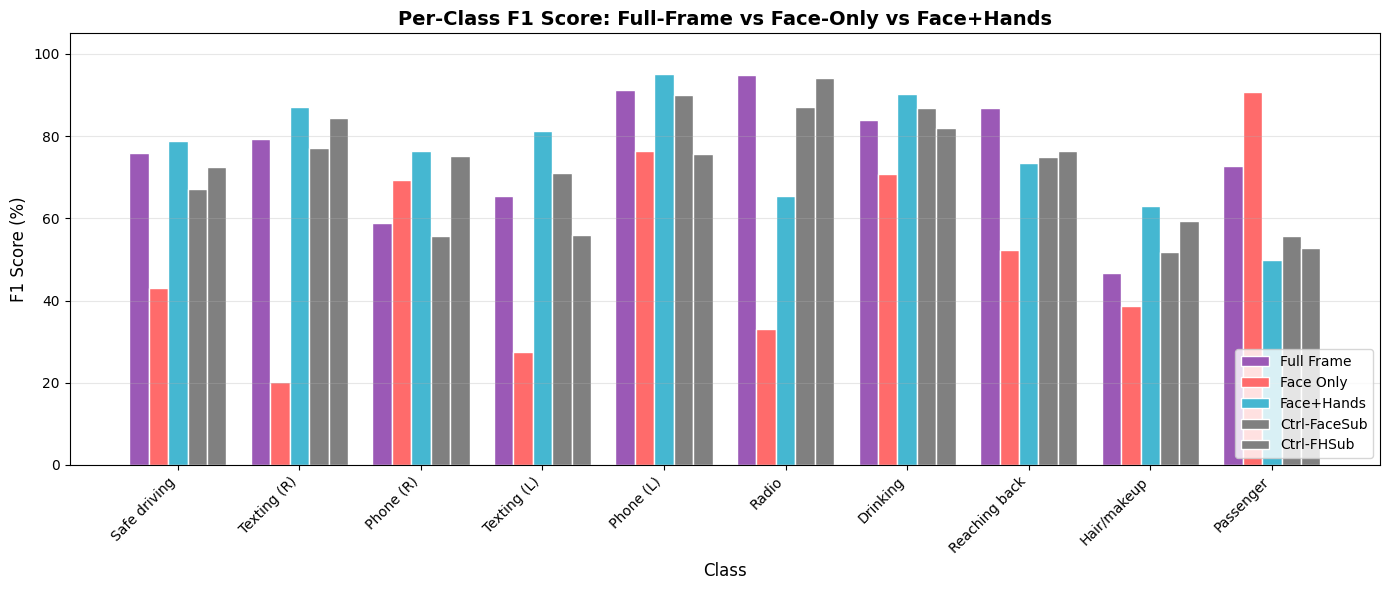

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/perclass_f1_comparison.png


In [ ]:
# Per-class F1 bar chart
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(10)
n_models = len(modalities)
width = 0.8 / n_models
offset = -width * (n_models - 1) / 2

colors = {"Full Frame": "#9B59B6", "Face Only": "#FF6B6B", "Face+Hands": "#45B7D1"}

for mod_name, mod_data in modalities.items():
    if mod_data:
        f1_scores = mod_data["per_class_f1"] * 100
        ax.bar(x + offset, f1_scores, width, label=mod_name, color=colors.get(mod_name, "gray"), edgecolor="white")
        offset += width

ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("F1 Score (%)", fontsize=12)
ax.set_title("Per-Class F1 Score: Full-Frame vs Face-Only vs Face+Hands", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([CLASS_NAMES.get(c, f"c{c}") for c in range(10)], rotation=45, ha="right")
ax.legend(loc="lower right")
ax.set_ylim(0, 105)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "perclass_f1_comparison.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"💾 Saved to {out_path}")


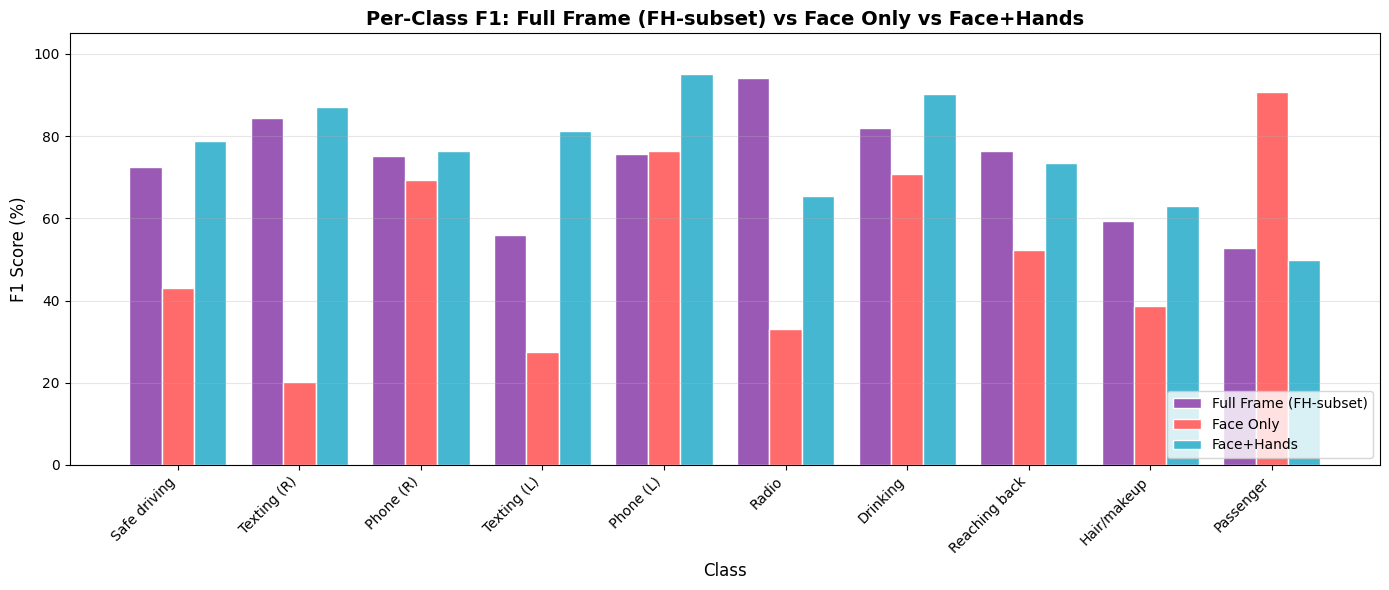

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/perclass_f1_comparison_fhsubset_3way.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(10)

selected_order = ["Ctrl-FHSub", "Face Only", "Face+Hands"]

colors = {
    "Ctrl-FHSub": "#9B59B6",
    "Face Only":  "#FF6B6B",
    "Face+Hands": "#45B7D1",
}

display_labels = {
    "Ctrl-FHSub": "Full Frame (FH-subset)",
    "Face Only":  "Face Only",
    "Face+Hands": "Face+Hands",
}

n_models = len(selected_order)
width = 0.8 / n_models
offset = -width * (n_models - 1) / 2

for mod_name in selected_order:
    mod_data = modalities.get(mod_name, None)
    if mod_data is None:
        raise KeyError(f"Missing modalities['{mod_name}'] — available keys: {list(modalities.keys())}")

    f1_scores = np.array(mod_data["per_class_f1"]) * 100

    ax.bar(
        x + offset,
        f1_scores,
        width,
        label=display_labels.get(mod_name, mod_name),   # ✅ pretty legend names
        color=colors.get(mod_name, "gray"),
        edgecolor="white"
    )
    offset += width

ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("F1 Score (%)", fontsize=12)
ax.set_title("Per-Class F1: Full Frame (FH-subset) vs Face Only vs Face+Hands", fontsize=14, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels([CLASS_NAMES.get(c, f"c{c}") for c in range(10)], rotation=45, ha="right")
ax.legend(loc="lower right")
ax.set_ylim(0, 105)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "perclass_f1_comparison_fhsubset_3way.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"💾 Saved to {out_path}")


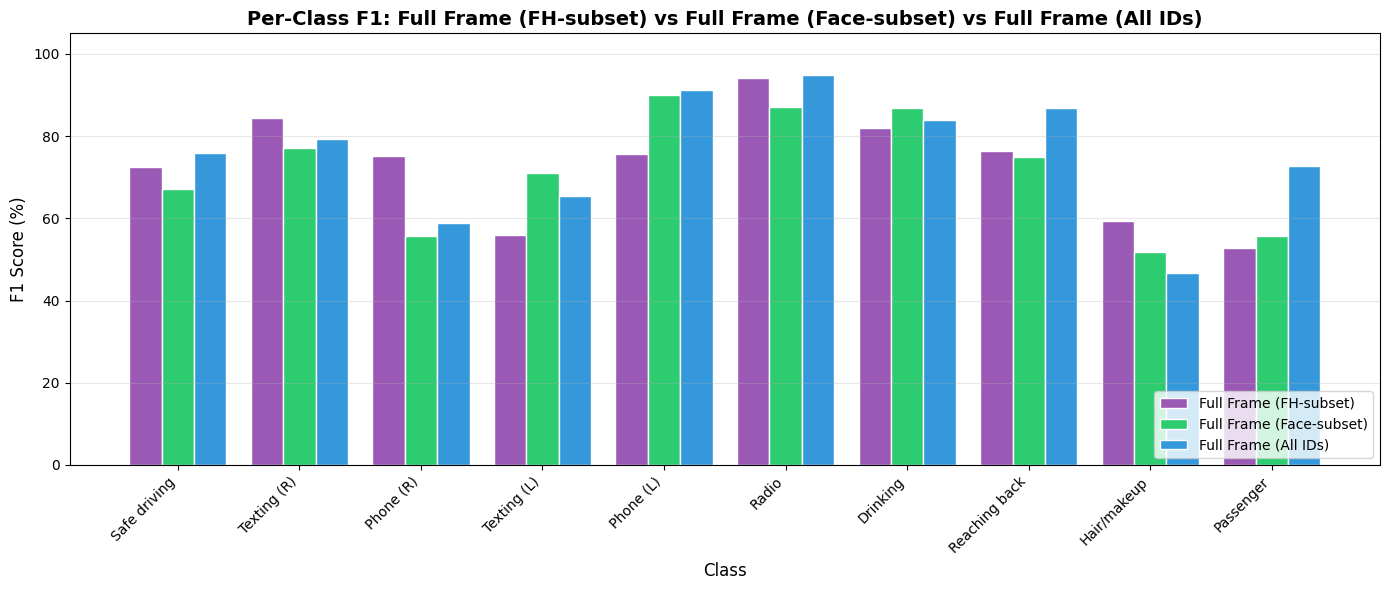

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/perclass_f1_comparison_fullframe_subsets_3way.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(10)

# ✅ The three full-frame variants you want to compare
selected_order = ["Ctrl-FHSub", "Ctrl-FaceSub", "Full Frame"]

colors = {
    "Ctrl-FHSub":   "#9B59B6",
    "Ctrl-FaceSub": "#2ECC71",
    "Full Frame":   "#3498DB",
}

display_labels = {
    "Ctrl-FHSub":   "Full Frame (FH-subset)",
    "Ctrl-FaceSub": "Full Frame (Face-subset)",
    "Full Frame":   "Full Frame (All IDs)",
}

n_models = len(selected_order)
width = 0.8 / n_models
offset = -width * (n_models - 1) / 2

for mod_name in selected_order:
    mod_data = modalities.get(mod_name, None)
    if mod_data is None:
        raise KeyError(
            f"Missing modalities['{mod_name}'] — available keys: {list(modalities.keys())}"
        )

    f1_scores = np.array(mod_data["per_class_f1"]) * 100

    ax.bar(
        x + offset,
        f1_scores,
        width,
        label=display_labels.get(mod_name, mod_name),
        color=colors.get(mod_name, "gray"),
        edgecolor="white"
    )
    offset += width

ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("F1 Score (%)", fontsize=12)
ax.set_title(
    "Per-Class F1: Full Frame (FH-subset) vs Full Frame (Face-subset) vs Full Frame (All IDs)",
    fontsize=14,
    fontweight="bold"
)

ax.set_xticks(x)
ax.set_xticklabels([CLASS_NAMES.get(c, f"c{c}") for c in range(10)], rotation=45, ha="right")
ax.legend(loc="lower right")
ax.set_ylim(0, 105)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "perclass_f1_comparison_fullframe_subsets_3way.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"💾 Saved to {out_path}")


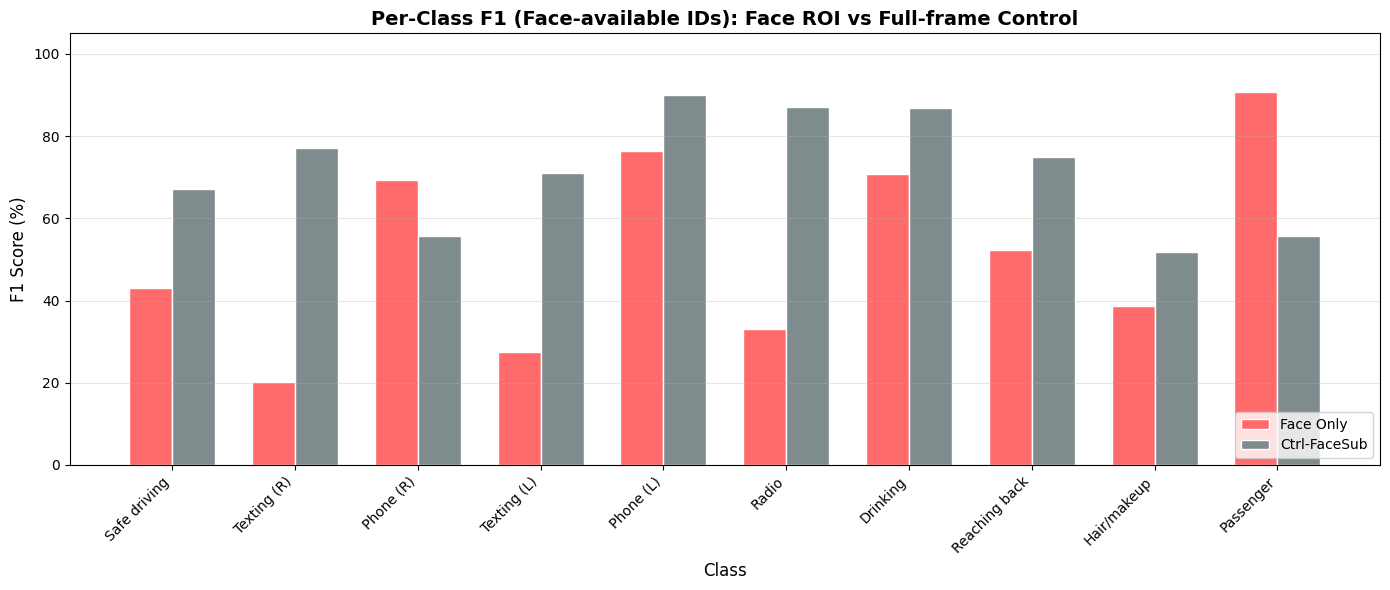

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/perclass_f1_face_vs_ctrl_facesub.png


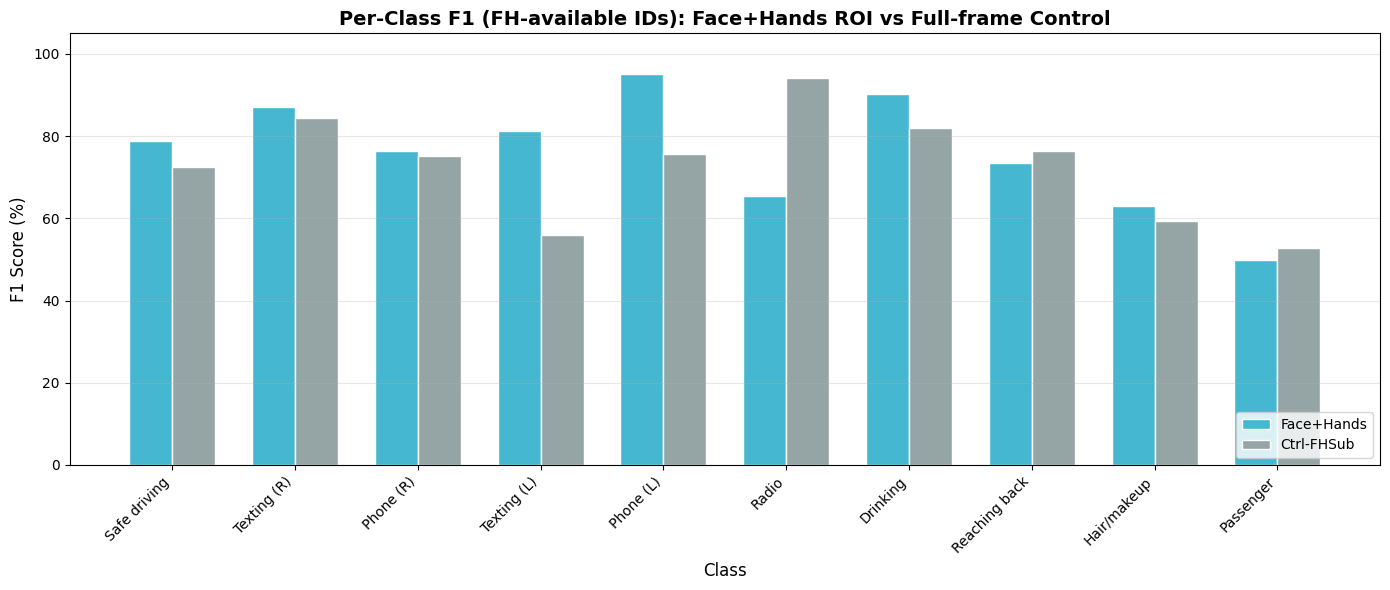

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/perclass_f1_facehands_vs_ctrl_fhsub.png


In [ ]:
# Option A: Paired per-class F1 plots (ROI vs matched full-frame control)
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ---- REQUIRED: your existing objects ----
# modalities: dict like {"Full Frame": {...}, "Face Only": {...}, "Face+Hands": {...}, "Ctrl-FaceSub": {...}, "Ctrl-FHSub": {...}}
# CLASS_NAMES: dict mapping class index -> readable label
# OUT_ROOT: string/path base output directory

OUT_ROOT       = f"{DRIVE_PATH}/outputs"

# --- Natural runs (different ID sets) ---
FULL_FRAME_PREDS = Path(OUT_ROOT) / "preds/test/effb0_full_image_1_11_test.csv"        # Run 1: Full-frame, all IDs
FACE_ONLY_PREDS = Path(OUT_ROOT) / "preds/test/effb0_face_1_11_test.csv"              # Run 2: Face ROI
FACE_HANDS_PREDS = Path(OUT_ROOT) / "preds/test/effb0_face_hands_1_11_test.csv"       # Run 3: Face+Hands ROI

# --- Control runs (filtered to match ROI ID sets) ---
CONTROL_FACESUBSET_PREDS = Path(OUT_ROOT) / "preds/test/effb0_full_image_facesubset_1_10_test.csv"  # Run 4: Full-frame, face-available IDs
CONTROL_FHSUBSET_PREDS = Path(OUT_ROOT) / "preds/test/effb0_full_image_fhsubset_1_10_test.csv"      # Run 5: Full-frame, FH-available IDs

CLASS_NAMES = {
    0: "Safe driving", 1: "Texting (R)", 2: "Phone (R)", 3: "Texting (L)",
    4: "Phone (L)", 5: "Radio", 6: "Drinking", 7: "Reaching back",
    8: "Hair/makeup", 9: "Passenger",
}


# ----- Plot settings -----
x = np.arange(10)
bar_width = 0.35

# You can keep your colors; I’m adding control colors that are readable.
colors = {
    "Face Only":   "#FF6B6B",
    "Face+Hands":  "#45B7D1",
    "Ctrl-FaceSub": "#7F8C8D",  # control (gray)
    "Ctrl-FHSub":   "#95A5A6",  # control (lighter gray)
}

# Define the two paired comparisons (edit the keys here if your dict uses different names)
PAIR_SPECS = [
    {
        "name_left": "Face Only",
        "name_right": "Ctrl-FaceSub",
        "title": "Per-Class F1 (Face-available IDs): Face ROI vs Full-frame Control",
        "filename": "perclass_f1_face_vs_ctrl_facesub.png",
    },
    {
        "name_left": "Face+Hands",
        "name_right": "Ctrl-FHSub",
        "title": "Per-Class F1 (FH-available IDs): Face+Hands ROI vs Full-frame Control",
        "filename": "perclass_f1_facehands_vs_ctrl_fhsub.png",
    },
]

def plot_pair(modalities, left_name, right_name, title, out_path):
    # ---- Safety checks ----
    if left_name not in modalities or modalities[left_name] is None:
        raise KeyError(f"Missing modalities['{left_name}'] or it is None.")
    if right_name not in modalities or modalities[right_name] is None:
        raise KeyError(f"Missing modalities['{right_name}'] or it is None.")
    if "per_class_f1" not in modalities[left_name]:
        raise KeyError(f"modalities['{left_name}'] missing 'per_class_f1'.")
    if "per_class_f1" not in modalities[right_name]:
        raise KeyError(f"modalities['{right_name}'] missing 'per_class_f1'.")

    left_f1 = np.array(modalities[left_name]["per_class_f1"]) * 100
    right_f1 = np.array(modalities[right_name]["per_class_f1"]) * 100

    fig, ax = plt.subplots(figsize=(14, 6))

    ax.bar(x - bar_width/2, left_f1, bar_width,
           label=left_name, color=colors.get(left_name, "gray"),
           edgecolor="white")

    ax.bar(x + bar_width/2, right_f1, bar_width,
           label=right_name, color=colors.get(right_name, "gray"),
           edgecolor="white")

    ax.set_xlabel("Class", fontsize=12)
    ax.set_ylabel("F1 Score (%)", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")

    ax.set_xticks(x)
    ax.set_xticklabels([CLASS_NAMES.get(c, f"c{c}") for c in range(10)],
                       rotation=45, ha="right")

    ax.legend(loc="lower right")
    ax.set_ylim(0, 105)
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"💾 Saved to {out_path}")

# ---- Run both paired plots ----
out_dir = Path(OUT_ROOT) / "metrics"

for spec in PAIR_SPECS:
    out_path = out_dir / spec["filename"]
    plot_pair(
        modalities=modalities,
        left_name=spec["name_left"],
        right_name=spec["name_right"],
        title=spec["title"],
        out_path=out_path
    )


## Per-Class Support by Modality

In [ ]:
## 📊 Table A2: Per-Class Support Comparison by Modality
# Shows sample counts per class across modalities to contextualize F1 stability

import pandas as pd
import numpy as np
from pathlib import Path

def load_preds_with_labels(pred_path):
    """Load predictions and extract true class labels."""
    if pred_path is None or not Path(pred_path).exists():
        return None

    df = pd.read_csv(pred_path)

    def extract_class(path):
        for p in reversed(Path(path).parts):
            if p.startswith("c") and len(p) == 2 and p[1].isdigit():
                return int(p[1])
        return -1

    df["true"] = df["path"].apply(extract_class)
    return df[df["true"] >= 0]

# Load all prediction files
preds_data = {
    "Full Frame (All)": load_preds_with_labels(FULL_FRAME_PREDS),
    "Face+Hands": load_preds_with_labels(FACE_HANDS_PREDS),
    "Face Only": load_preds_with_labels(FACE_ONLY_PREDS),
}

# Add control runs if they exist (optional — they should match Face/FH ID counts)
if CONTROL_FHSUBSET_PREDS and CONTROL_FHSUBSET_PREDS.exists():
    preds_data["Ctrl-FHSub"] = load_preds_with_labels(CONTROL_FHSUBSET_PREDS)
if CONTROL_FACESUBSET_PREDS and CONTROL_FACESUBSET_PREDS.exists():
    preds_data["Ctrl-FaceSub"] = load_preds_with_labels(CONTROL_FACESUBSET_PREDS)

# Build per-class support table
support_rows = []
for c in range(10):
    row = {
        "Class": f"c{c}",
        "Name": CLASS_NAMES.get(c, f"Class {c}"),
    }
    for mod_name, df in preds_data.items():
        if df is not None:
            count = (df["true"] == c).sum()
            row[mod_name] = count
        else:
            row[mod_name] = None
    support_rows.append(row)

support_df = pd.DataFrame(support_rows)

# Add totals row
totals_row = {"Class": "Total", "Name": "—"}
for mod_name, df in preds_data.items():
    if df is not None:
        totals_row[mod_name] = len(df)
    else:
        totals_row[mod_name] = None
support_df = pd.concat([support_df, pd.DataFrame([totals_row])], ignore_index=True)

# Display table
print("=" * 100)
print("📊 TABLE A2: Per-Class Support Comparison by Modality (Test Set)")
print("=" * 100)
print("Lower support in crop-based modalities → F1 estimates computed on smaller samples\n")
print(support_df.to_string(index=False))

# Compute retention rates (% of full-frame samples retained per class)
print("\n" + "=" * 100)
print("📊 Per-Class Retention Rate (% of Full Frame samples available in each modality)")
print("=" * 100)

retention_rows = []
full_frame_df = preds_data.get("Full Frame (All)")

for c in range(10):
    row = {"Class": f"c{c}", "Name": CLASS_NAMES.get(c, f"Class {c}")}
    full_count = (full_frame_df["true"] == c).sum() if full_frame_df is not None else 0

    for mod_name in ["Face+Hands", "Face Only"]:
        df = preds_data.get(mod_name)
        if df is not None and full_count > 0:
            mod_count = (df["true"] == c).sum()
            retention_pct = (mod_count / full_count) * 100
            row[f"{mod_name} (%)"] = f"{retention_pct:.1f}%"
            row[f"{mod_name} (n)"] = mod_count
        else:
            row[f"{mod_name} (%)"] = "—"
            row[f"{mod_name} (n)"] = "—"
    retention_rows.append(row)

retention_df = pd.DataFrame(retention_rows)
print(retention_df.to_string(index=False))

# Highlight classes with low retention (potential instability)
print("\n⚠️  Classes with <70% retention may show unstable F1 estimates in ROI modalities")
for c in range(10):
    if full_frame_df is not None:
        full_count = (full_frame_df["true"] == c).sum()
        for mod_name in ["Face+Hands", "Face Only"]:
            df = preds_data.get(mod_name)
            if df is not None and full_count > 0:
                mod_count = (df["true"] == c).sum()
                retention = (mod_count / full_count) * 100
                if retention < 70:
                    print(f"   • c{c} ({CLASS_NAMES.get(c)}): {mod_name} has {retention:.1f}% retention ({mod_count}/{full_count})")

# Save to CSV
out_dir = Path(OUT_ROOT) / "metrics" / "thesis_tables"
out_dir.mkdir(parents=True, exist_ok=True)

support_df.to_csv(out_dir / "table_a2_perclass_support.csv", index=False)
retention_df.to_csv(out_dir / "table_a2_retention_rates.csv", index=False)
print(f"\n💾 Saved: {out_dir / 'table_a2_perclass_support.csv'}")
print(f"💾 Saved: {out_dir / 'table_a2_retention_rates.csv'}")

# Generate LaTeX for appendix
latex_support = r"""\begin{table}[htbp]
\centering
\caption{Per-class test set support across modalities. Lower support in crop-based modalities indicates F1 estimates are computed on smaller samples.}
\label{tab:perclass_support}
\begin{tabular}{llrrr}
\toprule
Class & Description & Full Frame & Face+Hands & Face Only \\
\midrule
"""

for _, row in support_df.iterrows():
    name_escaped = str(row["Name"]).replace("&", r"\&")
    ff = row.get("Full Frame (All)", "—")
    fh = row.get("Face+Hands", "—")
    fo = row.get("Face Only", "—")
    latex_support += f"{row['Class']} & {name_escaped} & {ff} & {fh} & {fo} \\\\\n"

latex_support += r"""\bottomrule
\end{tabular}
\end{table}
"""

print("\n" + "=" * 100)
print("📝 LATEX TABLE A2: Per-Class Support by Modality (for appendix)")
print("=" * 100)
print(latex_support)

with open(out_dir / "table_a2_perclass_support.tex", "w") as f:
    f.write(latex_support)
print(f"💾 Saved: {out_dir / 'table_a2_perclass_support.tex'}")

📊 TABLE A2: Per-Class Support Comparison by Modality (Test Set)
Lower support in crop-based modalities → F1 estimates computed on smaller samples

Class          Name  Full Frame (All)  Face+Hands  Face Only  Ctrl-FHSub  Ctrl-FaceSub
   c0  Safe driving               346         339        344         339           344
   c1   Texting (R)               213         206        211         206           211
   c2     Phone (R)               194         157        163         157           163
   c3   Texting (L)               180         156        157         156           157
   c4     Phone (L)               170         167        167         167           167
   c5         Radio               170         170        170         170           170
   c6      Drinking               143          97        100          97           100
   c7 Reaching back               143         125        128         125           128
   c8   Hair/makeup               146         115        119         1

## 🎯 Section 5: Delta Heatmap (Thesis Figure)


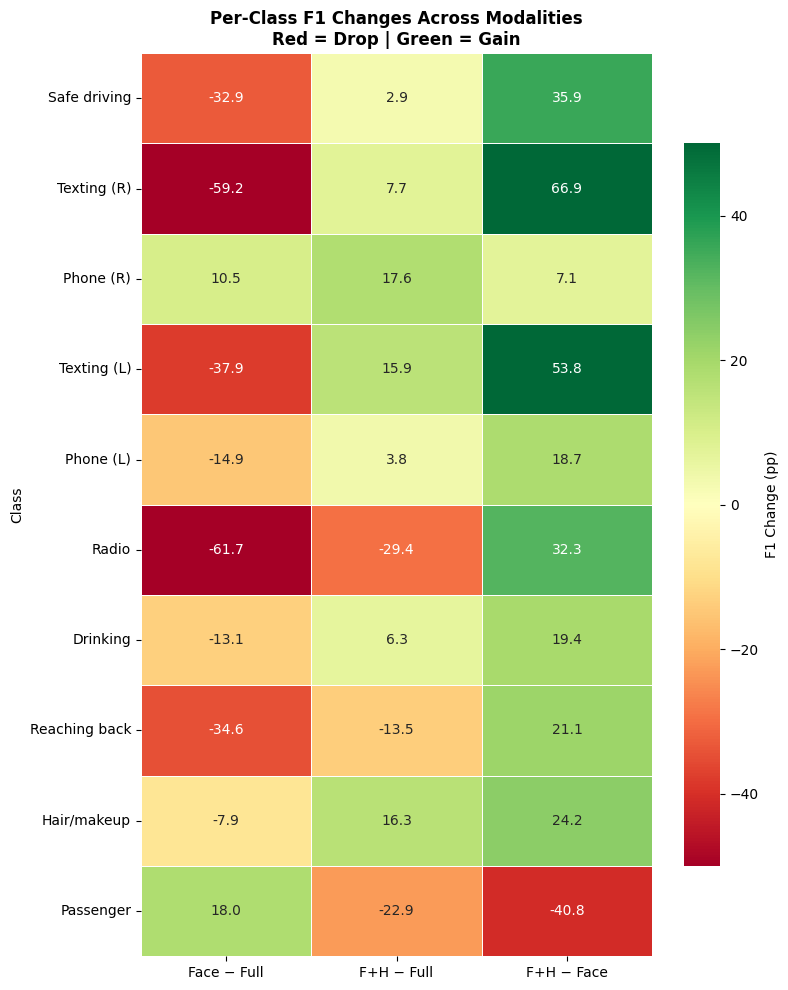

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/delta_heatmap_f1_modalities.png


In [ ]:
# Delta heatmap showing F1 changes across modalities
import seaborn as sns

delta_data = []
for c in range(10):
    f1_full = modalities.get("Full Frame", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Full Frame") else 0
    f1_face = modalities.get("Face Only", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face Only") else 0
    f1_fh = modalities.get("Face+Hands", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face+Hands") else 0

    delta_data.append({
        "Class": CLASS_NAMES.get(c, f"c{c}"),
        "Face − Full": (f1_face - f1_full) * 100,
        "F+H − Full": (f1_fh - f1_full) * 100,
        "F+H − Face": (f1_fh - f1_face) * 100,
    })

delta_df = pd.DataFrame(delta_data)
delta_matrix = delta_df.set_index("Class")[["Face − Full", "F+H − Full", "F+H − Face"]]

fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(delta_matrix, annot=True, fmt=".1f", cmap="RdYlGn", center=0, vmin=-50, vmax=50, ax=ax,
            linewidths=0.5, cbar_kws={"label": "F1 Change (pp)", "shrink": 0.8})
ax.set_title("Per-Class F1 Changes Across Modalities\nRed = Drop | Green = Gain", fontsize=12, fontweight="bold")
plt.tight_layout()

out_path = Path(OUT_ROOT) / "metrics" / "delta_heatmap_f1_modalities.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"💾 Saved to {out_path}")

# Save CSV
delta_matrix.to_csv(Path(OUT_ROOT) / "metrics" / "delta_f1_by_class.csv")


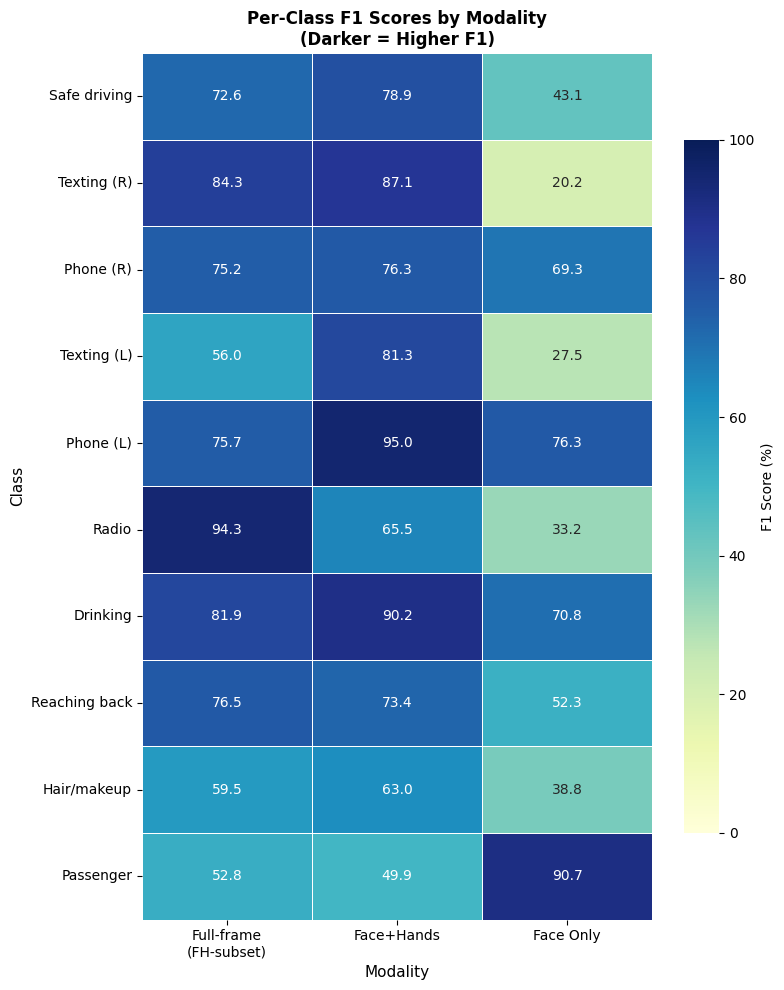

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/raw_f1_heatmap_3modalities.png
💾 Saved CSV to /content/drive/MyDrive/TFM/outputs/metrics/raw_f1_by_class_3modalities.csv


In [ ]:
# ============================================================================
# 📊 RAW F1 HEATMAP: Absolute per-class F1 scores
# ============================================================================
# Shows actual F1 values (not deltas) for easier interpretation.
# Modalities: Full-frame (FH-subset), Face+Hands, Face Only

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Build raw F1 data
raw_f1_data = []
for c in range(10):
    f1_ctrl_fh = modalities.get("Ctrl-FHSub", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Ctrl-FHSub") else 0
    f1_fh = modalities.get("Face+Hands", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face+Hands") else 0
    f1_face = modalities.get("Face Only", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face Only") else 0

    raw_f1_data.append({
        "Class": CLASS_NAMES.get(c, f"c{c}"),
        "Full-frame\n(FH-subset)": f1_ctrl_fh * 100,
        "Face+Hands": f1_fh * 100,
        "Face Only": f1_face * 100,
    })

raw_f1_df = pd.DataFrame(raw_f1_data)
raw_f1_matrix = raw_f1_df.set_index("Class")[["Full-frame\n(FH-subset)", "Face+Hands", "Face Only"]]

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(
    raw_f1_matrix,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",  # Yellow-Green-Blue: darker = higher F1
    vmin=0,
    vmax=100,
    ax=ax,
    linewidths=0.5,
    cbar_kws={"label": "F1 Score (%)", "shrink": 0.8}
)
ax.set_title("Per-Class F1 Scores by Modality\n(Darker = Higher F1)", fontsize=12, fontweight="bold")
ax.set_xlabel("Modality", fontsize=11)
ax.set_ylabel("Class", fontsize=11)

plt.tight_layout()

out_path = Path(OUT_ROOT) / "metrics" / "raw_f1_heatmap_3modalities.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"💾 Saved to {out_path}")

# Also save CSV
raw_f1_matrix.to_csv(Path(OUT_ROOT) / "metrics" / "raw_f1_by_class_3modalities.csv")
print(f"💾 Saved CSV to {Path(OUT_ROOT) / 'metrics' / 'raw_f1_by_class_3modalities.csv'}")

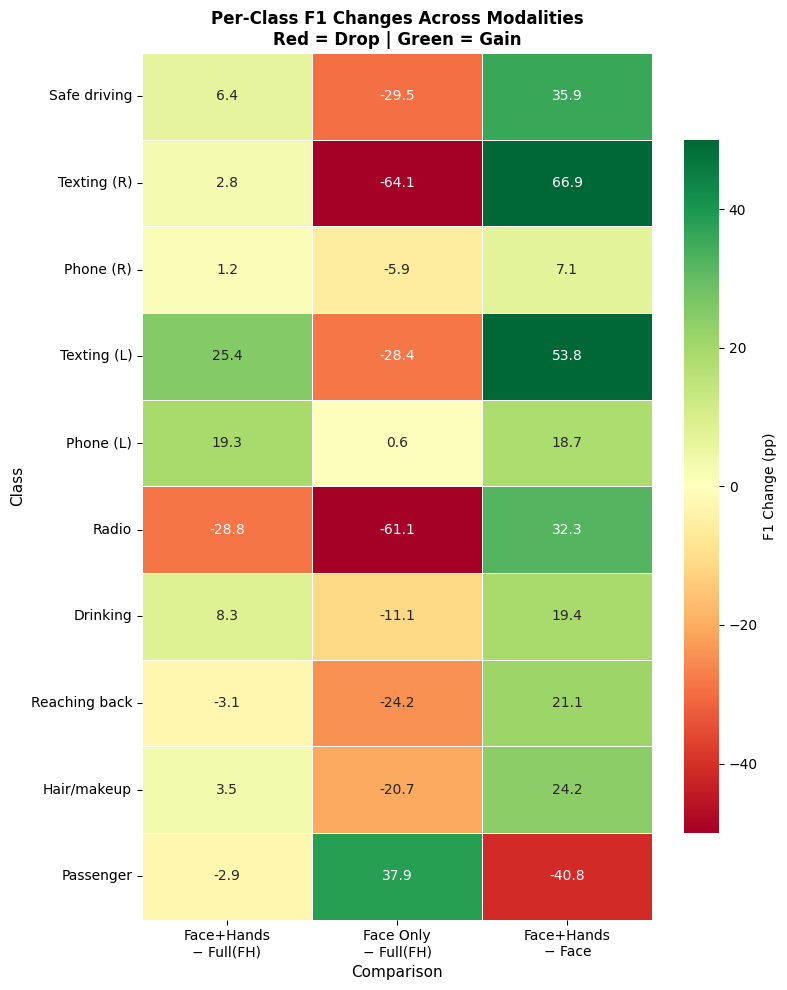

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/delta_heatmap_f1_fhsubset_baseline.png
💾 Saved CSV to /content/drive/MyDrive/TFM/outputs/metrics/delta_f1_by_class_fhsubset_baseline.csv


In [ ]:
# ============================================================================
# 📊 DELTA F1 HEATMAP: Per-class F1 changes relative to Full-frame (FH-subset)
# ============================================================================
# Compares Face+Hands and Face Only against Full-frame on same ID subsets.
# Positive (green) = ROI modality outperforms full-frame
# Negative (red) = Full-frame outperforms ROI modality

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Build delta data using Ctrl-FHSub as baseline
delta_data = []
for c in range(10):
    f1_ctrl_fh = modalities.get("Ctrl-FHSub", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Ctrl-FHSub") else 0
    f1_fh = modalities.get("Face+Hands", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face+Hands") else 0
    f1_face = modalities.get("Face Only", {}).get("per_class_f1", np.zeros(10))[c] if modalities.get("Face Only") else 0

    delta_data.append({
        "Class": CLASS_NAMES.get(c, f"c{c}"),
        "Face+Hands\n− Full(FH)": (f1_fh - f1_ctrl_fh) * 100,
        "Face Only\n− Full(FH)": (f1_face - f1_ctrl_fh) * 100,
        "Face+Hands\n− Face": (f1_fh - f1_face) * 100,
    })

delta_df = pd.DataFrame(delta_data)
delta_matrix = delta_df.set_index("Class")[["Face+Hands\n− Full(FH)", "Face Only\n− Full(FH)", "Face+Hands\n− Face"]]

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(
    delta_matrix,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",  # Red-Yellow-Green: red = negative, green = positive
    center=0,
    vmin=-50,
    vmax=50,
    ax=ax,
    linewidths=0.5,
    cbar_kws={"label": "F1 Change (pp)", "shrink": 0.8}
)
ax.set_title("Per-Class F1 Changes Across Modalities\nRed = Drop | Green = Gain", fontsize=12, fontweight="bold")
ax.set_xlabel("Comparison", fontsize=11)
ax.set_ylabel("Class", fontsize=11)

plt.tight_layout()

out_path = Path(OUT_ROOT) / "metrics" / "delta_heatmap_f1_fhsubset_baseline.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()
print(f"💾 Saved to {out_path}")

# Save CSV
delta_matrix.to_csv(Path(OUT_ROOT) / "metrics" / "delta_f1_by_class_fhsubset_baseline.csv")
print(f"💾 Saved CSV to {Path(OUT_ROOT) / 'metrics' / 'delta_f1_by_class_fhsubset_baseline.csv'}")

## 🔍 Section 6: Confusion Matrix Comparison (Thesis Figure)


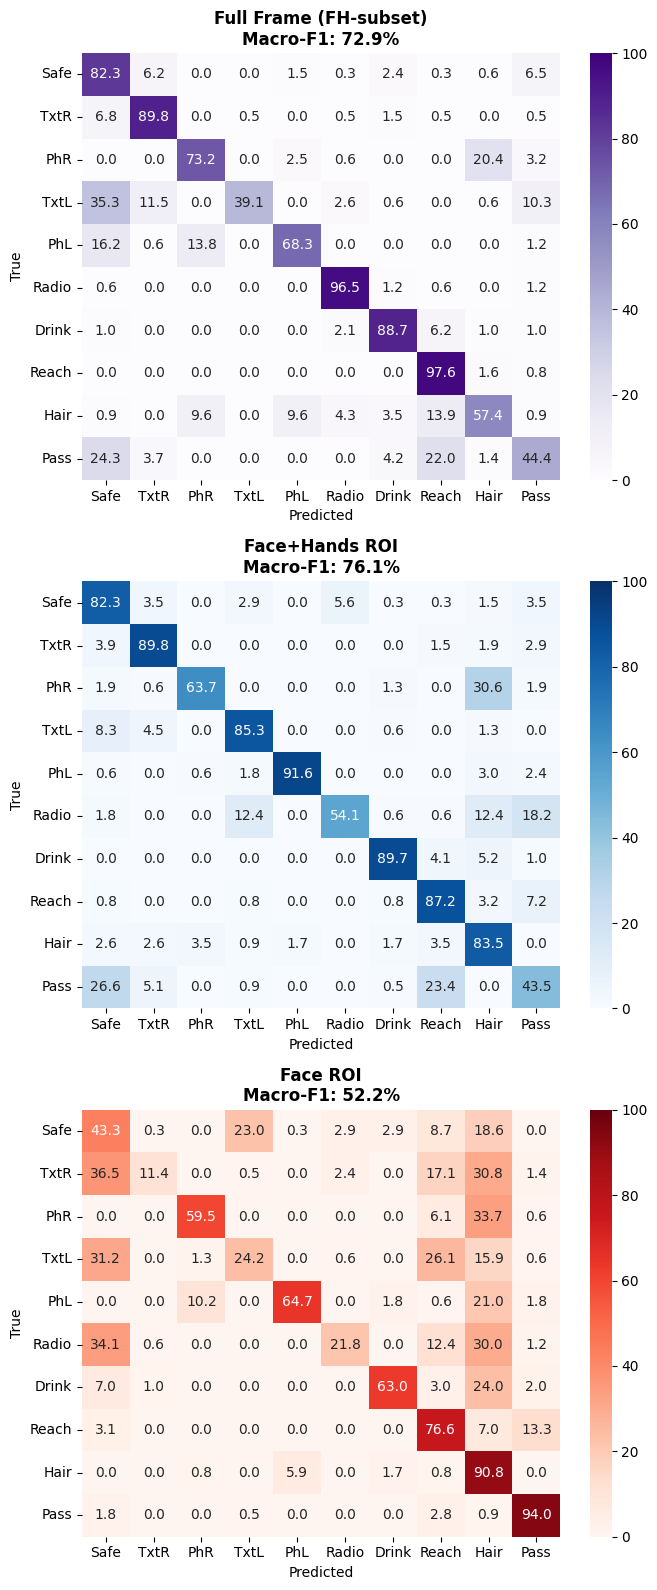

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/confusion_stack_fhsub_fullframe_vs_rois.png


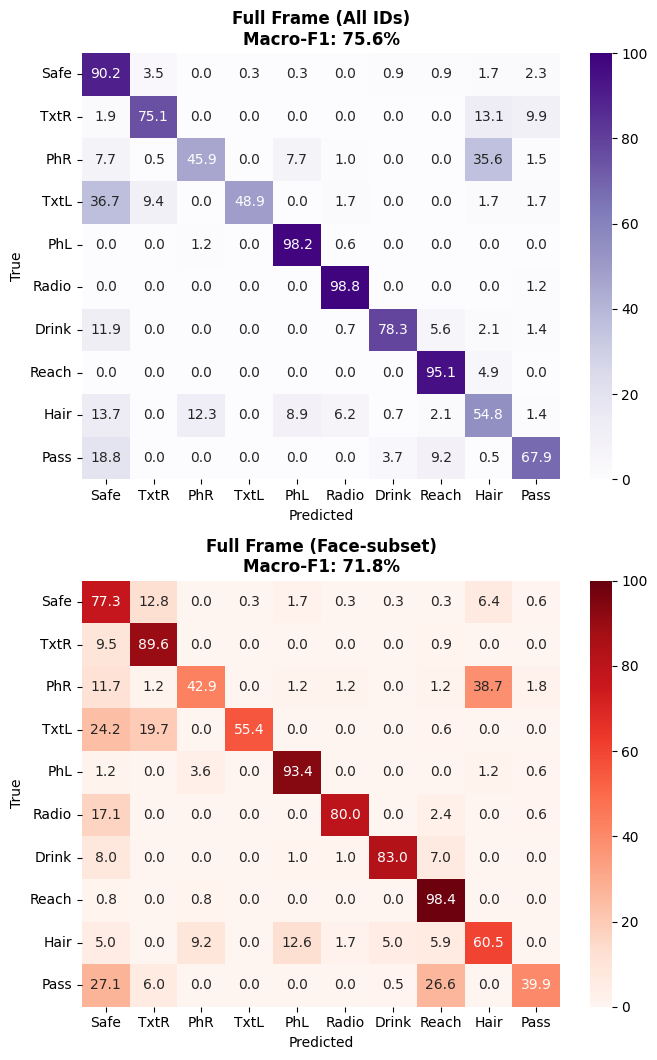

💾 Saved to /content/drive/MyDrive/TFM/outputs/metrics/confusion_stack_fullframe_all_vs_subsets.png


In [ ]:
# Confusion matrix comparison: All modalities (natural + control)
from sklearn.metrics import confusion_matrix, f1_score as sklearn_f1

CLASS_NAMES_SHORT = ["Safe", "TxtR", "PhR", "TxtL", "PhL", "Radio", "Drink", "Reach", "Hair", "Pass"]

def load_preds_for_cm(pred_path):
    df = pd.read_csv(pred_path)
    def extract_class(path):
        for p in reversed(Path(path).parts):
            if p.startswith("c") and len(p) == 2 and p[1].isdigit():
                return int(p[1])
        return -1
    df["true"] = df["path"].apply(extract_class)
    df["pred"] = df["pred_class_id"].apply(lambda x: int(x[1]) if isinstance(x, str) and x.startswith("c") else int(x))
    return df[df["true"] >= 0]

# Load all (natural + control)
all_runs = [
    ("Full Frame", FULL_FRAME_PREDS),
    ("Face Only", FACE_ONLY_PREDS),
    ("Face+Hands", FACE_HANDS_PREDS),
    ("Ctrl-FaceSub", CONTROL_FACESUBSET_PREDS),
    ("Ctrl-FHSub", CONTROL_FHSUBSET_PREDS),
]

cms = {}
f1s = {}
for name, path in all_runs:
    if path and path.exists():
        df = load_preds_for_cm(path)
        cm = confusion_matrix(df["true"], df["pred"], labels=range(10))
        cms[name] = cm
        f1s[name] = sklearn_f1(df["true"], df["pred"], average='macro')

# --- Plotting: two vertical-stack figures (fixed order) ---
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_cm_stack(run_order, filename, cmap_map, display_name_map=None, figsize=(7, 14)):
    """
    run_order: list of run keys (must match keys used in cms/f1s, e.g., 'Ctrl-FHSub')
    filename: output png filename
    cmap_map: dict of run_key -> seaborn cmap name
    display_name_map: dict of run_key -> pretty display name for titles
    """
    display_name_map = display_name_map or {}

    nrows = len(run_order)
    fig, axes = plt.subplots(nrows, 1, figsize=figsize)

    # If only 1 row, axes isn't a list — normalize it
    if nrows == 1:
        axes = [axes]

    for ax, run_key in zip(axes, run_order):
        if run_key not in cms:
            # If missing, show a blank panel with a clear message
            ax.axis("off")
            ax.set_title(f"{display_name_map.get(run_key, run_key)}\n⚠️ Missing predictions file", fontweight="bold")
            continue

        cm = cms[run_key]
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
        cm_norm = np.nan_to_num(cm_norm)

        sns.heatmap(
            cm_norm,
            annot=True,
            fmt=".1f",
            cmap=cmap_map.get(run_key, "Blues"),
            ax=ax,
            xticklabels=CLASS_NAMES_SHORT,
            yticklabels=CLASS_NAMES_SHORT,
            vmin=0,
            vmax=100
        )

        pretty = display_name_map.get(run_key, run_key)
        ax.set_title(f"{pretty}\nMacro-F1: {f1s[run_key]*100:.1f}%", fontweight="bold")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    out_path = Path(OUT_ROOT) / "metrics" / filename
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"💾 Saved to {out_path}")


# ---------------------------
# Figure A: (FH-subset Full-frame) -> Face+Hands -> Face Only
# ---------------------------
stack_A = ["Ctrl-FHSub", "Face+Hands", "Face Only"]

display_names = {
    "Ctrl-FHSub": "Full Frame (FH-subset)",
    "Ctrl-FaceSub": "Full Frame (Face-subset)",
    "Full Frame": "Full Frame (All IDs)",
    "Face+Hands": "Face+Hands ROI",
    "Face Only": "Face ROI",
}

cmaps_A = {
    "Ctrl-FHSub": "Purples",   # keep FH-subset full frame purple, as you wanted
    "Face+Hands": "Blues",
    "Face Only": "Reds",
}

plot_cm_stack(
    run_order=stack_A,
    filename="confusion_stack_fhsub_fullframe_vs_rois.png",
    cmap_map=cmaps_A,
    display_name_map=display_names,
    figsize=(7, 16)
)


# ---------------------------
# Figure B: Full Frame (All) -> Full Frame (FH-subset) -> Full Frame (Face-subset)
# ---------------------------
stack_B = ["Full Frame", "Ctrl-FaceSub"]

cmaps_B = {
    "Full Frame": "Purples",
    "Ctrl-FaceSub": "Reds",
}

plot_cm_stack(
    run_order=stack_B,
    filename="confusion_stack_fullframe_all_vs_subsets.png",
    cmap_map=cmaps_B,
    display_name_map=display_names,
    figsize=(7, 10.7)
)


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix

# Short labels (matches your heatmaps)
CLASS_NAMES_SHORT = ["Safe", "TxtR", "PhR", "TxtL", "PhL", "Radio", "Drink", "Reach", "Hair", "Pass"]

def load_preds_for_cm(pred_path: Path) -> pd.DataFrame:
    df = pd.read_csv(pred_path)

    def extract_class(path):
        # expects .../cX/... where X is 0-9
        for p in reversed(Path(path).parts):
            if p.startswith("c") and len(p) == 2 and p[1].isdigit():
                return int(p[1])
        return -1

    df["true"] = df["path"].apply(extract_class)

    # pred_class_id can be "c7" or an int
    def parse_pred(x):
        if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
            return int(x[1])
        return int(x)

    df["pred"] = df["pred_class_id"].apply(parse_pred)
    return df[df["true"] >= 0].copy()

def get_top_confusions(df: pd.DataFrame, k: int = 5):
    """
    Returns top-k off-diagonal confusions ranked by row-normalized rate (%),
    along with count (n). Rate is: cm[true, pred] / sum_row(true).
    """
    cm = confusion_matrix(df["true"], df["pred"], labels=range(10))
    row_sums = cm.sum(axis=1)

    entries = []
    for true_c in range(10):
        denom = row_sums[true_c]
        if denom == 0:
            continue
        for pred_c in range(10):
            if pred_c == true_c:
                continue
            n = int(cm[true_c, pred_c])
            if n == 0:
                continue
            rate = (n / denom) * 100.0
            entries.append({
                "true": true_c,
                "pred": pred_c,
                "rate": rate,
                "n": n
            })

    # Sort: primarily by rate%, secondarily by count
    entries.sort(key=lambda d: (d["rate"], d["n"]), reverse=True)

    # Take top-k
    topk = entries[:k]

    # Format strings
    formatted = []
    for rank, item in enumerate(topk, start=1):
        t = CLASS_NAMES_SHORT[item["true"]]
        p = CLASS_NAMES_SHORT[item["pred"]]
        formatted.append({
            "Rank": rank,
            "True → Pred": f"{t} → {p}",
            "Rate% (n)": f"{item['rate']:.1f}% ({item['n']})"
        })
    return formatted

def print_top_confusions_block(title: str, df: pd.DataFrame, k: int = 5):
    topk = get_top_confusions(df, k=k)

    print(f"\n📌 {title} Top Confusions:")
    print("|   Rank | True → Pred   | Rate% (n)   |")
    print("|--------|---------------|-------------|")
    for row in topk:
        print(f"| {row['Rank']:6d} | {row['True → Pred']:<13} | {row['Rate% (n)']:<11} |")

def safe_load(path_var, name: str):
    if path_var is None:
        print(f"⚠️ {name}: path is None")
        return None
    path = Path(path_var)
    if not path.exists():
        print(f"⚠️ {name}: file not found at {path}")
        return None
    return load_preds_for_cm(path)

# ---------------------------------------------------------
# LOAD RUNS (edit names here ONLY if your variable names differ)
# ---------------------------------------------------------
df_full_all      = safe_load(FULL_FRAME_PREDS, "Full Frame (All IDs)")
df_full_fhsub    = safe_load(CONTROL_FHSUBSET_PREDS, "Full Frame (FH-subset)")
df_full_facesub  = safe_load(CONTROL_FACESUBSET_PREDS, "Full Frame (Face-subset)")
df_face_only     = safe_load(FACE_ONLY_PREDS, "Face ROI")
df_face_hands    = safe_load(FACE_HANDS_PREDS, "Face+Hands ROI")

# ---------------------------------------------------------
# PRINT MAIN TEXT TABLE BLOCKS
# ---------------------------------------------------------
print("\n" + "="*80)
print("🔍 TOP CONFUSION PAIRS (row-normalized rate + count)")
print("="*80)

# MAIN TEXT: Full frame should be FH-subset
if df_full_fhsub is not None:
    print_top_confusions_block("FULL FRAME (FH-subset)", df_full_fhsub, k=5)

if df_face_only is not None:
    print_top_confusions_block("FACE ONLY (Face-available IDs)", df_face_only, k=5)

if df_face_hands is not None:
    print_top_confusions_block("FACE+HANDS (FH-available IDs)", df_face_hands, k=5)

# ---------------------------------------------------------
# PRINT APPENDIX: additional full-frame variants
# ---------------------------------------------------------
print("\n" + "="*80)
print("📎 APPENDIX: FULL-FRAME TOP CONFUSIONS ACROSS ID SETS")
print("="*80)

if df_full_all is not None:
    print_top_confusions_block("FULL FRAME (All IDs)", df_full_all, k=5)

if df_full_facesub is not None:
    print_top_confusions_block("FULL FRAME (Face-subset)", df_full_facesub, k=5)



🔍 TOP CONFUSION PAIRS (row-normalized rate + count)

📌 FULL FRAME (FH-subset) Top Confusions:
|   Rank | True → Pred   | Rate% (n)   |
|--------|---------------|-------------|
|      1 | TxtL → Safe   | 35.3% (55)  |
|      2 | Pass → Safe   | 24.3% (52)  |
|      3 | Pass → Reach  | 22.0% (47)  |
|      4 | PhR → Hair    | 20.4% (32)  |
|      5 | PhL → Safe    | 16.2% (27)  |

📌 FACE ONLY (Face-available IDs) Top Confusions:
|   Rank | True → Pred   | Rate% (n)   |
|--------|---------------|-------------|
|      1 | TxtR → Safe   | 36.5% (77)  |
|      2 | Radio → Safe  | 34.1% (58)  |
|      3 | PhR → Hair    | 33.7% (55)  |
|      4 | TxtL → Safe   | 31.2% (49)  |
|      5 | TxtR → Hair   | 30.8% (65)  |

📌 FACE+HANDS (FH-available IDs) Top Confusions:
|   Rank | True → Pred   | Rate% (n)   |
|--------|---------------|-------------|
|      1 | PhR → Hair    | 30.6% (48)  |
|      2 | Pass → Safe   | 26.6% (57)  |
|      3 | Pass → Reach  | 23.4% (50)  |
|      4 | Radio → Pass  | 

## 🎯 Section 7: Control Run Analysis (5-Run Comparison)

This section compares ROI models against their matched full-frame controls to isolate the effect of ROI cropping vs ID filtering.


In [ ]:
# Control Run Analysis: Isolate the ROI effect
# This answers: "Is it the crop or just the data subset that matters?"

control_analysis_available = (
    "Face+Hands" in modalities and "Ctrl-FHSub" in modalities
) or ("Face Only" in modalities and "Ctrl-FaceSub" in modalities)

if control_analysis_available:
    print("=" * 80)
    print("🎯 CONTROL RUN ANALYSIS: Isolating ROI Effect")
    print("=" * 80)

    comparisons = []

    # Face+Hands vs Ctrl-FHSub (same IDs, different representation)
    if "Face+Hands" in modalities and "Ctrl-FHSub" in modalities:
        fh_data = modalities["Face+Hands"]
        ctrl_fh_data = modalities["Ctrl-FHSub"]

        acc_delta = (fh_data["accuracy"] - ctrl_fh_data["accuracy"]) * 100
        f1_delta = (fh_data["macro_f1"] - ctrl_fh_data["macro_f1"]) * 100

        print("\n📊 Face+Hands ROI vs Full-Frame Control (same FH-available IDs):")
        print(f"   Face+Hands:    Acc={fh_data['accuracy']*100:.2f}%  Macro-F1={fh_data['macro_f1']*100:.2f}%")
        print(f"   Ctrl-FHSub:    Acc={ctrl_fh_data['accuracy']*100:.2f}%  Macro-F1={ctrl_fh_data['macro_f1']*100:.2f}%")
        print(f"   Δ (ROI effect): Acc={acc_delta:+.2f}pp  Macro-F1={f1_delta:+.2f}pp")

        if acc_delta > 1:
            print("   ➡️  ROI cropping HELPS: Face+Hands extraction provides valuable signal")
        elif acc_delta < -1:
            print("   ➡️  ROI cropping HURTS: Full-frame retains important context")
        else:
            print("   ➡️  Minimal difference: ROI extraction neither helps nor hurts much")

        comparisons.append({
            "Comparison": "Face+Hands vs Ctrl-FHSub",
            "ROI_Acc": fh_data["accuracy"] * 100,
            "Ctrl_Acc": ctrl_fh_data["accuracy"] * 100,
            "Δ_Acc_pp": acc_delta,
            "ROI_F1": fh_data["macro_f1"] * 100,
            "Ctrl_F1": ctrl_fh_data["macro_f1"] * 100,
            "Δ_F1_pp": f1_delta,
        })

    # Face Only vs Ctrl-FaceSub
    if "Face Only" in modalities and "Ctrl-FaceSub" in modalities:
        face_data = modalities["Face Only"]
        ctrl_face_data = modalities["Ctrl-FaceSub"]

        acc_delta = (face_data["accuracy"] - ctrl_face_data["accuracy"]) * 100
        f1_delta = (face_data["macro_f1"] - ctrl_face_data["macro_f1"]) * 100

        print("\n📊 Face ROI vs Full-Frame Control (same face-available IDs):")
        print(f"   Face Only:     Acc={face_data['accuracy']*100:.2f}%  Macro-F1={face_data['macro_f1']*100:.2f}%")
        print(f"   Ctrl-FaceSub:  Acc={ctrl_face_data['accuracy']*100:.2f}%  Macro-F1={ctrl_face_data['macro_f1']*100:.2f}%")
        print(f"   Δ (ROI effect): Acc={acc_delta:+.2f}pp  Macro-F1={f1_delta:+.2f}pp")

        comparisons.append({
            "Comparison": "Face vs Ctrl-FaceSub",
            "ROI_Acc": face_data["accuracy"] * 100,
            "Ctrl_Acc": ctrl_face_data["accuracy"] * 100,
            "Δ_Acc_pp": acc_delta,
            "ROI_F1": face_data["macro_f1"] * 100,
            "Ctrl_F1": ctrl_face_data["macro_f1"] * 100,
            "Δ_F1_pp": f1_delta,
        })

    # Save comparison table
    if comparisons:
        control_df = pd.DataFrame(comparisons)
        out_path = Path(OUT_ROOT) / "metrics" / "control_run_comparison.csv"
        control_df.to_csv(out_path, index=False)
        print(f"\n💾 Saved control analysis to {out_path}")
        print("\n" + control_df.to_string(index=False))
else:
    print("⚠️ Control run analysis requires both ROI and matched control predictions.")
    print("   Run experiments 4-5 (control runs) and generate their predictions first.")


🎯 CONTROL RUN ANALYSIS: Isolating ROI Effect

📊 Face+Hands ROI vs Full-Frame Control (same FH-available IDs):
   Face+Hands:    Acc=76.00%  Macro-F1=76.05%
   Ctrl-FHSub:    Acc=73.71%  Macro-F1=72.86%
   Δ (ROI effect): Acc=+2.29pp  Macro-F1=+3.19pp
   ➡️  ROI cropping HELPS: Face+Hands extraction provides valuable signal

📊 Face ROI vs Full-Frame Control (same face-available IDs):
   Face Only:     Acc=52.17%  Macro-F1=52.21%
   Ctrl-FaceSub:  Acc=71.58%  Macro-F1=71.77%
   Δ (ROI effect): Acc=-19.41pp  Macro-F1=-19.56pp

💾 Saved control analysis to /content/drive/MyDrive/TFM/outputs/metrics/control_run_comparison.csv

              Comparison   ROI_Acc  Ctrl_Acc   Δ_Acc_pp    ROI_F1   Ctrl_F1    Δ_F1_pp
Face+Hands vs Ctrl-FHSub 76.002291 73.711340   2.290951 76.054967 72.860234   3.194733
    Face vs Ctrl-FaceSub 52.166573 71.581317 -19.414744 52.210286 71.768369 -19.558083


📊 Computing confidence metrics for all 5 runs...

✅ Full Frame (All IDs baseline): 1923 samples, 75.9% acc, sep=0.242, overconf errors=41/824
⚠️ Face Only: 1777 samples, 52.2% acc, sep=0.228, overconf errors=22/421
✅ Face+Hands: 1746 samples, 76.0% acc, sep=0.190, overconf errors=118/1022
✅ Full Frame (Face-available IDs): 1777 samples, 71.6% acc, sep=0.299, overconf errors=19/690
✅ Full Frame (FH-available IDs): 1746 samples, 73.7% acc, sep=0.276, overconf errors=19/572

📋 CONFIDENCE CALIBRATION SUMMARY (5-Run)
                            Run    N Accuracy (%) Mean Conf (Correct) Mean Conf (Wrong) Conf Gap Overconf Error Rate (%)
  Full Frame (All IDs baseline) 1923         75.9               0.742             0.500   +0.242                     5.0
                      Face Only 1777         52.2               0.695             0.467   +0.228                     5.2
                     Face+Hands 1746         76.0               0.812             0.622   +0.190                    11.

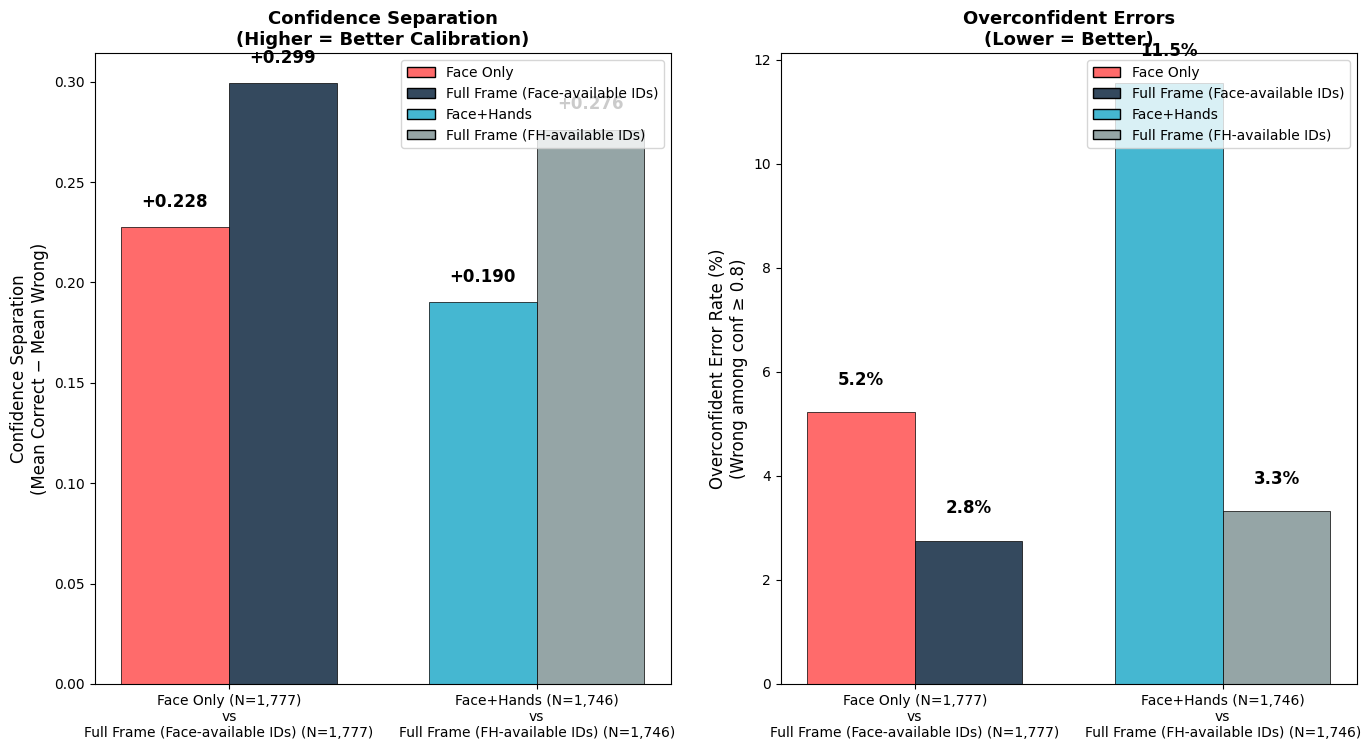


💾 Figure A saved to: /content/drive/MyDrive/TFM/outputs/metrics/confidence_roi_vs_control.png


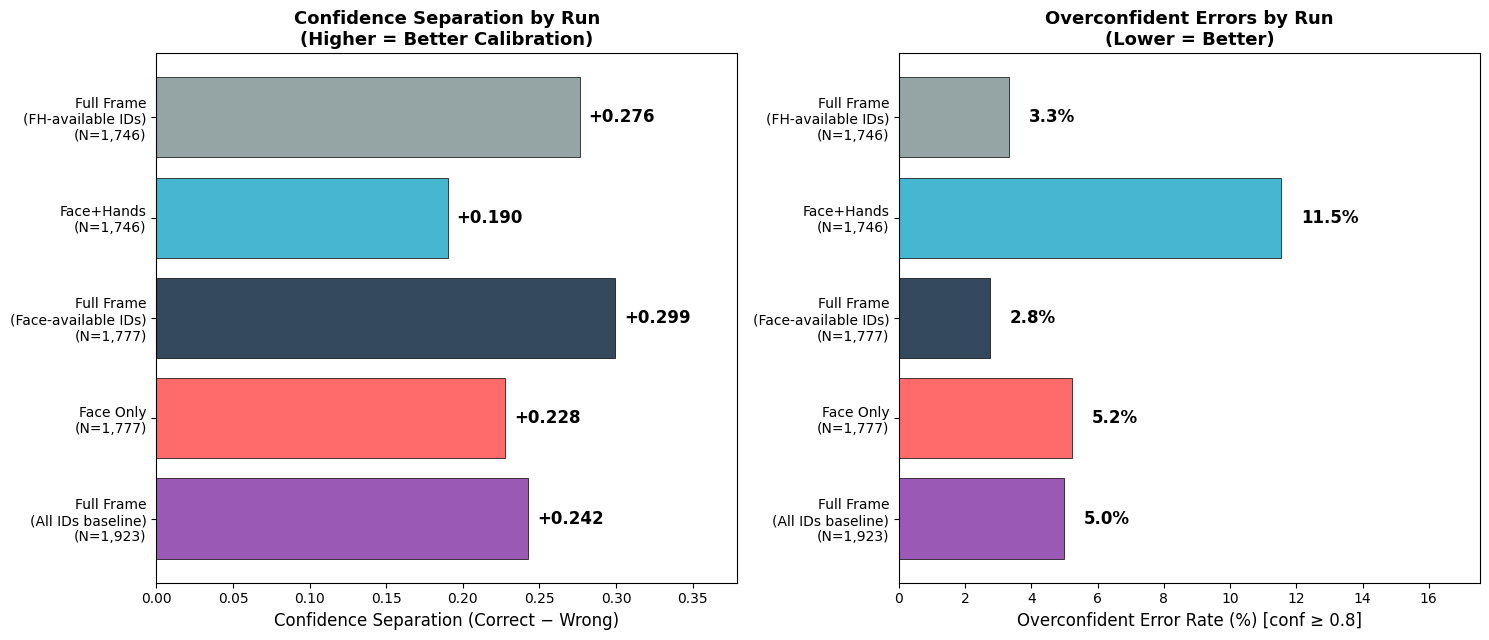

💾 Figure B saved to: /content/drive/MyDrive/TFM/outputs/metrics/confidence_all_runs_overview.png

🎯 ROI EFFECT ON CALIBRATION (Same IDs, Different Input)

📊 Face Only vs Full Frame (Face-available IDs):
   Conf Separation:  0.228 vs 0.299  Δ=-0.071
   Overconf:         5.2% vs 2.8%  Δ=+2.5pp
   ➡️ ROI HURTS calibration (worse separation)

📊 Face+Hands vs Full Frame (FH-available IDs):
   Conf Separation:  0.190 vs 0.276  Δ=-0.086
   Overconf:         11.5% vs 3.3%  Δ=+8.2pp
   ➡️ ROI HURTS calibration (worse separation)

💾 CSV saved to: /content/drive/MyDrive/TFM/outputs/metrics/confidence_calibration_5run.csv

📖 INTERPRETATION GUIDE

Confidence Calibration Metrics:
• Mean Conf (Correct): Higher is better — model is confident when right
• Mean Conf (Wrong): Lower is better — model is uncertain when wrong
• Confidence Separation: Larger positive (Correct − Wrong) = better calibration (knows what it knows)
• Overconfident Error Rate: Lower is better — fewer "confidently wrong" prediction

In [9]:
# ============================================================================
# 📊 Section 7.5: Confidence Calibration Analysis (5-Run)
# ============================================================================
# Compares confidence behavior across all 5 runs, with focus on:
# - ROI vs matched full-frame control (same IDs, different input)
# - Overall calibration quality (separation, overconfident error rate)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================================
# CONFIGURATION
# ============================================================================
HIGH_CONF_THRESHOLD = 0.8  # For overconfident error rate

# Fixed sample sizes for labeling (as requested)
FIXED_N = {
    "Full Frame (All IDs baseline)": 1923,
    "Face Only": 1777,
    "Face+Hands": 1746,
    "Full Frame (Face-available IDs)": 1777,   # ✅ changed
    "Full Frame (FH-available IDs)": 1746,
}


# ============================================================================
# Define the 5-run structure with prediction paths
# (Uses the paths defined earlier in Section 2)
# ============================================================================
RUN_CONFIG = {
    "Full Frame (All IDs baseline)": {
        "pred_path": FULL_FRAME_PREDS,
        "group": "baseline",
        "color": "#9B59B6",
    },
    "Face Only": {
        "pred_path": FACE_ONLY_PREDS,
        "group": "roi",
        "matched_control": "Full Frame (Face-available IDs)",  # ✅ changed
        "color": "#FF6B6B",
    },
    "Face+Hands": {
        "pred_path": FACE_HANDS_PREDS,
        "group": "roi",
        "matched_control": "Full Frame (FH-available IDs)",
        "color": "#45B7D1",
    },

    # ✅ Control runs (full-frame on matched-ID subsets)
    "Full Frame (Face-available IDs)": {                      # ✅ renamed (was Face ROI crops...)
        "pred_path": CONTROL_FACESUBSET_PREDS,
        "group": "control",
        "color": "#34495E",  # dark blue
    },
    "Full Frame (FH-available IDs)": {
        "pred_path": CONTROL_FHSUBSET_PREDS,
        "group": "control",
        "color": "#95A5A6",  # grey
    },
}


# ============================================================================
# HELPER: Extract true label from path
# ============================================================================
def extract_true_class(path_str):
    for part in reversed(Path(path_str).parts):
        if part.startswith("c") and len(part) == 2 and part[1].isdigit():
            return int(part[1])
    return -1

def parse_pred(x):
    if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
        return int(x[1])
    return int(x)

# ============================================================================
# LOAD AND COMPUTE CONFIDENCE METRICS FOR ALL RUNS
# ============================================================================
print("📊 Computing confidence metrics for all 5 runs...\n")

conf_results = []

for run_name, run_info in RUN_CONFIG.items():
    pred_path = run_info["pred_path"]

    if pred_path is None or not pred_path.exists():
        print(f"⚠️  Skipping {run_name}: prediction file not found")
        continue

    # Load predictions
    df = pd.read_csv(pred_path)
    df["true"] = df["path"].apply(extract_true_class)
    df["pred"] = df["pred_class_id"].apply(parse_pred)
    df = df[df["true"] >= 0].copy()

    # Handle missing confidence column
    if "confidence" not in df.columns:
        print(f"⚠️  {run_name}: No confidence column, using softmax approximation")
        df["confidence"] = 1.0

    df["correct"] = df["pred"] == df["true"]

    # Compute metrics
    correct_df = df[df["correct"]]
    wrong_df = df[~df["correct"]]

    mean_conf_correct = correct_df["confidence"].mean() if len(correct_df) > 0 else np.nan
    mean_conf_wrong = wrong_df["confidence"].mean() if len(wrong_df) > 0 else np.nan
    conf_gap = mean_conf_correct - mean_conf_wrong if not np.isnan(mean_conf_wrong) else np.nan

    # Overconfident error rate
    high_conf_df = df[df["confidence"] >= HIGH_CONF_THRESHOLD]
    n_high_conf = len(high_conf_df)
    n_high_conf_wrong = len(high_conf_df[~high_conf_df["correct"]])
    overconf_error_rate = (n_high_conf_wrong / n_high_conf * 100) if n_high_conf > 0 else np.nan

    accuracy = len(correct_df) / len(df) * 100

    conf_results.append({
        "Run": run_name,
        "Group": run_info["group"],
        "N": len(df),
        "Accuracy (%)": accuracy,
        "Mean Conf (Correct)": mean_conf_correct,
        "Mean Conf (Wrong)": mean_conf_wrong,
        "Conf Gap": conf_gap,
        f"High-Conf (≥{HIGH_CONF_THRESHOLD})": n_high_conf,
        "Overconf Errors": n_high_conf_wrong,
        "Overconf Error Rate (%)": overconf_error_rate,
        "Color": run_info["color"],
        "Matched Control": run_info.get("matched_control"),
    })

    status_icon = "✅" if accuracy > 70 else "⚠️"
    print(f"{status_icon} {run_name}: {len(df)} samples, {accuracy:.1f}% acc, "
          f"sep={conf_gap:.3f}, overconf errors={n_high_conf_wrong}/{n_high_conf}")

conf_df = pd.DataFrame(conf_results)

# ============================================================================
# DISPLAY SUMMARY TABLE
# ============================================================================
print("\n" + "=" * 100)
print("📋 CONFIDENCE CALIBRATION SUMMARY (5-Run)")
print("=" * 100)

display_cols = ["Run", "N", "Accuracy (%)", "Mean Conf (Correct)", "Mean Conf (Wrong)",
                "Conf Gap", "Overconf Error Rate (%)"]
display_df = conf_df[display_cols].copy()

# Format for display
display_df["Accuracy (%)"] = display_df["Accuracy (%)"].apply(lambda x: f"{x:.1f}")
display_df["Mean Conf (Correct)"] = display_df["Mean Conf (Correct)"].apply(lambda x: f"{x:.3f}" if not np.isnan(x) else "—")
display_df["Mean Conf (Wrong)"] = display_df["Mean Conf (Wrong)"].apply(lambda x: f"{x:.3f}" if not np.isnan(x) else "—")
display_df["Conf Gap"] = display_df["Conf Gap"].apply(lambda x: f"+{x:.3f}" if not np.isnan(x) else "—")
display_df["Overconf Error Rate (%)"] = display_df["Overconf Error Rate (%)"].apply(lambda x: f"{x:.1f}" if not np.isnan(x) else "—")

print(display_df.to_string(index=False))
print("=" * 100)

# ============================================================================
# FIGURE A: PAIRED ROI vs CONTROL COMPARISON
# ============================================================================
# Key figure: shows whether ROI cropping improves calibration on the SAME images

from matplotlib.patches import Patch

roi_runs = conf_df[conf_df["Matched Control"].notna()].copy()

if len(roi_runs) > 0:
    # ✅ Slightly taller to fit the bigger legend
    fig, axes = plt.subplots(1, 2, figsize=(14, 7.6))

    pairs = []
    for _, roi_row in roi_runs.iterrows():
        ctrl_name = roi_row["Matched Control"]
        ctrl_row = conf_df[conf_df["Run"] == ctrl_name]
        if len(ctrl_row) > 0:
            pairs.append({
                "ROI": roi_row["Run"],
                "Control": ctrl_name,
                "ROI_Gap": roi_row["Conf Gap"],
                "Ctrl_Gap": ctrl_row.iloc[0]["Conf Gap"],
                "ROI_Overconf": roi_row["Overconf Error Rate (%)"],
                "Ctrl_Overconf": ctrl_row.iloc[0]["Overconf Error Rate (%)"],
                "ROI_Color": roi_row["Color"],
                "Ctrl_Color": ctrl_row.iloc[0]["Color"],
            })

    if pairs:
        x = np.arange(len(pairs))
        width = 0.35

        def label_with_n(name):
            n = FIXED_N.get(name, None)
            return f"{name} (N={n:,})" if n is not None else name

        # -------------------------
        # Plot 1: Confidence Separation
        # -------------------------
        ax1 = axes[0]
        roi_gaps = [p["ROI_Gap"] for p in pairs]
        ctrl_gaps = [p["Ctrl_Gap"] for p in pairs]
        roi_colors = [p["ROI_Color"] for p in pairs]
        ctrl_colors = [p["Ctrl_Color"] for p in pairs]

        bars1 = ax1.bar(x - width/2, roi_gaps, width,
                        color=roi_colors, edgecolor="black", linewidth=0.5)
        bars2 = ax1.bar(x + width/2, ctrl_gaps, width,
                        color=ctrl_colors, edgecolor="black", linewidth=0.5)

        ax1.set_ylabel("Confidence Separation\n(Mean Correct − Mean Wrong)", fontsize=12)
        ax1.set_title("Confidence Separation\n(Higher = Better Calibration)", fontsize=13, fontweight="bold")

        ax1.set_xticks(x)
        ax1.set_xticklabels([
            f"{label_with_n(p['ROI'])}\nvs\n{label_with_n(p['Control'])}" for p in pairs
        ])

        ax1.axhline(y=0, color="black", linestyle="-", linewidth=0.5)

        # Labels above bars (bigger, bold)
        for bar, val in zip(bars1, roi_gaps):
            if not np.isnan(val):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
                         f"+{val:.3f}", ha="center", va="bottom", fontsize=12, fontweight="bold")
        for bar, val in zip(bars2, ctrl_gaps):
            if not np.isnan(val):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
                         f"+{val:.3f}", ha="center", va="bottom", fontsize=12, fontweight="bold")

        # -------------------------
        # Plot 2: Overconfident Errors
        # -------------------------
        ax2 = axes[1]
        roi_overconf = [p["ROI_Overconf"] for p in pairs]
        ctrl_overconf = [p["Ctrl_Overconf"] for p in pairs]

        bars3 = ax2.bar(x - width/2, roi_overconf, width,
                        color=roi_colors, edgecolor="black", linewidth=0.5)
        bars4 = ax2.bar(x + width/2, ctrl_overconf, width,
                        color=ctrl_colors, edgecolor="black", linewidth=0.5)

        ax2.set_ylabel(f"Overconfident Error Rate (%)\n(Wrong among conf ≥ {HIGH_CONF_THRESHOLD})", fontsize=12)
        ax2.set_title("Overconfident Errors\n(Lower = Better)", fontsize=13, fontweight="bold")

        ax2.set_xticks(x)
        ax2.set_xticklabels([
            f"{label_with_n(p['ROI'])}\nvs\n{label_with_n(p['Control'])}" for p in pairs
        ])

        for bar, val in zip(bars3, roi_overconf):
            if not np.isnan(val):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.45,
                         f"{val:.1f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")
        for bar, val in zip(bars4, ctrl_overconf):
            if not np.isnan(val):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.45,
                         f"{val:.1f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

        # -------------------------
        # ✅ Custom 4-item legend (same for both subplots)
        # -------------------------
        legend_handles = [
            Patch(facecolor=RUN_CONFIG["Face Only"]["color"], edgecolor="black", label="Face Only"),
            Patch(facecolor=RUN_CONFIG["Full Frame (Face-available IDs)"]["color"], edgecolor="black",
                  label="Full Frame (Face-available IDs)"),
            Patch(facecolor=RUN_CONFIG["Face+Hands"]["color"], edgecolor="black", label="Face+Hands"),
            Patch(facecolor=RUN_CONFIG["Full Frame (FH-available IDs)"]["color"], edgecolor="black",
                  label="Full Frame (FH-available IDs)"),
        ]

        ax1.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True)
        ax2.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True)

        plt.tight_layout()

        out_path = Path(OUT_ROOT) / "metrics" / "confidence_roi_vs_control.png"
        out_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
        plt.show()
        print(f"\n💾 Figure A saved to: {out_path}")
else:
    print("\n⚠️ No ROI vs Control pairs available for Figure A")


import re
import textwrap

def run_label_three_lines(run_name, wrap_width=26):
    """
    Creates y-axis labels that look like:
      Full Frame
      (FH-available IDs)
      (N=1,746)

    If there's no parenthetical descriptor in run_name, it becomes:
      Face+Hands
      (N=1,746)
    """
    n = FIXED_N.get(run_name, None)

    # 1) Split off ONE trailing parenthetical group if it exists
    #    e.g. "Full Frame (FH-available IDs)" -> base="Full Frame", desc="(FH-available IDs)"
    m = re.match(r"^(.*?)(\s*\([^)]*\))$", run_name.strip())
    if m:
        base = m.group(1).strip()
        desc = m.group(2).strip()
    else:
        base = run_name.strip()
        desc = None

    # 2) Wrap the base name (optional, but helps if base ever gets long)
    base_wrapped = textwrap.fill(base, width=wrap_width, break_long_words=False)

    # 3) Assemble lines
    lines = [base_wrapped]
    if desc is not None:
        lines.append(desc)

    if n is not None:
        lines.append(f"(N={n:,})")

    return "\n".join(lines)



# ============================================================================
# FIGURE B: ALL 5 RUNS COMPARISON (HORIZONTAL)
# ============================================================================
# Reordered (per your requested order) and widened, with bigger/bold labels and padding.

# Requested order (translated to the new run names)
run_order = [
    "Full Frame (All IDs baseline)",
    "Face Only",
    "Full Frame (Face-available IDs)",   # ✅ FIX: was "Face ROI crops (Face-available IDs)"
    "Face+Hands",
    "Full Frame (FH-available IDs)",
]


plot_df = (
    conf_df.set_index("Run")
    .reindex([r for r in run_order if r in conf_df["Run"].values])
    .reset_index()
)

# Build ytick labels with fixed N next to each run label
def run_label_with_n(run_name):
    n = FIXED_N.get(run_name, None)
    return f"{run_name} (N={n:,})" if n is not None else run_name

y_labels = [run_label_three_lines(r) for r in plot_df["Run"].tolist()]

y_pos = np.arange(len(plot_df))
colors = plot_df["Color"].tolist()

# Made figure wider (per your request)
fig, axes = plt.subplots(1, 2, figsize=(15, 6.5))

# --- Left: Confidence Separation (horizontal bars) ---
ax1 = axes[0]
gaps = plot_df["Conf Gap"].values
bars1 = ax1.barh(y_pos, gaps, color=colors, edgecolor="black", linewidth=0.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(y_labels)
ax1.set_xlabel("Confidence Separation (Correct − Wrong)", fontsize=12)
ax1.set_title("Confidence Separation by Run\n(Higher = Better Calibration)", fontsize=13, fontweight="bold")
ax1.axvline(x=0, color="black", linestyle="-", linewidth=0.5)

# Add padding so the bold numbers don't get clipped
finite_gaps = gaps[np.isfinite(gaps)]
if len(finite_gaps) > 0:
    max_gap = float(np.max(finite_gaps))
    ax1.set_xlim(right=max_gap + 0.08)

for bar, val in zip(bars1, gaps):
    if not np.isnan(val):
        ax1.text(
            val + 0.006,
            bar.get_y() + bar.get_height()/2,
            f"+{val:.3f}",
            ha="left",
            va="center",
            fontsize=12,         # larger
            fontweight="bold",   # bold
            clip_on=False        # avoid clipping at axes boundary
        )

# --- Right: Overconfident Error Rate (horizontal bars) ---
ax2 = axes[1]
overconf = plot_df["Overconf Error Rate (%)"].values
bars2 = ax2.barh(y_pos, overconf, color=colors, edgecolor="black", linewidth=0.5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(y_labels)
ax2.set_xlabel(f"Overconfident Error Rate (%) [conf ≥ {HIGH_CONF_THRESHOLD}]", fontsize=12)
ax2.set_title("Overconfident Errors by Run\n(Lower = Better)", fontsize=13, fontweight="bold")

finite_over = overconf[np.isfinite(overconf)]
if len(finite_over) > 0:
    max_over = float(np.max(finite_over))
    ax2.set_xlim(right=max_over + 6.0)

for bar, val in zip(bars2, overconf):
    if not np.isnan(val):
        ax2.text(
            val + 0.6,
            bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%",
            ha="left",
            va="center",
            fontsize=12,         # larger
            fontweight="bold",   # bold
            clip_on=False        # avoid clipping at axes boundary
        )

plt.tight_layout()

out_path = Path(OUT_ROOT) / "metrics" / "confidence_all_runs_overview.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Figure B saved to: {out_path}")

# ============================================================================
# ROI EFFECT ON CALIBRATION (DELTA TABLE)
# ============================================================================
print("\n" + "=" * 80)
print("🎯 ROI EFFECT ON CALIBRATION (Same IDs, Different Input)")
print("=" * 80)

for _, roi_row in roi_runs.iterrows():
    ctrl_name = roi_row["Matched Control"]
    ctrl_row = conf_df[conf_df["Run"] == ctrl_name]
    if len(ctrl_row) > 0:
        ctrl = ctrl_row.iloc[0]
        delta_gap = roi_row["Conf Gap"] - ctrl["Conf Gap"]
        delta_overconf = roi_row["Overconf Error Rate (%)"] - ctrl["Overconf Error Rate (%)"]

        print(f"\n📊 {roi_row['Run']} vs {ctrl_name}:")
        print(f"   Conf Separation:  {roi_row['Conf Gap']:.3f} vs {ctrl['Conf Gap']:.3f}  Δ={delta_gap:+.3f}")
        print(f"   Overconf:         {roi_row['Overconf Error Rate (%)']:.1f}% vs {ctrl['Overconf Error Rate (%)']:.1f}%  Δ={delta_overconf:+.1f}pp")

        if delta_gap > 0.01:
            print("   ➡️ ROI IMPROVES calibration (better separation)")
        elif delta_gap < -0.01:
            print("   ➡️ ROI HURTS calibration (worse separation)")
        else:
            print("   ➡️ No significant difference in calibration")

# ============================================================================
# SAVE CSV
# ============================================================================
out_csv = Path(OUT_ROOT) / "metrics" / "confidence_calibration_5run.csv"
conf_df.drop(columns=["Color", "Matched Control"], errors="ignore").to_csv(out_csv, index=False)
print(f"\n💾 CSV saved to: {out_csv}")

# ============================================================================
# INTERPRETATION
# ============================================================================
print("\n" + "=" * 80)
print("📖 INTERPRETATION GUIDE")
print("=" * 80)
print(f"""
Confidence Calibration Metrics:
• Mean Conf (Correct): Higher is better — model is confident when right
• Mean Conf (Wrong): Lower is better — model is uncertain when wrong
• Confidence Separation: Larger positive (Correct − Wrong) = better calibration (knows what it knows)
• Overconfident Error Rate: Lower is better — fewer "confidently wrong" predictions

Key 5-Run Comparisons:
• Face+Hands vs Full Frame (FH-available IDs): Same IDs, different representation
  → Positive Δ Separation = ROI extraction improves confidence calibration

• Face Only vs Face ROI crops (Face-available IDs): Same IDs, different representation
  → Tests if face-only provides better uncertainty estimation

A well-calibrated model should have:
  ✓ High confidence on correct predictions
  ✓ Low confidence on wrong predictions
  ✓ Large confidence separation
  ✓ Low overconfident error rate
""")


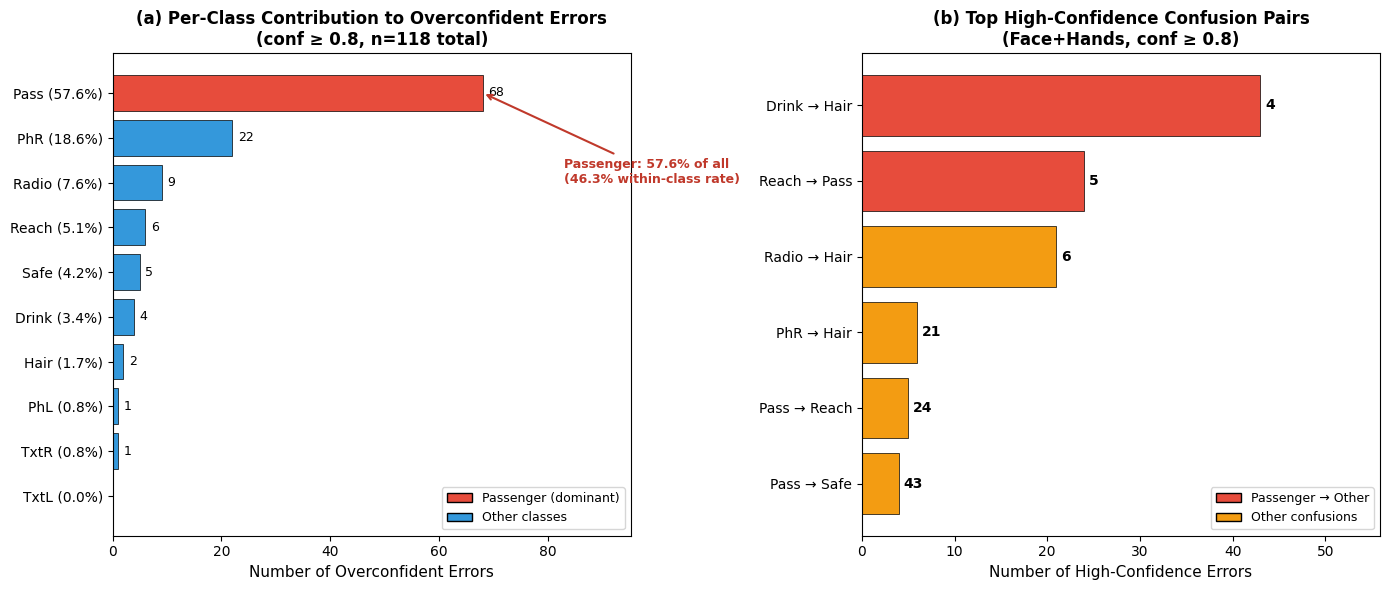

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/overconf_breakdown_facehands.png

📝 THESIS-READY SUMMARY

FACE+HANDS OVERCONFIDENT ERROR BREAKDOWN:

Total high-confidence predictions: 1022
Total overconfident errors: 118 (11.5%)

TOP CONTRIBUTING CLASSES:

  • Passenger: 68 errors (57.6% of total)
    Within-class overconf rate: 46.3%
  • Phone (R): 22 errors (18.6% of total)
    Within-class overconf rate: 22.2%
  • Radio: 9 errors (7.6% of total)
    Within-class overconf rate: 16.7%

TOP HIGH-CONFIDENCE CONFUSION PAIRS:

  1. Passenger → Safe Driving: 43 errors
  2. Passenger → Reaching: 24 errors
  3. Phone (R) → Hair/Makeup: 21 errors
  4. Radio → Hair/Makeup: 6 errors

KEY FINDING:
Passenger alone contributes 68 of 118 overconfident errors
(57.6%), with 46.3% of high-confidence
Passenger predictions being incorrect. The dominant pathways are:
  • Passenger → Safe Driving (43)
  • Passenger → Reaching (24)


📋 COMPACT TABLE (for appendix)
Class  Name  High-Conf  Overconf Err R

/tmp/ipython-input-48116222.py:214: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  • Passenger → Safe Driving ({top_confusions[top_confusions['true']==9][top_confusions['pred']==0]['count'].values[0] if len(top_confusions[(top_confusions['true']==9) & (top_confusions['pred']==0)]) > 0 else 'N/A'})
/tmp/ipython-input-48116222.py:215: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  • Passenger → Reaching ({top_confusions[top_confusions['true']==9][top_confusions['pred']==7]['count'].values[0] if len(top_confusions[(top_confusions['true']==9) & (top_confusions['pred']==7)]) > 0 else 'N/A'})



💾 Table saved: /content/drive/MyDrive/TFM/outputs/metrics/overconf_perclass_table.csv


In [ ]:
# ============================================================================
# 📊 Face+Hands Overconfident Error Breakdown (Thesis Figure)
# ============================================================================
# Visualizes:
# 1. Per-class contribution to overconfident errors (Passenger dominates)
# 2. Top high-confidence confusion pairs (specific pathways)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# ============================================================================
# CONFIGURATION
# ============================================================================
HIGH_CONF_THRESHOLD = 0.8
FACE_HANDS_PREDS = Path(OUT_ROOT) / "preds/test/effb0_face_hands_1_11_test.csv"

CLASS_NAMES = {
    0: "Safe Driving", 1: "Texting (R)", 2: "Phone (R)", 3: "Texting (L)",
    4: "Phone (L)", 5: "Radio", 6: "Drinking", 7: "Reaching",
    8: "Hair/Makeup", 9: "Passenger",
}

CLASS_NAMES_SHORT = {
    0: "Safe", 1: "TxtR", 2: "PhR", 3: "TxtL", 4: "PhL",
    5: "Radio", 6: "Drink", 7: "Reach", 8: "Hair", 9: "Pass",
}

# ============================================================================
# LOAD AND PROCESS DATA
# ============================================================================
def extract_true_class(path_str):
    for part in reversed(Path(path_str).parts):
        if part.startswith("c") and len(part) == 2 and part[1].isdigit():
            return int(part[1])
    return -1

def parse_pred(x):
    if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
        return int(x[1])
    return int(x)

df = pd.read_csv(FACE_HANDS_PREDS)
df["true"] = df["path"].apply(extract_true_class)
df["pred"] = df["pred_class_id"].apply(parse_pred)
df = df[df["true"] >= 0].copy()
df["correct"] = df["pred"] == df["true"]
df["high_conf"] = df["confidence"] >= HIGH_CONF_THRESHOLD
df["overconf_error"] = (~df["correct"]) & df["high_conf"]

# ============================================================================
# COMPUTE PER-CLASS STATS
# ============================================================================
total_overconf = df["overconf_error"].sum()
total_high_conf = df["high_conf"].sum()

class_stats = []
for c in range(10):
    class_df = df[df["true"] == c]
    n_overconf = class_df["overconf_error"].sum()
    n_high_conf = class_df["high_conf"].sum()

    class_stats.append({
        "class_id": c,
        "name": CLASS_NAMES[c],
        "short": CLASS_NAMES_SHORT[c],
        "n_overconf": n_overconf,
        "contribution": n_overconf / total_overconf * 100 if total_overconf > 0 else 0,
        "within_class_rate": n_overconf / n_high_conf * 100 if n_high_conf > 0 else 0,
        "n_high_conf": n_high_conf,
    })

class_df_stats = pd.DataFrame(class_stats).sort_values("n_overconf", ascending=True)

# ============================================================================
# COMPUTE TOP CONFUSION PAIRS
# ============================================================================
overconf_df = df[df["overconf_error"]]
confusion_counts = overconf_df.groupby(["true", "pred"]).size().reset_index(name="count")
confusion_counts = confusion_counts.sort_values("count", ascending=False)
top_confusions = confusion_counts.head(6)  # Top 6 pairs

# ============================================================================
# FIGURE: COMBINED VISUALIZATION
# ============================================================================
fig = plt.figure(figsize=(14, 6))

# --- Panel A: Per-Class Contribution (Horizontal Bar) ---
ax1 = fig.add_subplot(1, 2, 1)

y_pos = np.arange(len(class_df_stats))
bars = ax1.barh(y_pos, class_df_stats["n_overconf"],
                color=["#E74C3C" if c == 9 else "#3498DB" for c in class_df_stats["class_id"]],
                edgecolor="black", linewidth=0.5)

ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{row['short']} ({row['contribution']:.1f}%)"
                     for _, row in class_df_stats.iterrows()], fontsize=10)
ax1.set_xlabel("Number of Overconfident Errors", fontsize=11)
ax1.set_title(f"(a) Per-Class Contribution to Overconfident Errors\n(conf ≥ {HIGH_CONF_THRESHOLD}, n={total_overconf} total)",
              fontsize=12, fontweight="bold")

# Add count labels
for bar, (_, row) in zip(bars, class_df_stats.iterrows()):
    if row["n_overconf"] > 0:
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f"{int(row['n_overconf'])}", va="center", fontsize=9)

# Highlight Passenger
passenger_row = class_df_stats[class_df_stats["class_id"] == 9].iloc[0]
ax1.annotate(f"Passenger: {passenger_row['contribution']:.1f}% of all\n"
             f"({passenger_row['within_class_rate']:.1f}% within-class rate)",
             xy=(passenger_row["n_overconf"], 9), xytext=(passenger_row["n_overconf"] + 15, 7),
             fontsize=9, fontweight="bold", color="#C0392B",
             arrowprops=dict(arrowstyle="->", color="#C0392B", lw=1.5))

ax1.set_xlim(0, max(class_df_stats["n_overconf"]) * 1.4)

# Legend
legend_elements = [
    mpatches.Patch(facecolor="#E74C3C", edgecolor="black", label="Passenger (dominant)"),
    mpatches.Patch(facecolor="#3498DB", edgecolor="black", label="Other classes"),
]
ax1.legend(handles=legend_elements, loc="lower right", fontsize=9)

# --- Panel B: Top Confusion Pairs (Horizontal Bar with Labels) ---
ax2 = fig.add_subplot(1, 2, 2)

# Format confusion pair labels
pair_labels = []
pair_counts = []
pair_colors = []

for _, row in top_confusions.iterrows():
    true_name = CLASS_NAMES_SHORT[row["true"]]
    pred_name = CLASS_NAMES_SHORT[row["pred"]]
    pair_labels.append(f"{true_name} → {pred_name}")
    pair_counts.append(row["count"])
    # Color by whether Passenger is involved
    if row["true"] == 9:
        pair_colors.append("#E74C3C")  # Passenger-origin = red
    else:
        pair_colors.append("#F39C12")  # Other = orange

y_pos2 = np.arange(len(top_confusions))[::-1]  # Reverse for top-to-bottom

bars2 = ax2.barh(y_pos2, pair_counts, color=pair_colors, edgecolor="black", linewidth=0.5)

ax2.set_yticks(y_pos2)
ax2.set_yticklabels(pair_labels[::-1], fontsize=10)
ax2.set_xlabel("Number of High-Confidence Errors", fontsize=11)
ax2.set_title(f"(b) Top High-Confidence Confusion Pairs\n(Face+Hands, conf ≥ {HIGH_CONF_THRESHOLD})",
              fontsize=12, fontweight="bold")

# Add count labels
for bar, count in zip(bars2, pair_counts[::-1]):
    ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f"{int(count)}", va="center", fontsize=10, fontweight="bold")

ax2.set_xlim(0, max(pair_counts) * 1.3)

# Legend
legend_elements2 = [
    mpatches.Patch(facecolor="#E74C3C", edgecolor="black", label="Passenger → Other"),
    mpatches.Patch(facecolor="#F39C12", edgecolor="black", label="Other confusions"),
]
ax2.legend(handles=legend_elements2, loc="lower right", fontsize=9)

plt.tight_layout()

# Save
out_path = Path(OUT_ROOT) / "metrics" / "overconf_breakdown_facehands.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# PRINT SUMMARY FOR THESIS TEXT
# ============================================================================
print("\n" + "=" * 80)
print("📝 THESIS-READY SUMMARY")
print("=" * 80)

print(f"""
FACE+HANDS OVERCONFIDENT ERROR BREAKDOWN:

Total high-confidence predictions: {total_high_conf}
Total overconfident errors: {total_overconf} ({total_overconf/total_high_conf*100:.1f}%)

TOP CONTRIBUTING CLASSES:
""")

for _, row in class_df_stats.sort_values("n_overconf", ascending=False).head(3).iterrows():
    print(f"  • {row['name']}: {int(row['n_overconf'])} errors ({row['contribution']:.1f}% of total)")
    print(f"    Within-class overconf rate: {row['within_class_rate']:.1f}%")

print(f"""
TOP HIGH-CONFIDENCE CONFUSION PAIRS:
""")

for i, (_, row) in enumerate(top_confusions.head(4).iterrows(), 1):
    true_name = CLASS_NAMES[row["true"]]
    pred_name = CLASS_NAMES[row["pred"]]
    print(f"  {i}. {true_name} → {pred_name}: {int(row['count'])} errors")

print(f"""
KEY FINDING:
Passenger alone contributes {passenger_row['n_overconf']:.0f} of {total_overconf} overconfident errors
({passenger_row['contribution']:.1f}%), with {passenger_row['within_class_rate']:.1f}% of high-confidence
Passenger predictions being incorrect. The dominant pathways are:
  • Passenger → Safe Driving ({top_confusions[top_confusions['true']==9][top_confusions['pred']==0]['count'].values[0] if len(top_confusions[(top_confusions['true']==9) & (top_confusions['pred']==0)]) > 0 else 'N/A'})
  • Passenger → Reaching ({top_confusions[top_confusions['true']==9][top_confusions['pred']==7]['count'].values[0] if len(top_confusions[(top_confusions['true']==9) & (top_confusions['pred']==7)]) > 0 else 'N/A'})
""")

# ============================================================================
# OPTIONAL: COMPACT TABLE FOR APPENDIX
# ============================================================================
print("\n" + "=" * 80)
print("📋 COMPACT TABLE (for appendix)")
print("=" * 80)

table_data = []
for _, row in class_df_stats.sort_values("class_id").iterrows():
    table_data.append({
        "Class": f"c{row['class_id']}",
        "Name": row["short"],
        "High-Conf": int(row["n_high_conf"]),
        "Overconf Err": int(row["n_overconf"]),
        "Rate (%)": f"{row['within_class_rate']:.1f}",
        "Contrib (%)": f"{row['contribution']:.1f}",
    })

table_df = pd.DataFrame(table_data)
print(table_df.to_string(index=False))

# Save table
table_csv = Path(OUT_ROOT) / "metrics" / "overconf_perclass_table.csv"
table_df.to_csv(table_csv, index=False)
print(f"\n💾 Table saved: {table_csv}")

📦 Loading predictions...
   ✅ Full Frame: 1923 samples, 75.9% accuracy
   ✅ Face Only: 1777 samples, 52.2% accuracy
   ✅ Face+Hands: 1746 samples, 76.0% accuracy
   ✅ Ctrl-FaceSub: 1777 samples, 71.6% accuracy
   ✅ Ctrl-FHSub: 1746 samples, 73.7% accuracy

📊 RISK-COVERAGE ANALYSIS (Threshold-Free Reliability)

📋 RELIABILITY METRICS (AURC = Area Under Risk-Coverage Curve, lower = better)
----------------------------------------------------------------------------------------------------
       Model    N Accuracy (%)   AURC Random AURC NAURC Cov@5%Risk Cov@10%Risk
  Full Frame 1923         75.9 0.0859      0.2408 0.357      43.2%       60.3%
   Face Only 1777         52.2 0.2399      0.4783 0.501      23.6%       31.3%
  Face+Hands 1746         76.0 0.1078      0.2400 0.449      21.1%       52.8%
Ctrl-FaceSub 1777         71.6 0.0887      0.2842 0.312      44.2%       64.7%
  Ctrl-FHSub 1746         73.7 0.0941      0.2629 0.358      39.2%       59.7%


/tmp/ipython-input-187038456.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(risk, coverage)
/tmp/ipython-input-187038456.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(risk, coverage)
/tmp/ipython-input-187038456.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(risk, coverage)
/tmp/ipython-input-187038456.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(risk, coverage)
/tmp/ipython-input-187038456.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.

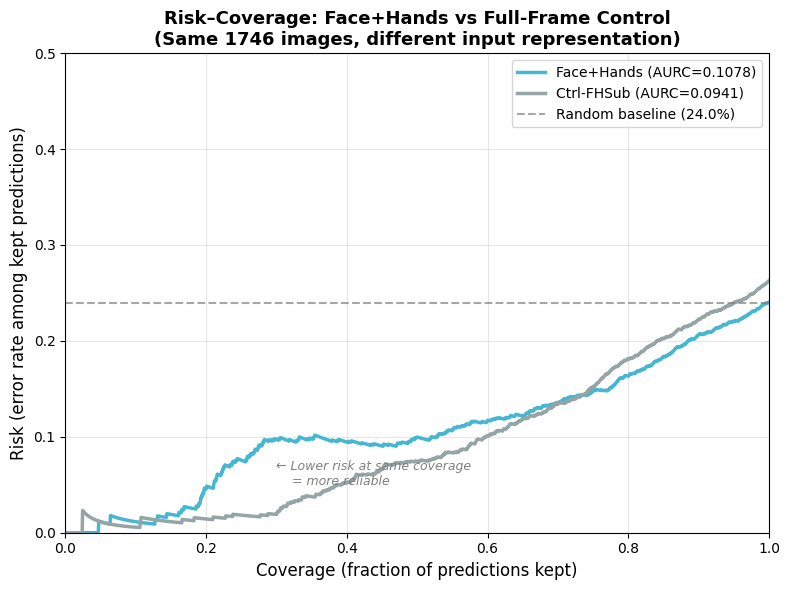


💾 Saved (main text): /content/drive/MyDrive/TFM/outputs/metrics/risk_coverage_main_comparison.png


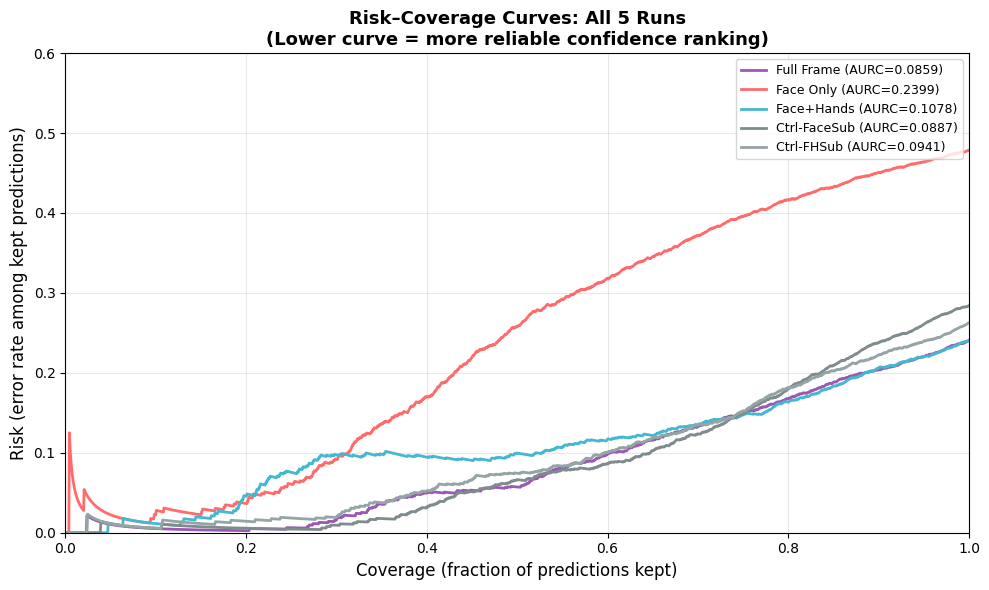

💾 Saved (appendix): /content/drive/MyDrive/TFM/outputs/metrics/risk_coverage_all_runs.png

📊 PASSENGER-ONLY RISK-COVERAGE (Class c9)
   Full Frame: 218 samples, 67.9% acc, AURC=0.0755
   Face Only: 218 samples, 94.0% acc, AURC=0.0066
   Face+Hands: 214 samples, 43.5% acc, AURC=0.3345
   Ctrl-FaceSub: 218 samples, 39.9% acc, AURC=0.2681
   Ctrl-FHSub: 214 samples, 44.4% acc, AURC=0.2438


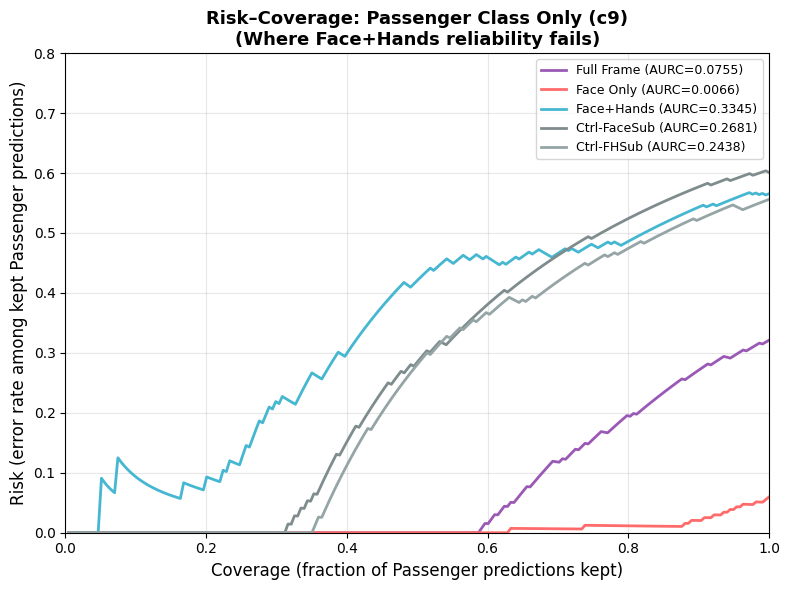

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/risk_coverage_passenger_only.png


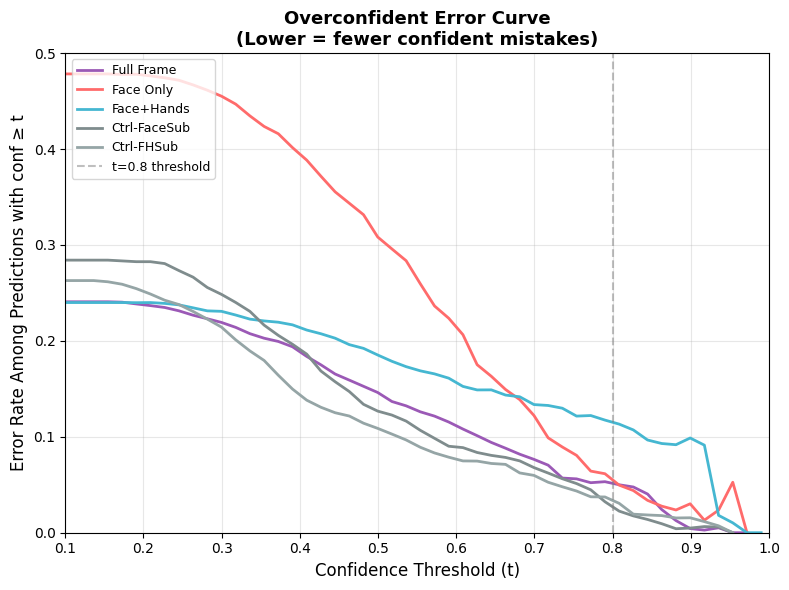

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/overconfident_error_curve.png

📋 THESIS SUMMARY TABLE: Model Reliability Metrics
       Model    N  Accuracy (%)     AURC  Cov@5%Risk  Passenger AURC
  Full Frame 1923     75.923037 0.085947    0.431617        0.075513
   Face Only 1777     52.166573 0.239869    0.236353        0.006630
  Face+Hands 1746     76.002291 0.107751    0.210767        0.334529
Ctrl-FaceSub 1777     71.581317 0.088736    0.442319        0.268132
  Ctrl-FHSub 1746     73.711340 0.094122    0.392325        0.243811

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/reliability_metrics_summary.csv

💡 KEY INTERPRETATION

RISK-COVERAGE ANALYSIS (Threshold-Free):

  AURC (Area Under Risk-Coverage Curve, lower = better reliability):
  - Face+Hands:  0.1078
  - Ctrl-FHSub:  0.0941
  - Difference:  +0.0136 (Face+Hands is worse)

  INTERPRETATION:
  Risk-coverage curves show that Face+Hands maintains higher error rates even when
  keeping only its most confident pre

In [ ]:
# ============================================================================
# 📊 Section 7.5: Model Reliability Analysis (Risk–Coverage)
# ============================================================================
# Threshold-free assessment of prediction reliability using selective prediction.
# Key question: "When the model sounds confident, can I trust it?"
#
# This section replaces/supplements the fixed 0.8 threshold analysis with
# risk-coverage curves that adapt to each model's confidence distribution.
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================================
# CONFIGURATION
# ============================================================================

# Prediction file paths (update to match your naming)
PRED_PATHS = {
    "Full Frame": FULL_FRAME_PREDS,
    "Face Only": FACE_ONLY_PREDS,
    "Face+Hands": FACE_HANDS_PREDS,
    "Ctrl-FaceSub": CONTROL_FACESUBSET_PREDS,
    "Ctrl-FHSub": CONTROL_FHSUBSET_PREDS,
}

# Colors for consistency with other plots
COLORS = {
    "Full Frame": "#9B59B6",
    "Face Only": "#FF6B6B",
    "Face+Hands": "#45B7D1",
    "Ctrl-FaceSub": "#7F8C8D",
    "Ctrl-FHSub": "#95A5A6",
}

CLASS_NAMES = {
    0: "Safe", 1: "TxtR", 2: "PhR", 3: "TxtL", 4: "PhL",
    5: "Radio", 6: "Drink", 7: "Reach", 8: "Hair", 9: "Pass",
}

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def extract_true_class(path_str):
    """Extract true class from path like '/c7/image.jpg'."""
    for part in reversed(Path(path_str).parts):
        if part.startswith("c") and len(part) == 2 and part[1].isdigit():
            return int(part[1])
    return -1

def parse_pred(x):
    """Parse predicted class from 'c7' or int format."""
    if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
        return int(x[1])
    return int(x)

def load_predictions(path):
    """Load and preprocess prediction CSV."""
    if path is None or not Path(path).exists():
        return None
    df = pd.read_csv(path)
    df["true"] = df["path"].apply(extract_true_class)
    df["pred"] = df["pred_class_id"].apply(parse_pred)
    df = df[df["true"] >= 0].copy()
    df["correct"] = df["pred"] == df["true"]
    return df

# ============================================================================
# RISK-COVERAGE FUNCTIONS
# ============================================================================

def risk_coverage_curve(confidence, correct):
    """
    Compute risk-coverage curve.

    Args:
        confidence: (N,) array of confidence scores [0,1]
        correct: (N,) boolean array (True if prediction correct)

    Returns:
        coverage: fraction of samples kept (sorted by confidence desc)
        risk: error rate among kept samples
    """
    confidence = np.asarray(confidence)
    correct = np.asarray(correct).astype(bool)

    # Sort by confidence (highest first)
    order = np.argsort(-confidence)
    correct_sorted = correct[order]

    # Cumulative counts as we include more samples
    n_kept = np.arange(1, len(correct_sorted) + 1)
    cum_errors = np.cumsum(~correct_sorted)

    coverage = n_kept / len(correct_sorted)
    risk = cum_errors / n_kept

    return coverage, risk

def compute_aurc(coverage, risk):
    """Area Under Risk-Coverage Curve (lower is better)."""
    return np.trapz(risk, coverage)

def compute_random_aurc(error_rate):
    """AURC for a random confidence baseline (constant risk = error_rate)."""
    return error_rate  # Integral of constant over [0,1]

def coverage_at_risk(coverage, risk, target_risk=0.05):
    """Find maximum coverage where risk ≤ target_risk."""
    valid = risk <= target_risk
    if not valid.any():
        return 0.0
    return coverage[valid].max()

# ============================================================================
# LOAD ALL PREDICTIONS
# ============================================================================
print("📦 Loading predictions...")
data = {}
for name, path in PRED_PATHS.items():
    df = load_predictions(path)
    if df is not None:
        data[name] = df
        print(f"   ✅ {name}: {len(df)} samples, {df['correct'].mean()*100:.1f}% accuracy")
    else:
        print(f"   ⚠️ {name}: not found")

# ============================================================================
# COMPUTE RISK-COVERAGE FOR ALL RUNS
# ============================================================================
print("\n" + "=" * 80)
print("📊 RISK-COVERAGE ANALYSIS (Threshold-Free Reliability)")
print("=" * 80)

rc_results = []

for name, df in data.items():
    cov, risk = risk_coverage_curve(df["confidence"], df["correct"])
    aurc = compute_aurc(cov, risk)
    random_aurc = compute_random_aurc(1 - df["correct"].mean())  # baseline

    # Normalized AURC (0 = perfect, 1 = random)
    naurc = aurc / random_aurc if random_aurc > 0 else aurc

    # Coverage at 5% risk (practical metric)
    cov_at_5 = coverage_at_risk(cov, risk, target_risk=0.05)
    cov_at_10 = coverage_at_risk(cov, risk, target_risk=0.10)

    rc_results.append({
        "Model": name,
        "N": len(df),
        "Accuracy (%)": df["correct"].mean() * 100,
        "AURC": aurc,
        "Random AURC": random_aurc,
        "NAURC": naurc,
        "Cov@5%Risk": cov_at_5,
        "Cov@10%Risk": cov_at_10,
    })

    # Store curve for plotting
    data[name]["_cov"] = cov
    data[name]["_risk"] = risk

rc_df = pd.DataFrame(rc_results)

# Display table
print("\n📋 RELIABILITY METRICS (AURC = Area Under Risk-Coverage Curve, lower = better)")
print("-" * 100)
display_df = rc_df.copy()
display_df["AURC"] = display_df["AURC"].apply(lambda x: f"{x:.4f}")
display_df["Random AURC"] = display_df["Random AURC"].apply(lambda x: f"{x:.4f}")
display_df["NAURC"] = display_df["NAURC"].apply(lambda x: f"{x:.3f}")
display_df["Cov@5%Risk"] = display_df["Cov@5%Risk"].apply(lambda x: f"{x*100:.1f}%")
display_df["Cov@10%Risk"] = display_df["Cov@10%Risk"].apply(lambda x: f"{x*100:.1f}%")
display_df["Accuracy (%)"] = display_df["Accuracy (%)"].apply(lambda x: f"{x:.1f}")
print(display_df.to_string(index=False))

# ============================================================================
# FIGURE 1: MAIN COMPARISON (Face+Hands vs Ctrl-FHSub) — FOR MAIN TEXT
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))

# Plot key comparison (same samples, different representation)
key_models = ["Face+Hands", "Ctrl-FHSub"]
for name in key_models:
    if name in data:
        df = data[name]
        cov, risk = risk_coverage_curve(df["confidence"], df["correct"])
        aurc = compute_aurc(cov, risk)
        ax.plot(cov, risk, label=f"{name} (AURC={aurc:.4f})",
                color=COLORS.get(name, "gray"), linewidth=2.5)

# Add random baseline
if "Face+Hands" in data:
    err_rate = 1 - data["Face+Hands"]["correct"].mean()
    ax.axhline(y=err_rate, color="gray", linestyle="--", alpha=0.7,
               label=f"Random baseline ({err_rate*100:.1f}%)")

ax.set_xlabel("Coverage (fraction of predictions kept)", fontsize=12)
ax.set_ylabel("Risk (error rate among kept predictions)", fontsize=12)
ax.set_title("Risk–Coverage: Face+Hands vs Full-Frame Control\n(Same 1746 images, different input representation)",
             fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5)
ax.grid(True, alpha=0.3)

# Add interpretation
ax.annotate("← Lower risk at same coverage\n    = more reliable",
            xy=(0.3, 0.05), fontsize=9, style='italic', color="gray")

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "risk_coverage_main_comparison.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"\n💾 Saved (main text): {out_path}")

# ============================================================================
# FIGURE 2: ALL 5 RUNS — FOR APPENDIX
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

for name, df in data.items():
    cov, risk = risk_coverage_curve(df["confidence"], df["correct"])
    aurc = compute_aurc(cov, risk)
    ax.plot(cov, risk, label=f"{name} (AURC={aurc:.4f})",
            color=COLORS.get(name, "gray"), linewidth=2)

ax.set_xlabel("Coverage (fraction of predictions kept)", fontsize=12)
ax.set_ylabel("Risk (error rate among kept predictions)", fontsize=12)
ax.set_title("Risk–Coverage Curves: All 5 Runs\n(Lower curve = more reliable confidence ranking)",
             fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=9)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.6)
ax.grid(True, alpha=0.3)

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "risk_coverage_all_runs.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved (appendix): {out_path}")

# ============================================================================
# FIGURE 3: PASSENGER-ONLY RISK-COVERAGE — KEY FAILURE MODE
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))

print("\n" + "=" * 80)
print("📊 PASSENGER-ONLY RISK-COVERAGE (Class c9)")
print("=" * 80)

passenger_results = []

for name, df in data.items():
    pass_df = df[df["true"] == 9]
    if len(pass_df) < 10:
        print(f"   ⚠️ {name}: Too few Passenger samples ({len(pass_df)})")
        continue

    cov, risk = risk_coverage_curve(pass_df["confidence"], pass_df["correct"])
    aurc = compute_aurc(cov, risk)

    ax.plot(cov, risk, label=f"{name} (AURC={aurc:.4f})",
            color=COLORS.get(name, "gray"), linewidth=2)

    passenger_results.append({
        "Model": name,
        "N (Passenger)": len(pass_df),
        "Passenger Acc (%)": pass_df["correct"].mean() * 100,
        "Passenger AURC": aurc,
    })

    print(f"   {name}: {len(pass_df)} samples, {pass_df['correct'].mean()*100:.1f}% acc, AURC={aurc:.4f}")

ax.set_xlabel("Coverage (fraction of Passenger predictions kept)", fontsize=12)
ax.set_ylabel("Risk (error rate among kept Passenger predictions)", fontsize=12)
ax.set_title("Risk–Coverage: Passenger Class Only (c9)\n(Where Face+Hands reliability fails)",
             fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=9)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "risk_coverage_passenger_only.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# FIGURE 4: OVERCONFIDENT ERROR CURVE (ChatGPT's Option #2)
# ============================================================================
# "Among predictions with confidence ≥ t, what fraction are wrong?"
# This is the complement of selective accuracy

fig, ax = plt.subplots(figsize=(8, 6))

thresholds = np.linspace(0.1, 0.99, 50)

for name, df in data.items():
    error_rates = []
    for t in thresholds:
        high_conf = df[df["confidence"] >= t]
        if len(high_conf) > 0:
            error_rates.append((~high_conf["correct"]).mean())
        else:
            error_rates.append(np.nan)

    ax.plot(thresholds, error_rates, label=name, color=COLORS.get(name, "gray"), linewidth=2)

ax.axvline(x=0.8, color="gray", linestyle="--", alpha=0.5, label="t=0.8 threshold")
ax.set_xlabel("Confidence Threshold (t)", fontsize=12)
ax.set_ylabel("Error Rate Among Predictions with conf ≥ t", fontsize=12)
ax.set_title("Overconfident Error Curve\n(Lower = fewer confident mistakes)",
             fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=9)
ax.set_xlim(0.1, 1.0)
ax.set_ylim(0, 0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "overconfident_error_curve.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# SUMMARY TABLE FOR THESIS
# ============================================================================
print("\n" + "=" * 80)
print("📋 THESIS SUMMARY TABLE: Model Reliability Metrics")
print("=" * 80)

# Merge with passenger results
pass_df_results = pd.DataFrame(passenger_results) if passenger_results else pd.DataFrame()
if len(pass_df_results) > 0:
    final_df = rc_df.merge(pass_df_results[["Model", "Passenger AURC"]], on="Model", how="left")
else:
    final_df = rc_df.copy()
    final_df["Passenger AURC"] = np.nan

# Format for display
print(final_df[["Model", "N", "Accuracy (%)", "AURC", "Cov@5%Risk", "Passenger AURC"]].to_string(index=False))

# Save
out_csv = Path(OUT_ROOT) / "metrics" / "reliability_metrics_summary.csv"
final_df.to_csv(out_csv, index=False)
print(f"\n💾 Saved: {out_csv}")

# ============================================================================
# KEY INSIGHT
# ============================================================================
print("\n" + "=" * 80)
print("💡 KEY INTERPRETATION")
print("=" * 80)

if "Face+Hands" in data and "Ctrl-FHSub" in data:
    fh_aurc = rc_df[rc_df["Model"] == "Face+Hands"]["AURC"].values[0]
    ctrl_aurc = rc_df[rc_df["Model"] == "Ctrl-FHSub"]["AURC"].values[0]

    print(f"""
RISK-COVERAGE ANALYSIS (Threshold-Free):

  AURC (Area Under Risk-Coverage Curve, lower = better reliability):
  - Face+Hands:  {fh_aurc:.4f}
  - Ctrl-FHSub:  {ctrl_aurc:.4f}
  - Difference:  {fh_aurc - ctrl_aurc:+.4f} (Face+Hands is {'worse' if fh_aurc > ctrl_aurc else 'better'})

  INTERPRETATION:
  Risk-coverage curves show that Face+Hands maintains higher error rates even when
  keeping only its most confident predictions. This is NOT an artifact of the 0.8
  threshold — the curves diverge across the full confidence range.

  The "confident but wrong" behavior of Face+Hands is a fundamental property of the
  representation: the model interprets a clean-looking ROI as evidence of certainty,
  even when discriminative context has been cropped away.

  FOR THESIS:
  "Under selective prediction, Face+Hands retains substantially higher risk than the
  full-frame control at comparable coverage (AURC {fh_aurc:.4f} vs {ctrl_aurc:.4f}),
  indicating that confidence rankings are less reliable for the ROI representation."
""")

✅ Loaded Face+Hands: 1746 samples
✅ Loaded Ctrl-FHSub: 1746 samples
✅ Loaded Full Frame: 1923 samples


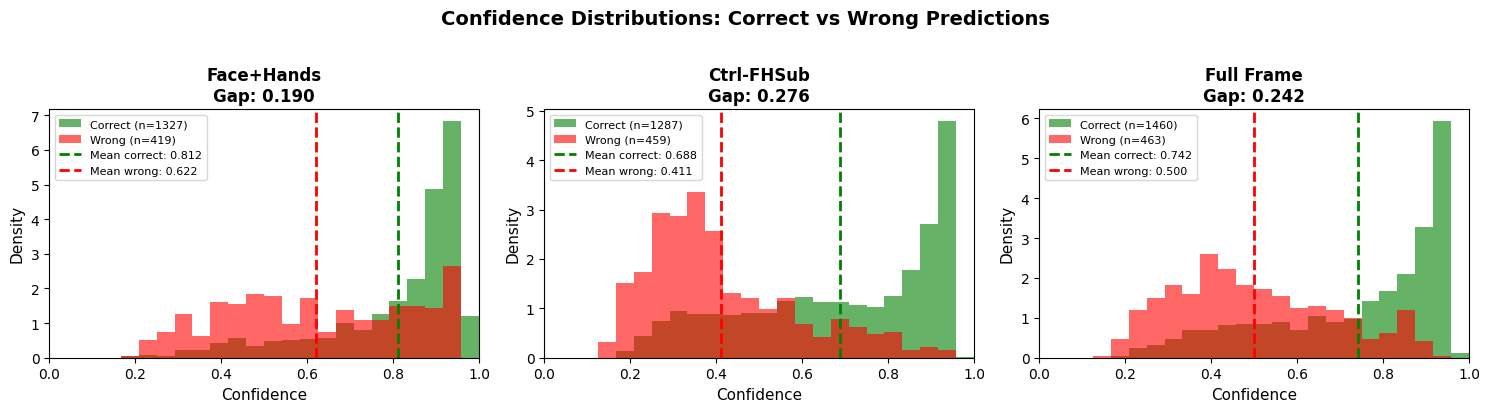

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/confidence_distributions_comparison.png


/tmp/ipython-input-88331995.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
/tmp/ipython-input-88331995.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
/tmp/ipython-input-88331995.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=labels, patch_artist=True)


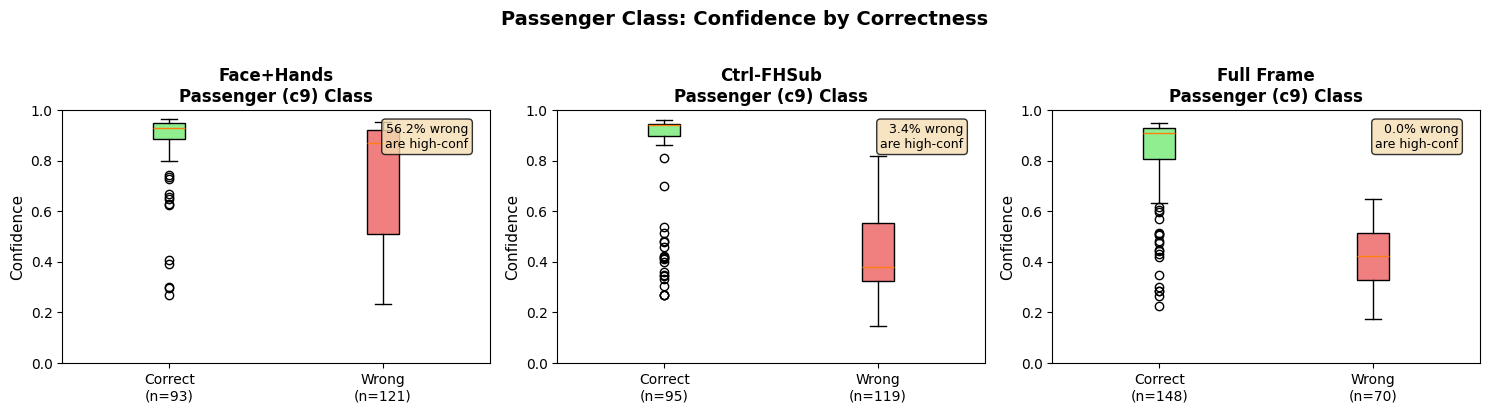

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/passenger_confidence_comparison.png


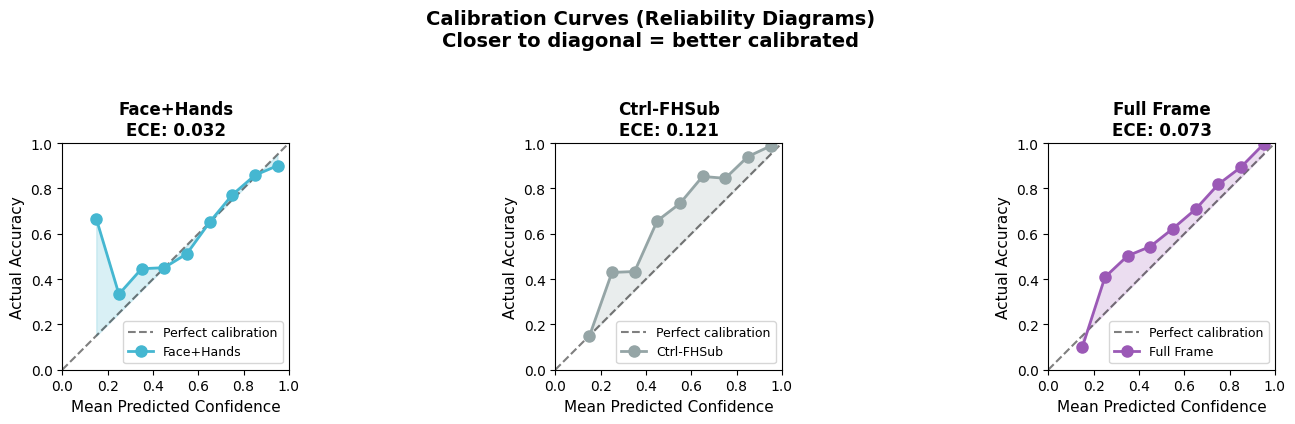

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/calibration_curves_comparison.png


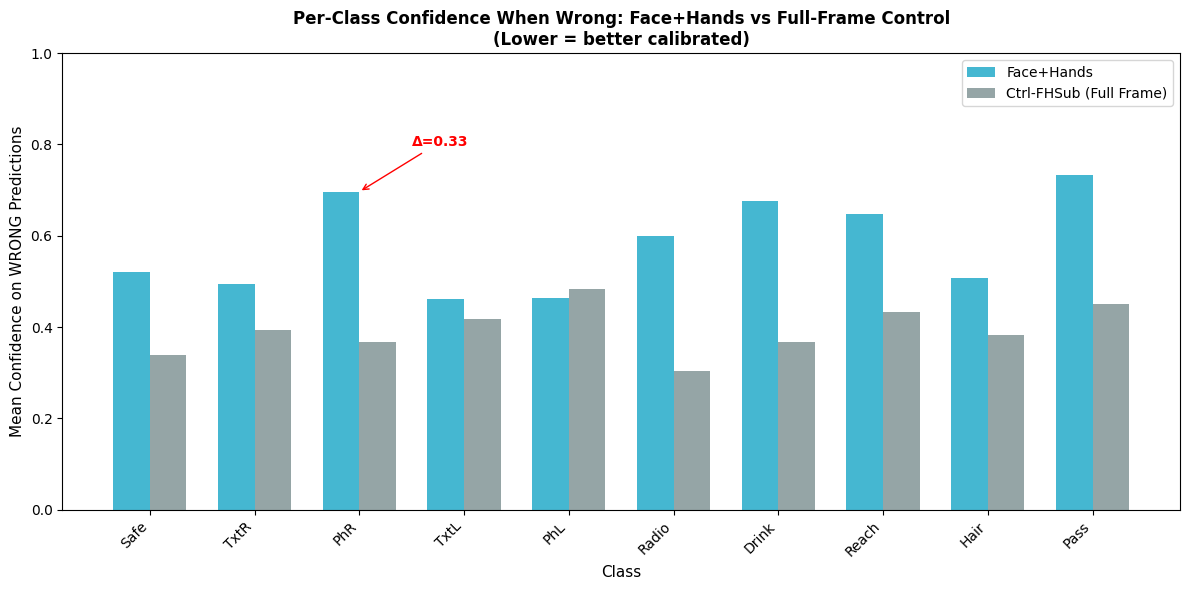

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/perclass_wrong_confidence_comparison.png

📊 CALIBRATION SUMMARY
     Model Conf (Correct) Conf (Wrong)   Gap   ECE Passenger Wrong Conf
Face+Hands          0.812        0.622 0.190 0.032                0.733
Ctrl-FHSub          0.688        0.411 0.276 0.121                0.450
Full Frame          0.742        0.500 0.242 0.073                0.423

💡 KEY INSIGHT

Face+Hands vs Ctrl-FHSub (same 1746 images, different input representation):

  WHEN MAKING MISTAKES:
  - Face+Hands mean confidence:  0.622
  - Ctrl-FHSub mean confidence:  0.411
  - Difference:                  +0.211 (Face+Hands more confident when wrong!)

  WHY THIS MATTERS:
  The Face+Hands model sees a "clean" crop (face + visible hands) and confidently predicts.
  But for ambiguous classes like Passenger, the critical information (the passenger themselves)
  is not in the crop. The model is confident because the INPUT looks complete, even though
  it's missing the d

In [ ]:
# ============================================================================
# 📊 FULL CALIBRATION COMPARISON: Face+Hands vs Controls
# ============================================================================
# Compares confidence distributions, calibration curves, and per-class patterns
# Focus on understanding WHY Face+Hands is overconfident

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

# ============================================================================
# CONFIGURATION
# ============================================================================
# Paths to predictions (update if needed)
PRED_PATHS = {
    "Face+Hands": Path(OUT_ROOT) / "preds/test/effb0_face_hands_1_11_test.csv",
    "Ctrl-FHSub": Path(OUT_ROOT) / "preds/test/effb0_full_image_fhsubset_1_10_test.csv",
    "Full Frame": Path(OUT_ROOT) / "preds/test/effb0_full_image_1_11_test.csv",
}

CLASS_NAMES = {
    0: "Safe", 1: "TxtR", 2: "PhR", 3: "TxtL",
    4: "PhL", 5: "Radio", 6: "Drink", 7: "Reach",
    8: "Hair", 9: "Pass",
}

COLORS = {
    "Face+Hands": "#45B7D1",
    "Ctrl-FHSub": "#95A5A6",
    "Full Frame": "#9B59B6",
}

# ============================================================================
# LOAD DATA
# ============================================================================
def load_preds(path):
    df = pd.read_csv(path)
    df["true"] = df["path"].apply(lambda p: int([x for x in Path(p).parts if x.startswith("c") and len(x)==2][-1][1]))
    df["pred"] = df["pred_class_id"].apply(lambda x: int(x[1]) if isinstance(x, str) and x.startswith("c") else int(x))
    df["correct"] = df["pred"] == df["true"]
    return df

data = {}
for name, path in PRED_PATHS.items():
    if path.exists():
        data[name] = load_preds(path)
        print(f"✅ Loaded {name}: {len(data[name])} samples")
    else:
        print(f"⚠️ Missing: {name}")

# ============================================================================
# FIGURE 1: CONFIDENCE DISTRIBUTIONS (Correct vs Wrong)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, df) in zip(axes, data.items()):
    correct_conf = df[df["correct"]]["confidence"]
    wrong_conf = df[~df["correct"]]["confidence"]

    # Histogram
    bins = np.linspace(0, 1, 25)
    ax.hist(correct_conf, bins=bins, alpha=0.6, label=f"Correct (n={len(correct_conf)})",
            color="green", density=True)
    ax.hist(wrong_conf, bins=bins, alpha=0.6, label=f"Wrong (n={len(wrong_conf)})",
            color="red", density=True)

    # Add vertical lines for means
    ax.axvline(correct_conf.mean(), color="green", linestyle="--", linewidth=2,
               label=f"Mean correct: {correct_conf.mean():.3f}")
    ax.axvline(wrong_conf.mean(), color="red", linestyle="--", linewidth=2,
               label=f"Mean wrong: {wrong_conf.mean():.3f}")

    ax.set_xlabel("Confidence", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.set_title(f"{name}\nGap: {correct_conf.mean() - wrong_conf.mean():.3f}",
                 fontsize=12, fontweight="bold")
    ax.legend(fontsize=8, loc="upper left")
    ax.set_xlim(0, 1)

plt.suptitle("Confidence Distributions: Correct vs Wrong Predictions", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "confidence_distributions_comparison.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# FIGURE 2: PASSENGER CLASS DEEP DIVE
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, df) in zip(axes, data.items()):
    # Filter to Passenger class (true label = 9)
    pass_df = df[df["true"] == 9]

    correct_conf = pass_df[pass_df["correct"]]["confidence"]
    wrong_conf = pass_df[~pass_df["correct"]]["confidence"]

    # Box plots
    box_data = []
    labels = []
    if len(correct_conf) > 0:
        box_data.append(correct_conf)
        labels.append(f"Correct\n(n={len(correct_conf)})")
    if len(wrong_conf) > 0:
        box_data.append(wrong_conf)
        labels.append(f"Wrong\n(n={len(wrong_conf)})")

    if box_data:
        bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightgreen')
        if len(box_data) > 1:
            bp['boxes'][1].set_facecolor('lightcoral')

    ax.set_ylabel("Confidence", fontsize=11)
    ax.set_title(f"{name}\nPassenger (c9) Class", fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1)

    # Add stats
    if len(wrong_conf) > 0:
        pct_high_conf_wrong = (wrong_conf >= 0.8).mean() * 100
        ax.text(0.95, 0.95, f"{pct_high_conf_wrong:.1f}% wrong\nare high-conf",
                transform=ax.transAxes, ha="right", va="top", fontsize=9,
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))

plt.suptitle("Passenger Class: Confidence by Correctness", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "passenger_confidence_comparison.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# FIGURE 3: CALIBRATION CURVES (Reliability Diagrams)
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

def compute_calibration(df, n_bins=10):
    """Compute calibration curve data."""
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = []
    accuracies = []
    counts = []

    for i in range(n_bins):
        mask = (df["confidence"] >= bins[i]) & (df["confidence"] < bins[i+1])
        if mask.sum() > 0:
            bin_centers.append((bins[i] + bins[i+1]) / 2)
            accuracies.append(df[mask]["correct"].mean())
            counts.append(mask.sum())

    return np.array(bin_centers), np.array(accuracies), np.array(counts)

for ax, (name, df) in zip(axes, data.items()):
    bin_centers, accuracies, counts = compute_calibration(df, n_bins=10)

    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration', alpha=0.5)

    # Actual calibration
    ax.plot(bin_centers, accuracies, 'o-', color=COLORS.get(name, "blue"),
            linewidth=2, markersize=8, label=name)

    # Fill area between actual and perfect (calibration error)
    ax.fill_between(bin_centers, bin_centers, accuracies, alpha=0.2, color=COLORS.get(name, "blue"))

    # Expected Calibration Error (ECE)
    weights = counts / counts.sum()
    ece = np.sum(weights * np.abs(bin_centers - accuracies))

    ax.set_xlabel("Mean Predicted Confidence", fontsize=11)
    ax.set_ylabel("Actual Accuracy", fontsize=11)
    ax.set_title(f"{name}\nECE: {ece:.3f}", fontsize=12, fontweight="bold")
    ax.legend(loc="lower right", fontsize=9)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

plt.suptitle("Calibration Curves (Reliability Diagrams)\nCloser to diagonal = better calibrated",
             fontsize=14, fontweight="bold", y=1.05)
plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "calibration_curves_comparison.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# FIGURE 4: PER-CLASS CONFIDENCE WHEN WRONG
# ============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

# Compare Face+Hands vs Ctrl-FHSub (same samples)
if "Face+Hands" in data and "Ctrl-FHSub" in data:
    fh_df = data["Face+Hands"]
    ctrl_df = data["Ctrl-FHSub"]

    x = np.arange(10)
    width = 0.35

    fh_wrong_conf = []
    ctrl_wrong_conf = []

    for c in range(10):
        fh_wrong = fh_df[(fh_df["true"] == c) & (~fh_df["correct"])]["confidence"]
        ctrl_wrong = ctrl_df[(ctrl_df["true"] == c) & (~ctrl_df["correct"])]["confidence"]

        fh_wrong_conf.append(fh_wrong.mean() if len(fh_wrong) > 0 else 0)
        ctrl_wrong_conf.append(ctrl_wrong.mean() if len(ctrl_wrong) > 0 else 0)

    bars1 = ax.bar(x - width/2, fh_wrong_conf, width, label="Face+Hands", color=COLORS["Face+Hands"])
    bars2 = ax.bar(x + width/2, ctrl_wrong_conf, width, label="Ctrl-FHSub (Full Frame)", color=COLORS["Ctrl-FHSub"])

    ax.set_xlabel("Class", fontsize=11)
    ax.set_ylabel("Mean Confidence on WRONG Predictions", fontsize=11)
    ax.set_title("Per-Class Confidence When Wrong: Face+Hands vs Full-Frame Control\n(Lower = better calibrated)",
                 fontsize=12, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([CLASS_NAMES.get(c, f"c{c}") for c in range(10)], rotation=45, ha="right")
    ax.legend()
    ax.set_ylim(0, 1)

    # Highlight the biggest difference
    diffs = np.array(fh_wrong_conf) - np.array(ctrl_wrong_conf)
    max_diff_idx = np.argmax(diffs)
    ax.annotate(f"Δ={diffs[max_diff_idx]:.2f}",
                xy=(max_diff_idx, fh_wrong_conf[max_diff_idx]),
                xytext=(max_diff_idx + 0.5, fh_wrong_conf[max_diff_idx] + 0.1),
                fontsize=10, fontweight="bold", color="red",
                arrowprops=dict(arrowstyle="->", color="red"))

plt.tight_layout()
out_path = Path(OUT_ROOT) / "metrics" / "perclass_wrong_confidence_comparison.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"💾 Saved: {out_path}")

# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "=" * 90)
print("📊 CALIBRATION SUMMARY")
print("=" * 90)

summary_data = []
for name, df in data.items():
    correct_conf = df[df["correct"]]["confidence"].mean()
    wrong_conf = df[~df["correct"]]["confidence"].mean()

    # ECE
    bin_centers, accuracies, counts = compute_calibration(df, n_bins=10)
    weights = counts / counts.sum()
    ece = np.sum(weights * np.abs(bin_centers - accuracies))

    # Passenger-specific
    pass_df = df[df["true"] == 9]
    pass_wrong_conf = pass_df[~pass_df["correct"]]["confidence"].mean() if len(pass_df[~pass_df["correct"]]) > 0 else np.nan

    summary_data.append({
        "Model": name,
        "Conf (Correct)": f"{correct_conf:.3f}",
        "Conf (Wrong)": f"{wrong_conf:.3f}",
        "Gap": f"{correct_conf - wrong_conf:.3f}",
        "ECE": f"{ece:.3f}",
        "Passenger Wrong Conf": f"{pass_wrong_conf:.3f}" if not np.isnan(pass_wrong_conf) else "N/A",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# ============================================================================
# KEY INSIGHT
# ============================================================================
print("\n" + "=" * 90)
print("💡 KEY INSIGHT")
print("=" * 90)

if "Face+Hands" in data and "Ctrl-FHSub" in data:
    fh = data["Face+Hands"]
    ctrl = data["Ctrl-FHSub"]

    fh_wrong_mean = fh[~fh["correct"]]["confidence"].mean()
    ctrl_wrong_mean = ctrl[~ctrl["correct"]]["confidence"].mean()

    print(f"""
Face+Hands vs Ctrl-FHSub (same 1746 images, different input representation):

  WHEN MAKING MISTAKES:
  - Face+Hands mean confidence:  {fh_wrong_mean:.3f}
  - Ctrl-FHSub mean confidence:  {ctrl_wrong_mean:.3f}
  - Difference:                  +{fh_wrong_mean - ctrl_wrong_mean:.3f} (Face+Hands more confident when wrong!)

  WHY THIS MATTERS:
  The Face+Hands model sees a "clean" crop (face + visible hands) and confidently predicts.
  But for ambiguous classes like Passenger, the critical information (the passenger themselves)
  is not in the crop. The model is confident because the INPUT looks complete, even though
  it's missing the discriminative signal.

  The Full-Frame model (Ctrl-FHSub) sees more context, and when uncertain, its confidence
  reflects that uncertainty. This is BETTER CALIBRATION.
""")

# Save summary
summary_df.to_csv(Path(OUT_ROOT) / "metrics" / "calibration_summary.csv", index=False)
print(f"💾 Saved: {Path(OUT_ROOT) / 'metrics' / 'calibration_summary.csv'}")

📊 FACE+HANDS OVERCONFIDENT ERROR ANALYSIS (conf ≥ 0.8)

📈 Overall: 118/1022 high-conf predictions are wrong = 11.5%
   Total samples: 1746

------------------------------------------------------------------------------------------
📋 PER-CLASS OVERCONFIDENT ERRORS (sorted by contribution to total)
------------------------------------------------------------------------------------------

Class Name               N  HiConf  OvErr   Rate%  Contrib%  MinH%
------------------------------------------------------------------------------------------
c9   Passenger        214     147     68   46.3%     57.6%   71.0
c2   Phone Right      157      99     22   22.2%     18.6%   82.2
c5   Radio            170      54      9   16.7%      7.6%   77.6
c7   Reaching         125      88      6    6.8%      5.1%   33.8
c0   Safe Driving     339     160      5    3.1%      4.2%   74.2
c6   Drinking          97      86      4    4.7%      3.4%   80.2
c8   Hair/Makeup      115      66      2    3.0%      1.

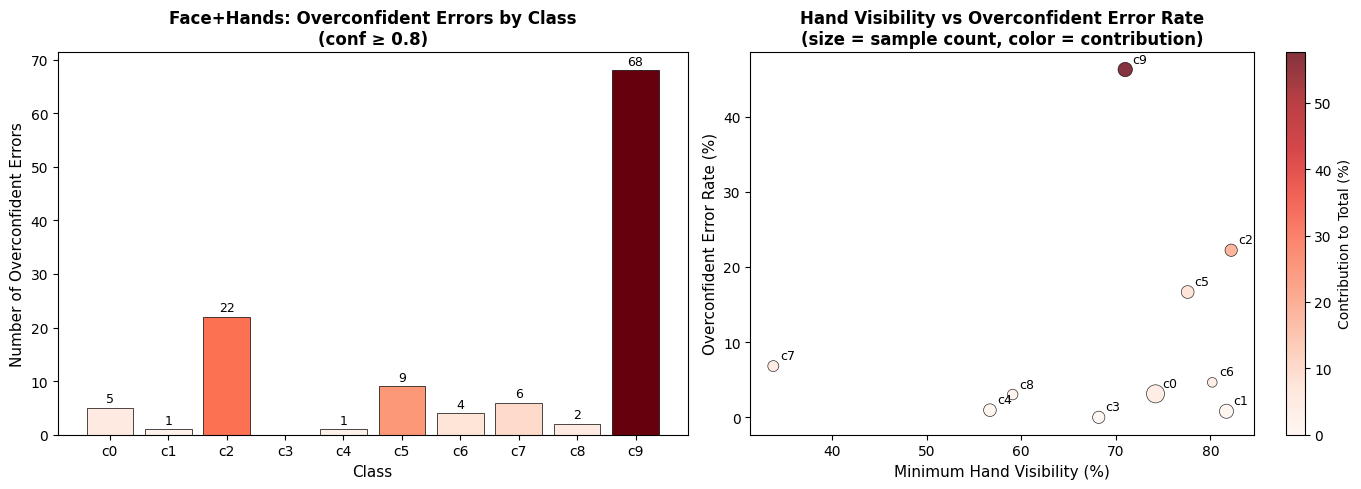


💾 Saved to: /content/drive/MyDrive/TFM/outputs/metrics/overconf_perclass_facehands.png

🔍 WHAT ARE THE OVERCONFIDENT ERRORS? (True → Predicted)

Top 10 confusion pairs among overconfident errors:
True            Predicted        Count
----------------------------------------
Passenger       Safe Driving        43
Passenger       Reaching            24
Phone Right     Hair/Makeup         21
Radio           Hair/Makeup          6
Reaching        Passenger            5
Drinking        Hair/Makeup          4
Safe Driving    Passenger            3
Radio           Passenger            3
Hair/Makeup     Phone Right          2
Phone Left      Passenger            1

📝 SUMMARY

Face+Hands Overconfident Error Analysis:
- Total overconfident errors: 118 / 1022 high-conf predictions
- Overall rate: 11.5%

Top contributing classes:
  - c9 (Passenger): 68 errors (57.6%)
  - c2 (Phone Right): 22 errors (18.6%)
  - c5 (Radio): 9 errors (7.6%)

Next steps:
- Compare these numbers with the OLD Face+Han

In [ ]:
# ============================================================================
# 🔍 DIAGNOSTIC: Per-Class Overconfident Error Analysis (Face+Hands)
# ============================================================================
# Goal: Identify which classes drive the 11.5% overconfident error rate
#       and correlate with hand visibility from detection metadata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================================
# CONFIGURATION
# ============================================================================
HIGH_CONF_THRESHOLD = 0.8

# Path to Face+Hands predictions (update if needed)
FACE_HANDS_PREDS = Path(OUT_ROOT) / "preds/test/effb0_face_hands_1_11_test.csv"

# Per-class hand visibility from your detection audit (copy from your output)
# Format: {class_id: (left_hand%, right_hand%)}
HAND_VISIBILITY = {
    0: (74.2, 89.9),   # Safe Driving
    1: (81.7, 85.8),   # Text Right
    2: (87.9, 82.2),   # Phone Right
    3: (68.2, 86.2),   # Text Left
    4: (56.7, 89.5),   # Phone Left
    5: (84.4, 77.6),   # Radio
    6: (80.2, 80.2),   # Drinking
    7: (66.8, 33.8),   # Reaching  <-- lowest right hand!
    8: (75.1, 59.1),   # Hair/Makeup
    9: (85.2, 71.0),   # Passenger
}

CLASS_NAMES = {
    0: "Safe Driving", 1: "Text Right", 2: "Phone Right", 3: "Text Left",
    4: "Phone Left", 5: "Radio", 6: "Drinking", 7: "Reaching",
    8: "Hair/Makeup", 9: "Passenger",
}

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
def extract_true_class(path_str):
    for part in reversed(Path(path_str).parts):
        if part.startswith("c") and len(part) == 2 and part[1].isdigit():
            return int(part[1])
    return -1

def parse_pred(x):
    if isinstance(x, str) and x.startswith("c") and len(x) == 2 and x[1].isdigit():
        return int(x[1])
    return int(x)

# ============================================================================
# LOAD AND ANALYZE
# ============================================================================
if not FACE_HANDS_PREDS.exists():
    raise FileNotFoundError(f"Predictions not found at {FACE_HANDS_PREDS}")

df = pd.read_csv(FACE_HANDS_PREDS)
df["true"] = df["path"].apply(extract_true_class)
df["pred"] = df["pred_class_id"].apply(parse_pred)
df = df[df["true"] >= 0].copy()

if "confidence" not in df.columns:
    raise ValueError("No confidence column in predictions!")

df["correct"] = df["pred"] == df["true"]
df["high_conf"] = df["confidence"] >= HIGH_CONF_THRESHOLD
df["overconf_error"] = (~df["correct"]) & df["high_conf"]

print("=" * 90)
print(f"📊 FACE+HANDS OVERCONFIDENT ERROR ANALYSIS (conf ≥ {HIGH_CONF_THRESHOLD})")
print("=" * 90)

# Overall stats
total_samples = len(df)
total_high_conf = df["high_conf"].sum()
total_overconf_errors = df["overconf_error"].sum()
overall_rate = (total_overconf_errors / total_high_conf * 100) if total_high_conf > 0 else 0

print(f"\n📈 Overall: {total_overconf_errors}/{total_high_conf} high-conf predictions are wrong = {overall_rate:.1f}%")
print(f"   Total samples: {total_samples}")

# ============================================================================
# PER-CLASS BREAKDOWN
# ============================================================================
print("\n" + "-" * 90)
print("📋 PER-CLASS OVERCONFIDENT ERRORS (sorted by contribution to total)")
print("-" * 90)

class_stats = []
for c in range(10):
    class_df = df[df["true"] == c]
    n_class = len(class_df)
    n_high_conf = class_df["high_conf"].sum()
    n_overconf_err = class_df["overconf_error"].sum()

    # Rate within class
    class_rate = (n_overconf_err / n_high_conf * 100) if n_high_conf > 0 else 0

    # Contribution to total overconf errors
    contribution = (n_overconf_err / total_overconf_errors * 100) if total_overconf_errors > 0 else 0

    # Hand visibility
    left_h, right_h = HAND_VISIBILITY.get(c, (0, 0))
    min_hand = min(left_h, right_h)

    class_stats.append({
        "Class": c,
        "Name": CLASS_NAMES.get(c, f"c{c}"),
        "N": n_class,
        "High-Conf": n_high_conf,
        "Overconf Err": n_overconf_err,
        "Rate (%)": class_rate,
        "Contrib (%)": contribution,
        "MinHand%": min_hand,
        "LeftH%": left_h,
        "RightH%": right_h,
    })

class_df_stats = pd.DataFrame(class_stats)

# Sort by contribution (which classes drive the problem?)
class_df_stats = class_df_stats.sort_values("Contrib (%)", ascending=False)

print(f"\n{'Class':<4} {'Name':<14} {'N':>5} {'HiConf':>7} {'OvErr':>6} {'Rate%':>7} {'Contrib%':>9} {'MinH%':>6}")
print("-" * 90)
for _, row in class_df_stats.iterrows():
    print(f"c{row['Class']:<3} {row['Name']:<14} {row['N']:>5} {row['High-Conf']:>7} "
          f"{row['Overconf Err']:>6} {row['Rate (%)']:>6.1f}% {row['Contrib (%)']:>8.1f}% {row['MinHand%']:>6.1f}")

# ============================================================================
# TOP CONTRIBUTORS
# ============================================================================
print("\n" + "=" * 90)
print("🎯 TOP CONTRIBUTORS TO OVERCONFIDENT ERRORS")
print("=" * 90)

top_3 = class_df_stats.head(3)
for i, (_, row) in enumerate(top_3.iterrows(), 1):
    print(f"\n#{i}: c{row['Class']} ({row['Name']})")
    print(f"    → {row['Overconf Err']:.0f} overconf errors ({row['Contrib (%)']:.1f}% of all)")
    print(f"    → Within-class overconf rate: {row['Rate (%)']:.1f}%")
    print(f"    → Hand visibility: Left={row['LeftH%']:.1f}%, Right={row['RightH%']:.1f}% (min={row['MinHand%']:.1f}%)")

# ============================================================================
# CORRELATION: Hand Visibility vs Overconf Rate
# ============================================================================
print("\n" + "=" * 90)
print("📉 CORRELATION: Min Hand Visibility vs Overconfident Error Rate")
print("=" * 90)

# Compute correlation
valid_rows = class_df_stats[class_df_stats["High-Conf"] > 5]  # Need enough samples
if len(valid_rows) >= 5:
    corr = valid_rows["MinHand%"].corr(valid_rows["Rate (%)"])
    print(f"\nPearson correlation: r = {corr:.3f}")

    if corr < -0.3:
        print("→ Negative correlation: Lower hand visibility → Higher overconf errors ✓")
    elif corr > 0.3:
        print("→ Positive correlation: Higher hand visibility → Higher overconf errors (unexpected)")
    else:
        print("→ Weak/no correlation: Hand visibility doesn't strongly predict overconf errors")
else:
    print("⚠️ Not enough classes with sufficient high-conf samples for correlation")

# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Per-class contribution (bar chart) ---
ax1 = axes[0]
class_df_sorted = class_df_stats.sort_values("Class")
colors = plt.cm.Reds(class_df_sorted["Rate (%)"] / class_df_sorted["Rate (%)"].max())

bars = ax1.bar(
    [f"c{int(c)}" for c in class_df_sorted["Class"]],
    class_df_sorted["Overconf Err"],
    color=colors,
    edgecolor="black",
    linewidth=0.5
)
ax1.set_xlabel("Class", fontsize=11)
ax1.set_ylabel("Number of Overconfident Errors", fontsize=11)
ax1.set_title(f"Face+Hands: Overconfident Errors by Class\n(conf ≥ {HIGH_CONF_THRESHOLD})",
              fontsize=12, fontweight="bold")

# Add value labels
for bar, val in zip(bars, class_df_sorted["Overconf Err"]):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{int(val)}", ha="center", va="bottom", fontsize=9)

# --- Plot 2: Scatter - Min Hand Visibility vs Overconf Rate ---
ax2 = axes[1]
scatter = ax2.scatter(
    class_df_stats["MinHand%"],
    class_df_stats["Rate (%)"],
    s=class_df_stats["N"] / 2,  # Size by sample count
    c=class_df_stats["Contrib (%)"],
    cmap="Reds",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8
)

# Label points
for _, row in class_df_stats.iterrows():
    ax2.annotate(
        f"c{int(row['Class'])}",
        (row["MinHand%"], row["Rate (%)"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9
    )

ax2.set_xlabel("Minimum Hand Visibility (%)", fontsize=11)
ax2.set_ylabel("Overconfident Error Rate (%)", fontsize=11)
ax2.set_title("Hand Visibility vs Overconfident Error Rate\n(size = sample count, color = contribution)",
              fontsize=12, fontweight="bold")

plt.colorbar(scatter, ax=ax2, label="Contribution to Total (%)")

plt.tight_layout()

# Save
out_path = Path(OUT_ROOT) / "metrics" / "overconf_perclass_facehands.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print(f"\n💾 Saved to: {out_path}")

# ============================================================================
# CONFUSION MATRIX OF OVERCONFIDENT ERRORS
# ============================================================================
print("\n" + "=" * 90)
print("🔍 WHAT ARE THE OVERCONFIDENT ERRORS? (True → Predicted)")
print("=" * 90)

overconf_df = df[df["overconf_error"]]
if len(overconf_df) > 0:
    confusion_pairs = overconf_df.groupby(["true", "pred"]).size().reset_index(name="count")
    confusion_pairs = confusion_pairs.sort_values("count", ascending=False).head(10)

    print(f"\nTop 10 confusion pairs among overconfident errors:")
    print(f"{'True':<15} {'Predicted':<15} {'Count':>6}")
    print("-" * 40)
    for _, row in confusion_pairs.iterrows():
        true_name = CLASS_NAMES.get(row["true"], f"c{row['true']}")
        pred_name = CLASS_NAMES.get(row["pred"], f"c{row['pred']}")
        print(f"{true_name:<15} {pred_name:<15} {row['count']:>6}")
else:
    print("No overconfident errors to analyze.")

# ============================================================================
# COMPARE WITH OLD (if you have it)
# ============================================================================
print("\n" + "=" * 90)
print("📝 SUMMARY")
print("=" * 90)
print(f"""
Face+Hands Overconfident Error Analysis:
- Total overconfident errors: {total_overconf_errors} / {total_high_conf} high-conf predictions
- Overall rate: {overall_rate:.1f}%

Top contributing classes:
{chr(10).join([f"  - c{int(row['Class'])} ({row['Name']}): {row['Overconf Err']:.0f} errors ({row['Contrib (%)']:.1f}%)" for _, row in top_3.iterrows()])}

Next steps:
- Compare these numbers with the OLD Face+Hands run to see what shifted
- Check if the removed 52 samples were from specific classes
- Examine mean confidence (is the new model more confident overall?)
""")

## 📊 Section 8: Stability Analysis (Multi-Seed Comparison)

Compare multiple runs of the same configuration with different random seeds to assess training stability.


## 📝 Section 9: Thesis Summary Exporter

Generate publication-ready tables in CSV and LaTeX format for your thesis.


In [ ]:
# Thesis Summary Exporter: Generate LaTeX and CSV tables

def generate_thesis_tables():
    """Generate publication-ready summary tables for thesis."""

    # ========== TABLE 1: Main Results (5-Run Comparison) ==========
    print("=" * 80)
    print("📊 TABLE 1: Main Experimental Results (5-Run Plan)")
    print("=" * 80)

    main_results = []
    run_order = [
        ("Run 1", "Full Frame", "All IDs", "full-frame"),
        ("Run 2", "Face Only", "Face-available", "face ROI"),
        ("Run 3", "Face+Hands", "FH-available", "face+hands ROI"),
        ("Run 4", "Ctrl-FaceSub", "Face-available", "full-frame"),
        ("Run 5", "Ctrl-FHSub", "FH-available", "full-frame"),
    ]

    for run_id, mod_name, id_set, input_type in run_order:
        if mod_name in modalities and modalities[mod_name]:
            m = modalities[mod_name]
            main_results.append({
                "Run": run_id,
                "Model": mod_name,
                "ID Set": id_set,
                "Input": input_type,
                "N": m["n_samples"],
                "Accuracy (%)": f"{m['accuracy']*100:.2f}",
                "Macro-F1 (%)": f"{m['macro_f1']*100:.2f}",
                "Precision (%)": f"{m['macro_precision']*100:.2f}",
                "Recall (%)": f"{m['macro_recall']*100:.2f}",
            })

    main_df = pd.DataFrame(main_results)
    print(main_df.to_string(index=False))

    # ========== TABLE 2: Control Comparison (ROI Effect) ==========
    print("\n" + "=" * 80)
    print("📊 TABLE 2: ROI Effect Analysis (Same IDs, Different Input)")
    print("=" * 80)

    roi_effect = []
    comparisons = [
        ("Face+Hands", "Ctrl-FHSub", "Face+Hands ROI vs Full-Frame"),
        ("Face Only", "Ctrl-FaceSub", "Face ROI vs Full-Frame"),
    ]

    for roi_name, ctrl_name, desc in comparisons:
        if roi_name in modalities and ctrl_name in modalities:
            roi_m = modalities[roi_name]
            ctrl_m = modalities[ctrl_name]
            roi_effect.append({
                "Comparison": desc,
                "ROI Acc (%)": f"{roi_m['accuracy']*100:.2f}",
                "Ctrl Acc (%)": f"{ctrl_m['accuracy']*100:.2f}",
                "Δ Acc (pp)": f"{(roi_m['accuracy']-ctrl_m['accuracy'])*100:+.2f}",
                "ROI F1 (%)": f"{roi_m['macro_f1']*100:.2f}",
                "Ctrl F1 (%)": f"{ctrl_m['macro_f1']*100:.2f}",
                "Δ F1 (pp)": f"{(roi_m['macro_f1']-ctrl_m['macro_f1'])*100:+.2f}",
            })

    if roi_effect:
        roi_df = pd.DataFrame(roi_effect)
        print(roi_df.to_string(index=False))

    # ========== SAVE CSV FILES ==========
    out_dir = Path(OUT_ROOT) / "metrics" / "thesis_tables"
    out_dir.mkdir(parents=True, exist_ok=True)

    main_df.to_csv(out_dir / "table1_main_results.csv", index=False)
    print(f"\n💾 Saved: {out_dir / 'table1_main_results.csv'}")

    if roi_effect:
        roi_df.to_csv(out_dir / "table2_roi_effect.csv", index=False)
        print(f"💾 Saved: {out_dir / 'table2_roi_effect.csv'}")

    # ========== GENERATE LATEX ==========
    print("\n" + "=" * 80)
    print("📝 LATEX TABLE 1: Main Results")
    print("=" * 80)

    latex_main = r"""\begin{table}[htbp]
\centering
\caption{5-Run Experimental Results: Accuracy and Macro-F1 across modalities}
\label{tab:main_results}
\begin{tabular}{llllrrr}
\toprule
Run & Model & ID Set & Input & N & Accuracy (\%) & Macro-F1 (\%) \\
\midrule
"""
    for _, row in main_df.iterrows():
        latex_main += f"{row['Run']} & {row['Model']} & {row['ID Set']} & {row['Input']} & {row['N']} & {row['Accuracy (%)']} & {row['Macro-F1 (%)']} \\\\\n"

    latex_main += r"""\bottomrule
\end{tabular}
\end{table}
"""
    print(latex_main)

    # Save LaTeX
    with open(out_dir / "table1_main_results.tex", "w") as f:
        f.write(latex_main)
    print(f"💾 Saved: {out_dir / 'table1_main_results.tex'}")

    if roi_effect:
        print("\n" + "=" * 80)
        print("📝 LATEX TABLE 2: ROI Effect")
        print("=" * 80)

        latex_roi = r"""\begin{table}[htbp]
\centering
\caption{ROI Effect Analysis: Comparing ROI crops vs full-frame on identical image IDs}
\label{tab:roi_effect}
\begin{tabular}{lrrrrrr}
\toprule
Comparison & ROI Acc & Ctrl Acc & $\Delta$ Acc & ROI F1 & Ctrl F1 & $\Delta$ F1 \\
\midrule
"""
        for _, row in roi_df.iterrows():
            latex_roi += f"{row['Comparison']} & {row['ROI Acc (%)']} & {row['Ctrl Acc (%)']} & {row['Δ Acc (pp)']} & {row['ROI F1 (%)']} & {row['Ctrl F1 (%)']} & {row['Δ F1 (pp)']} \\\\\n"

        latex_roi += r"""\bottomrule
\end{tabular}
\end{table}
"""
        print(latex_roi)

        with open(out_dir / "table2_roi_effect.tex", "w") as f:
            f.write(latex_roi)
        print(f"💾 Saved: {out_dir / 'table2_roi_effect.tex'}")

    return main_df, roi_df if roi_effect else None

# Generate tables
main_table, roi_table = generate_thesis_tables()


📊 TABLE 1: Main Experimental Results (5-Run Plan)
  Run        Model         ID Set          Input    N Accuracy (%) Macro-F1 (%) Precision (%) Recall (%)
Run 1   Full Frame        All IDs     full-frame 1923        75.92        75.59         79.62      75.32
Run 2    Face Only Face-available       face ROI 1777        52.17        52.21         64.22      54.92
Run 3   Face+Hands   FH-available face+hands ROI 1746        76.00        76.05         77.79      77.06
Run 4 Ctrl-FaceSub Face-available     full-frame 1777        71.58        71.77         77.76      72.05
Run 5   Ctrl-FHSub   FH-available     full-frame 1746        73.71        72.86         76.28      73.72

📊 TABLE 2: ROI Effect Analysis (Same IDs, Different Input)
                  Comparison ROI Acc (%) Ctrl Acc (%) Δ Acc (pp) ROI F1 (%) Ctrl F1 (%) Δ F1 (pp)
Face+Hands ROI vs Full-Frame       76.00        73.71      +2.29      76.05       72.86     +3.19
      Face ROI vs Full-Frame       52.17        71.58     -19.41

In [ ]:
# Generate per-class F1 LaTeX table for thesis
print("=" * 80)
print("📝 LATEX TABLE 3: Per-Class F1 Scores")
print("=" * 80)

out_dir = Path(OUT_ROOT) / "metrics" / "thesis_tables"

# Build per-class data
perclass_data = []
for c in range(10):
    row = {"Class": f"c{c}", "Name": CLASS_NAMES.get(c, f"Class {c}")}

    for mod_name in ["Full Frame", "Face Only", "Face+Hands", "Ctrl-FHSub"]:
        if mod_name in modalities and modalities[mod_name]:
            f1 = modalities[mod_name]["per_class_f1"][c] * 100
            row[mod_name] = f"{f1:.1f}"
        else:
            row[mod_name] = "—"

    perclass_data.append(row)

perclass_df = pd.DataFrame(perclass_data)

# Generate LaTeX
latex_perclass = r"""\begin{table}[htbp]
\centering
\caption{Per-class F1 scores (\%) across modalities}
\label{tab:perclass_f1}
\begin{tabular}{llrrrr}
\toprule
Class & Description & Full-Frame & Face & Face+Hands & Ctrl-FH \\
\midrule
"""

for _, row in perclass_df.iterrows():
    name_escaped = row["Name"].replace("&", r"\&")
    latex_perclass += f"{row['Class']} & {name_escaped} & {row.get('Full Frame', '—')} & {row.get('Face Only', '—')} & {row.get('Face+Hands', '—')} & {row.get('Ctrl-FHSub', '—')} \\\\\n"

latex_perclass += r"""\bottomrule
\end{tabular}
\end{table}
"""

print(latex_perclass)

# Save
with open(out_dir / "table3_perclass_f1.tex", "w") as f:
    f.write(latex_perclass)
print(f"💾 Saved: {out_dir / 'table3_perclass_f1.tex'}")

perclass_df.to_csv(out_dir / "table3_perclass_f1.csv", index=False)
print(f"💾 Saved: {out_dir / 'table3_perclass_f1.csv'}")


📝 LATEX TABLE 3: Per-Class F1 Scores
\begin{table}[htbp]
\centering
\caption{Per-class F1 scores (\%) across modalities}
\label{tab:perclass_f1}
\begin{tabular}{llrrrr}
\toprule
Class & Description & Full-Frame & Face & Face+Hands & Ctrl-FH \\
\midrule
c0 & Safe Driving & 76.0 & 43.1 & 78.9 & 72.6 \\
c1 & Text Right & 79.4 & 20.2 & 87.1 & 84.3 \\
c2 & Phone Right & 58.7 & 69.3 & 76.3 & 75.2 \\
c3 & Text Left & 65.4 & 27.5 & 81.3 & 56.0 \\
c4 & Phone Left & 91.3 & 76.3 & 95.0 & 75.7 \\
c5 & Radio & 94.9 & 33.2 & 65.5 & 94.3 \\
c6 & Drinking & 83.9 & 70.8 & 90.2 & 81.9 \\
c7 & Reaching & 86.9 & 52.3 & 73.4 & 76.5 \\
c8 & Hair/Makeup & 46.6 & 38.8 & 63.0 & 59.5 \\
c9 & Passenger & 72.7 & 90.7 & 49.9 & 52.8 \\
\bottomrule
\end{tabular}
\end{table}

💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/thesis_tables/table3_perclass_f1.tex
💾 Saved: /content/drive/MyDrive/TFM/outputs/metrics/thesis_tables/table3_perclass_f1.csv


## ✅ Modality Analysis Complete!

**Outputs saved to Drive:**

📊 **Analysis Results:**
- `OUT_ROOT/metrics/perclass_f1_with_deltas.csv` — Per-class comparison table (all 5 runs)
- `OUT_ROOT/metrics/perclass_f1_comparison.png` — Bar chart
- `OUT_ROOT/metrics/delta_heatmap_f1_modalities.png` — Delta heatmap
- `OUT_ROOT/metrics/confusion_matrices_all.png` — Confusion matrices (up to 5 runs)
- `OUT_ROOT/metrics/control_run_comparison.csv` — Control vs ROI analysis
- `OUT_ROOT/metrics/stability_analysis.csv` — Multi-seed stability results (if available)

📝 **Thesis Tables (LaTeX + CSV):**
- `OUT_ROOT/metrics/thesis_tables/table1_main_results.tex` — Main 5-run results
- `OUT_ROOT/metrics/thesis_tables/table2_roi_effect.tex` — ROI effect analysis
- `OUT_ROOT/metrics/thesis_tables/table3_perclass_f1.tex` — Per-class F1 scores

**5-Run Experimental Summary:**
| Run | Type | Comparison |
|-----|------|------------|
| 1 | Full Frame | Baseline (all IDs) |
| 2 | Face ROI | ROI extraction |
| 3 | Face+Hands ROI | ROI extraction |
| 4 | Ctrl-FaceSub | Same IDs as Run 2 |
| 5 | Ctrl-FHSub | Same IDs as Run 3 |

**Key comparisons for thesis:**
- Run 3 vs Run 5 → Isolates ROI effect for face+hands (same IDs, different input)
- Run 2 vs Run 4 → Isolates ROI effect for face only

**Stability Analysis:**
- Add multi-seed runs to Section 8 to assess training variance
- Report mean ± std for robust conclusions

**Next steps:**
- Run **05_gradcam.ipynb** for attention visualizations
